In [2]:
#####################################################
# File Name: Keras_Dog_Breed_Aug.ipynb
# Author: Tu Lan @ SJSU EE258
# Modify Date: 12/16/2017
#####################################################

# basic libraries
import cv2
import numpy as np
from tqdm import tqdm
import pandas as pd
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns

# state(reproduce) control, I like 22
state = np.random.seed(22)

# All important directories for this project
ROOT_PATH = '/media/tulan/Linux/Pycharm/Kaggle/Kaggle_Competetion/Dog Breed'
INPUT_PATH = '/media/tulan/Linux/Pycharm/Kaggle/Kaggle_Competetion/Dog Breed/input'
BOTTLE_PATH = '/media/tulan/Linux/Pycharm/Kaggle/Kaggle_Competetion/Dog Breed/bottle_feature'
WEIGHT_PATH = '/media/tulan/Linux/Pycharm/Kaggle/Kaggle_Competetion/Dog Breed/weights'
IMG_RESULT_PATH = '/media/tulan/Linux/Pycharm/Kaggle/Kaggle_Competetion/Dog Breed/image_result'
LOG_PATH = '/media/tulan/Linux/Pycharm/Kaggle/Kaggle_Competetion/Dog Breed/Tensorboard_logs'

# save the figures
def save_fig(fig_id, tight_layout=True):
    # if not such directory, create one
    if not os.path.exists(IMG_RESULT_PATH):
        os.makedirs(IMG_RESULT_PATH)
    path = os.path.join(IMG_RESULT_PATH, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=600)

Import Keras Moduls

In [4]:
import keras
from keras.layers import *
from keras.models import *
from keras.applications import *
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

Take a look at the image id and correcspongding labels

In [5]:
df = pd.read_csv(INPUT_PATH + '/labels.csv')
df.head(5)

<div>
<style>
    .dataframe thead tr:only-child th {
        text-align: right;
    }

    .dataframe thead th {
        text-align: left;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>id</th>
      <th>breed</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>000bec180eb18c7604dcecc8fe0dba07</td>
      <td>boston_bull</td>
    </tr>
    <tr>
      <th>1</th>
      <td>001513dfcb2ffafc82cccf4d8bbaba97</td>
      <td>dingo</td>
    </tr>
    <tr>
      <th>2</th>
      <td>001cdf01b096e06d78e9e5112d419397</td>
      <td>pekinese</td>
    </tr>
    <tr>
      <th>3</th>
      <td>00214f311d5d2247d5dfe4fe24b2303d</td>
      <td>bluetick</td>
    </tr>
    <tr>
      <th>4</th>
      <td>0021f9ceb3235effd7fcde7f7538ed62</td>
      <td>golden_retriever</td>
    </tr>
  </tbody>
</table>
</div>

Saving figure ori train count plot


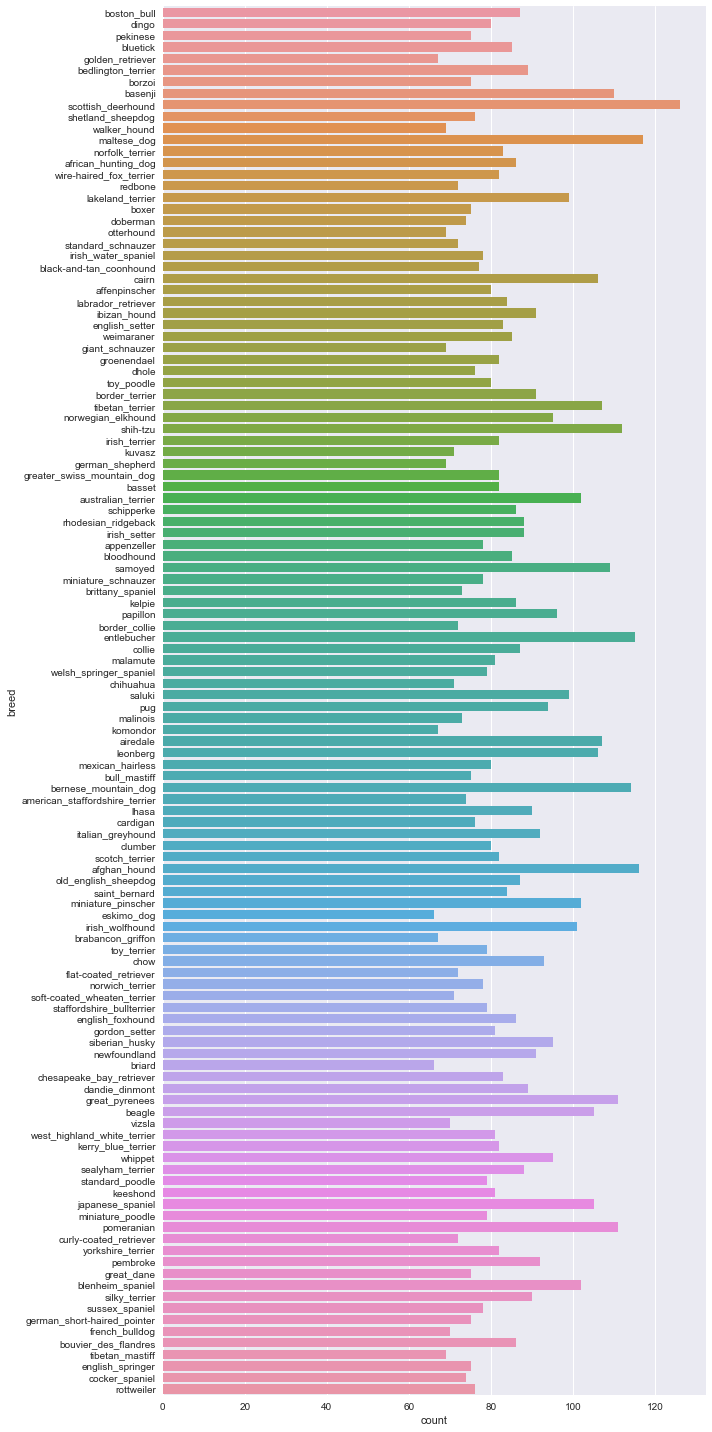

In [97]:
# A count plot for all the dog breeds (training set)
plt.figure(figsize=(10, 20))
sns.countplot(y=df['breed'])
save_fig('ori train count plot')

Preparation for loading the data

In [6]:
n = len(df) # number of images (training data set)

# obtain the breed set
# make it sorted, make it in the order of output, it is important
breed = sorted(set(df['breed'])) 

n_class = len(breed) # number of dog breeds

# create a dictionary to map the breed name to a number id (0 - 119)
class_to_num = dict(zip(breed, range(n_class)))

# create a dictionary to map the number id (0 - 119) to breed name
num_to_class = dict(zip(range(n_class), breed))

Load the training images and labels

In [4]:
# use a big resolution (350, 350)
width = 350
# create the hold places for X(float 16 is enough, and saves RAM) and y
X = np.zeros((n, width, width, 3), dtype=np.float16)
# one-hot hold place for labels
y = np.zeros((n, n_class), dtype=np.uint8)

# use openCV to read and resize images
# use tqdm to track the progress
for i in tqdm(range(n)):
    X[i] = cv2.resize(cv2.imread(INPUT_PATH + '/train/%s.jpg' % df['id'][i]), (width, width))
    # change the correct label in one-hot to '1', the others keep '0'
    y[i][class_to_num[df['breed'][i]]] = 1

  0%|          | 0/10222 [00:00<?, ?it/s]

  0%|          | 37/10222 [00:00<00:28, 356.33it/s]

  1%|          | 79/10222 [00:00<00:26, 384.65it/s]

  1%|          | 124/10222 [00:00<00:24, 404.06it/s]

  2%|▏         | 164/10222 [00:00<00:25, 402.09it/s]

  2%|▏         | 202/10222 [00:00<00:25, 397.58it/s]

  2%|▏         | 246/10222 [00:00<00:24, 404.19it/s]

  3%|▎         | 296/10222 [00:00<00:23, 417.62it/s]

  3%|▎         | 346/10222 [00:00<00:23, 426.80it/s]

  4%|▍         | 392/10222 [00:00<00:22, 430.12it/s]

  4%|▍         | 436/10222 [00:01<00:22, 428.81it/s]

  5%|▍         | 481/10222 [00:01<00:22, 430.17it/s]

  5%|▌         | 525/10222 [00:01<00:22, 424.18it/s]

  6%|▌         | 573/10222 [00:01<00:22, 427.69it/s]

  6%|▌         | 619/10222 [00:01<00:22, 429.28it/s]

  6%|▋         | 663/10222 [00:01<00:22, 428.91it/s]

  7%|▋         | 712/10222 [00:01<00:22, 432.07it/s]

  7%|▋         | 760/10222 [00:01<00:21, 434.22it/s]

  8%|▊         | 806/10222 [00:01<00:21, 434.36it/s]

  8%|▊         | 851/10222 [00:01<00:21, 434.99it/s]

  9%|▉         | 896/10222 [00:02<00:21, 435.64it/s]

  9%|▉         | 945/10222 [00:02<00:21, 437.87it/s]

 10%|▉         | 993/10222 [00:02<00:21, 439.46it/s]

 10%|█         | 1040/10222 [00:02<00:20, 439.62it/s]

 11%|█         | 1086/10222 [00:02<00:20, 439.14it/s]

 11%|█         | 1131/10222 [00:02<00:20, 435.95it/s]

 12%|█▏        | 1177/10222 [00:02<00:20, 436.74it/s]

 12%|█▏        | 1221/10222 [00:02<00:20, 436.58it/s]

 12%|█▏        | 1273/10222 [00:02<00:20, 439.35it/s]

 13%|█▎        | 1322/10222 [00:02<00:20, 440.93it/s]

 13%|█▎        | 1369/10222 [00:03<00:20, 441.23it/s]

 14%|█▍        | 1418/10222 [00:03<00:19, 442.49it/s]

 14%|█▍        | 1465/10222 [00:03<00:19, 443.31it/s]

 15%|█▍        | 1512/10222 [00:03<00:19, 444.08it/s]

 15%|█▌        | 1563/10222 [00:03<00:19, 445.72it/s]

 16%|█▌        | 1611/10222 [00:03<00:19, 445.87it/s]

 16%|█▋        | 1662/10222 [00:03<00:19, 447.53it/s]

 17%|█▋        | 1711/10222 [00:03<00:18, 448.28it/s]

 17%|█▋        | 1761/10222 [00:03<00:18, 449.36it/s]

 18%|█▊        | 1812/10222 [00:04<00:18, 450.80it/s]

 18%|█▊        | 1861/10222 [00:04<00:18, 450.05it/s]

 19%|█▊        | 1909/10222 [00:04<00:18, 450.67it/s]

 19%|█▉        | 1959/10222 [00:04<00:18, 451.64it/s]

 20%|█▉        | 2007/10222 [00:04<00:18, 452.08it/s]

 20%|██        | 2055/10222 [00:04<00:18, 451.82it/s]

 21%|██        | 2102/10222 [00:04<00:18, 449.53it/s]

 21%|██        | 2154/10222 [00:04<00:17, 450.83it/s]

 22%|██▏       | 2206/10222 [00:04<00:17, 452.14it/s]

 22%|██▏       | 2255/10222 [00:04<00:17, 452.72it/s]

 23%|██▎       | 2303/10222 [00:05<00:17, 451.32it/s]

 23%|██▎       | 2351/10222 [00:05<00:17, 451.86it/s]

 24%|██▎       | 2403/10222 [00:05<00:17, 453.11it/s]

 24%|██▍       | 2452/10222 [00:05<00:17, 453.71it/s]

 24%|██▍       | 2500/10222 [00:05<00:17, 451.54it/s]

 25%|██▍       | 2550/10222 [00:05<00:16, 452.40it/s]

 25%|██▌       | 2597/10222 [00:05<00:16, 452.58it/s]

 26%|██▌       | 2644/10222 [00:05<00:16, 451.89it/s]

 26%|██▋       | 2691/10222 [00:05<00:16, 452.13it/s]

 27%|██▋       | 2740/10222 [00:06<00:16, 452.67it/s]

 27%|██▋       | 2790/10222 [00:06<00:16, 453.42it/s]

 28%|██▊       | 2841/10222 [00:06<00:16, 454.26it/s]

 28%|██▊       | 2890/10222 [00:06<00:16, 454.14it/s]

 29%|██▊       | 2938/10222 [00:06<00:16, 454.13it/s]

 29%|██▉       | 2985/10222 [00:06<00:15, 453.87it/s]

 30%|██▉       | 3031/10222 [00:06<00:15, 453.96it/s]

 30%|███       | 3077/10222 [00:06<00:15, 453.64it/s]

 31%|███       | 3131/10222 [00:06<00:15, 454.85it/s]

 31%|███       | 3179/10222 [00:06<00:15, 455.01it/s]

 32%|███▏      | 3228/10222 [00:07<00:15, 455.41it/s]

 32%|███▏      | 3279/10222 [00:07<00:15, 456.16it/s]

 33%|███▎      | 3328/10222 [00:07<00:15, 456.04it/s]

 33%|███▎      | 3378/10222 [00:07<00:14, 456.52it/s]

 34%|███▎      | 3426/10222 [00:07<00:14, 456.36it/s]

 34%|███▍      | 3473/10222 [00:07<00:14, 455.88it/s]

 34%|███▍      | 3525/10222 [00:07<00:14, 456.68it/s]

 35%|███▍      | 3573/10222 [00:07<00:14, 456.88it/s]

 35%|███▌      | 3621/10222 [00:07<00:14, 456.86it/s]

 36%|███▌      | 3668/10222 [00:08<00:14, 457.00it/s]

 36%|███▋      | 3719/10222 [00:08<00:14, 457.63it/s]

 37%|███▋      | 3771/10222 [00:08<00:14, 458.37it/s]

 37%|███▋      | 3826/10222 [00:08<00:13, 459.41it/s]

 38%|███▊      | 3877/10222 [00:08<00:13, 459.58it/s]

 38%|███▊      | 3930/10222 [00:08<00:13, 460.36it/s]

 39%|███▉      | 3981/10222 [00:08<00:13, 460.36it/s]

 39%|███▉      | 4031/10222 [00:08<00:13, 459.38it/s]

 40%|███▉      | 4079/10222 [00:08<00:13, 459.53it/s]

 40%|████      | 4128/10222 [00:08<00:13, 459.80it/s]

 41%|████      | 4176/10222 [00:09<00:13, 459.61it/s]

 41%|████▏     | 4223/10222 [00:09<00:13, 457.44it/s]

 42%|████▏     | 4273/10222 [00:09<00:12, 457.85it/s]

 42%|████▏     | 4323/10222 [00:09<00:12, 458.23it/s]

 43%|████▎     | 4376/10222 [00:09<00:12, 458.94it/s]

 43%|████▎     | 4424/10222 [00:09<00:12, 458.70it/s]

 44%|████▍     | 4473/10222 [00:09<00:12, 458.94it/s]

 44%|████▍     | 4521/10222 [00:09<00:12, 458.76it/s]

 45%|████▍     | 4569/10222 [00:09<00:12, 458.95it/s]

 45%|████▌     | 4619/10222 [00:10<00:12, 459.31it/s]

 46%|████▌     | 4667/10222 [00:10<00:12, 459.38it/s]

 46%|████▌     | 4719/10222 [00:10<00:11, 459.88it/s]

 47%|████▋     | 4768/10222 [00:10<00:11, 460.06it/s]

 47%|████▋     | 4820/10222 [00:10<00:11, 460.58it/s]

 48%|████▊     | 4870/10222 [00:10<00:11, 460.89it/s]

 48%|████▊     | 4920/10222 [00:10<00:11, 460.90it/s]

 49%|████▊     | 4970/10222 [00:10<00:11, 461.23it/s]

 49%|████▉     | 5020/10222 [00:10<00:11, 461.51it/s]

 50%|████▉     | 5069/10222 [00:11<00:11, 460.66it/s]

 50%|█████     | 5117/10222 [00:11<00:11, 460.81it/s]

 51%|█████     | 5165/10222 [00:11<00:10, 460.96it/s]

 51%|█████     | 5214/10222 [00:11<00:10, 461.21it/s]

 51%|█████▏    | 5262/10222 [00:11<00:10, 460.33it/s]

 52%|█████▏    | 5310/10222 [00:11<00:10, 460.46it/s]

 52%|█████▏    | 5360/10222 [00:11<00:10, 460.78it/s]

 53%|█████▎    | 5412/10222 [00:11<00:10, 461.24it/s]

 53%|█████▎    | 5461/10222 [00:11<00:10, 458.86it/s]

 54%|█████▍    | 5512/10222 [00:12<00:10, 459.26it/s]

 54%|█████▍    | 5557/10222 [00:12<00:10, 458.59it/s]

 55%|█████▍    | 5606/10222 [00:12<00:10, 458.77it/s]

 55%|█████▌    | 5655/10222 [00:12<00:09, 459.02it/s]

 56%|█████▌    | 5701/10222 [00:12<00:09, 458.73it/s]

 56%|█████▌    | 5747/10222 [00:12<00:09, 458.68it/s]

 57%|█████▋    | 5796/10222 [00:12<00:09, 458.92it/s]

 57%|█████▋    | 5846/10222 [00:12<00:09, 459.20it/s]

 58%|█████▊    | 5895/10222 [00:12<00:09, 459.41it/s]

 58%|█████▊    | 5943/10222 [00:12<00:09, 459.25it/s]

 59%|█████▊    | 5992/10222 [00:13<00:09, 459.43it/s]

 59%|█████▉    | 6041/10222 [00:13<00:09, 459.59it/s]

 60%|█████▉    | 6089/10222 [00:13<00:08, 459.46it/s]

 60%|██████    | 6136/10222 [00:13<00:08, 459.33it/s]

 61%|██████    | 6186/10222 [00:13<00:08, 459.62it/s]

 61%|██████    | 6235/10222 [00:13<00:08, 459.85it/s]

 61%|██████▏   | 6283/10222 [00:13<00:08, 459.76it/s]

 62%|██████▏   | 6330/10222 [00:13<00:08, 459.69it/s]

 62%|██████▏   | 6382/10222 [00:13<00:08, 460.10it/s]

 63%|██████▎   | 6430/10222 [00:13<00:08, 459.66it/s]

 63%|██████▎   | 6483/10222 [00:14<00:08, 460.09it/s]

 64%|██████▍   | 6531/10222 [00:14<00:08, 460.23it/s]

 64%|██████▍   | 6579/10222 [00:14<00:07, 460.28it/s]

 65%|██████▍   | 6627/10222 [00:14<00:07, 459.58it/s]

 65%|██████▌   | 6673/10222 [00:14<00:07, 459.54it/s]

 66%|██████▌   | 6718/10222 [00:14<00:07, 457.61it/s]

 66%|██████▌   | 6766/10222 [00:14<00:07, 457.71it/s]

 67%|██████▋   | 6814/10222 [00:14<00:07, 457.80it/s]

 67%|██████▋   | 6864/10222 [00:14<00:07, 458.07it/s]

 68%|██████▊   | 6910/10222 [00:15<00:07, 457.43it/s]

 68%|██████▊   | 6959/10222 [00:15<00:07, 457.61it/s]

 69%|██████▊   | 7015/10222 [00:15<00:06, 458.23it/s]

 69%|██████▉   | 7064/10222 [00:15<00:06, 458.38it/s]

 70%|██████▉   | 7112/10222 [00:15<00:06, 458.04it/s]

 70%|███████   | 7163/10222 [00:15<00:06, 458.34it/s]

 71%|███████   | 7211/10222 [00:15<00:06, 458.39it/s]

 71%|███████   | 7259/10222 [00:15<00:06, 458.53it/s]

 71%|███████▏  | 7307/10222 [00:15<00:06, 458.62it/s]

 72%|███████▏  | 7358/10222 [00:16<00:06, 458.93it/s]

 72%|███████▏  | 7407/10222 [00:16<00:06, 458.29it/s]

 73%|███████▎  | 7463/10222 [00:16<00:06, 458.88it/s]

 73%|███████▎  | 7512/10222 [00:16<00:05, 458.90it/s]

 74%|███████▍  | 7561/10222 [00:16<00:05, 459.08it/s]

 74%|███████▍  | 7610/10222 [00:16<00:05, 459.17it/s]

 75%|███████▍  | 7658/10222 [00:16<00:05, 457.31it/s]

 75%|███████▌  | 7706/10222 [00:16<00:05, 457.44it/s]

 76%|███████▌  | 7752/10222 [00:16<00:05, 457.43it/s]

 76%|███████▋  | 7803/10222 [00:17<00:05, 457.72it/s]

 77%|███████▋  | 7850/10222 [00:17<00:05, 457.74it/s]

 77%|███████▋  | 7897/10222 [00:17<00:05, 456.88it/s]

 78%|███████▊  | 7940/10222 [00:17<00:04, 456.62it/s]

 78%|███████▊  | 7994/10222 [00:17<00:04, 457.04it/s]

 79%|███████▊  | 8045/10222 [00:17<00:04, 457.18it/s]

 79%|███████▉  | 8095/10222 [00:17<00:04, 457.39it/s]

 80%|███████▉  | 8145/10222 [00:17<00:04, 457.62it/s]

 80%|████████  | 8196/10222 [00:17<00:04, 457.89it/s]

 81%|████████  | 8245/10222 [00:18<00:04, 457.98it/s]

 81%|████████  | 8294/10222 [00:18<00:04, 457.78it/s]

 82%|████████▏ | 8341/10222 [00:18<00:04, 457.77it/s]

 82%|████████▏ | 8392/10222 [00:18<00:03, 458.04it/s]

 83%|████████▎ | 8440/10222 [00:18<00:03, 458.14it/s]

 83%|████████▎ | 8488/10222 [00:18<00:03, 457.39it/s]

 84%|████████▎ | 8539/10222 [00:18<00:03, 457.15it/s]

 84%|████████▍ | 8587/10222 [00:18<00:03, 457.24it/s]

 84%|████████▍ | 8633/10222 [00:18<00:03, 457.18it/s]

 85%|████████▍ | 8678/10222 [00:18<00:03, 456.98it/s]

 85%|████████▌ | 8722/10222 [00:19<00:03, 454.94it/s]

 86%|████████▌ | 8762/10222 [00:19<00:03, 454.46it/s]

 86%|████████▌ | 8806/10222 [00:19<00:03, 454.37it/s]

 87%|████████▋ | 8856/10222 [00:19<00:03, 454.56it/s]

 87%|████████▋ | 8905/10222 [00:19<00:02, 454.73it/s]

 88%|████████▊ | 8953/10222 [00:19<00:02, 454.85it/s]

 88%|████████▊ | 9002/10222 [00:19<00:02, 454.98it/s]

 89%|████████▊ | 9051/10222 [00:19<00:02, 455.16it/s]

 89%|████████▉ | 9098/10222 [00:20<00:02, 453.98it/s]

 89%|████████▉ | 9144/10222 [00:20<00:02, 453.99it/s]

 90%|████████▉ | 9188/10222 [00:20<00:02, 453.23it/s]

 90%|█████████ | 9237/10222 [00:20<00:02, 453.40it/s]

 91%|█████████ | 9284/10222 [00:20<00:02, 453.47it/s]

 91%|█████████▏| 9332/10222 [00:20<00:01, 453.53it/s]

 92%|█████████▏| 9377/10222 [00:20<00:01, 453.14it/s]

 92%|█████████▏| 9430/10222 [00:20<00:01, 453.48it/s]

 93%|█████████▎| 9478/10222 [00:20<00:01, 453.58it/s]

 93%|█████████▎| 9525/10222 [00:21<00:01, 452.22it/s]

 94%|█████████▎| 9571/10222 [00:21<00:01, 452.25it/s]

 94%|█████████▍| 9618/10222 [00:21<00:01, 452.32it/s]

 95%|█████████▍| 9669/10222 [00:21<00:01, 452.55it/s]

 95%|█████████▌| 9716/10222 [00:21<00:01, 452.61it/s]

 96%|█████████▌| 9765/10222 [00:21<00:01, 452.75it/s]

 96%|█████████▌| 9813/10222 [00:21<00:00, 452.67it/s]

 96%|█████████▋| 9859/10222 [00:21<00:00, 452.23it/s]

 97%|█████████▋| 9903/10222 [00:21<00:00, 452.07it/s]

 97%|█████████▋| 9950/10222 [00:22<00:00, 451.84it/s]

 98%|█████████▊| 10001/10222 [00:22<00:00, 452.08it/s]

 98%|█████████▊| 10050/10222 [00:22<00:00, 452.25it/s]

 99%|█████████▉| 10098/10222 [00:22<00:00, 452.35it/s]

 99%|█████████▉| 10145/10222 [00:22<00:00, 452.38it/s]

100%|█████████▉| 10192/10222 [00:22<00:00, 452.28it/s]

100%|██████████| 10222/10222 [00:22<00:00, 452.16it/s]

In [5]:
# save the data for reuse
np.save(INPUT_PATH + '/X_train_350.npy', X)
np.save(INPUT_PATH + '/y_train_350.npy', y)

In [4]:
X_ori = np.load(INPUT_PATH + '/X_train_350.npy')
y_ori = np.load(INPUT_PATH + '/y_train_350.npy')

# the augmentation data was produced in advance by 'Aug_Using_Stanford.ipynb'
X_aug = np.load(INPUT_PATH + '/X_train_350_aug.npy')
y_aug = np.load(INPUT_PATH + '/y_train_aug.npy')
X_ori.shape, y_ori.shape, X_aug.shape, y_aug.shape

((10222, 350, 350, 3), (10222, 120), (20580, 350, 350, 3), (20580, 120))

In [9]:
# Combine the original training data and augmentation data
X = np.concatenate([X_ori, X_aug], axis=0)
y = np.concatenate([y_ori, y_aug], axis=0)
X.shape, y.shape

((30802, 350, 350, 3), (30802, 120))

In [12]:
np.save(INPUT_PATH + '/X_train_350_full.npy', X)
np.save(INPUT_PATH + '/y_train_350_full.npy', y)

In [7]:
# Use 14Gb RAM, BOOM!!!
X = np.load(INPUT_PATH + '/X_train_350_full.npy')
y = np.load(INPUT_PATH + '/y_train_350_full.npy')
X.shape, y.shape

((30802, 350, 350, 3), (30802, 120))

Take a look at the training images

Saving figure Train Image Samples


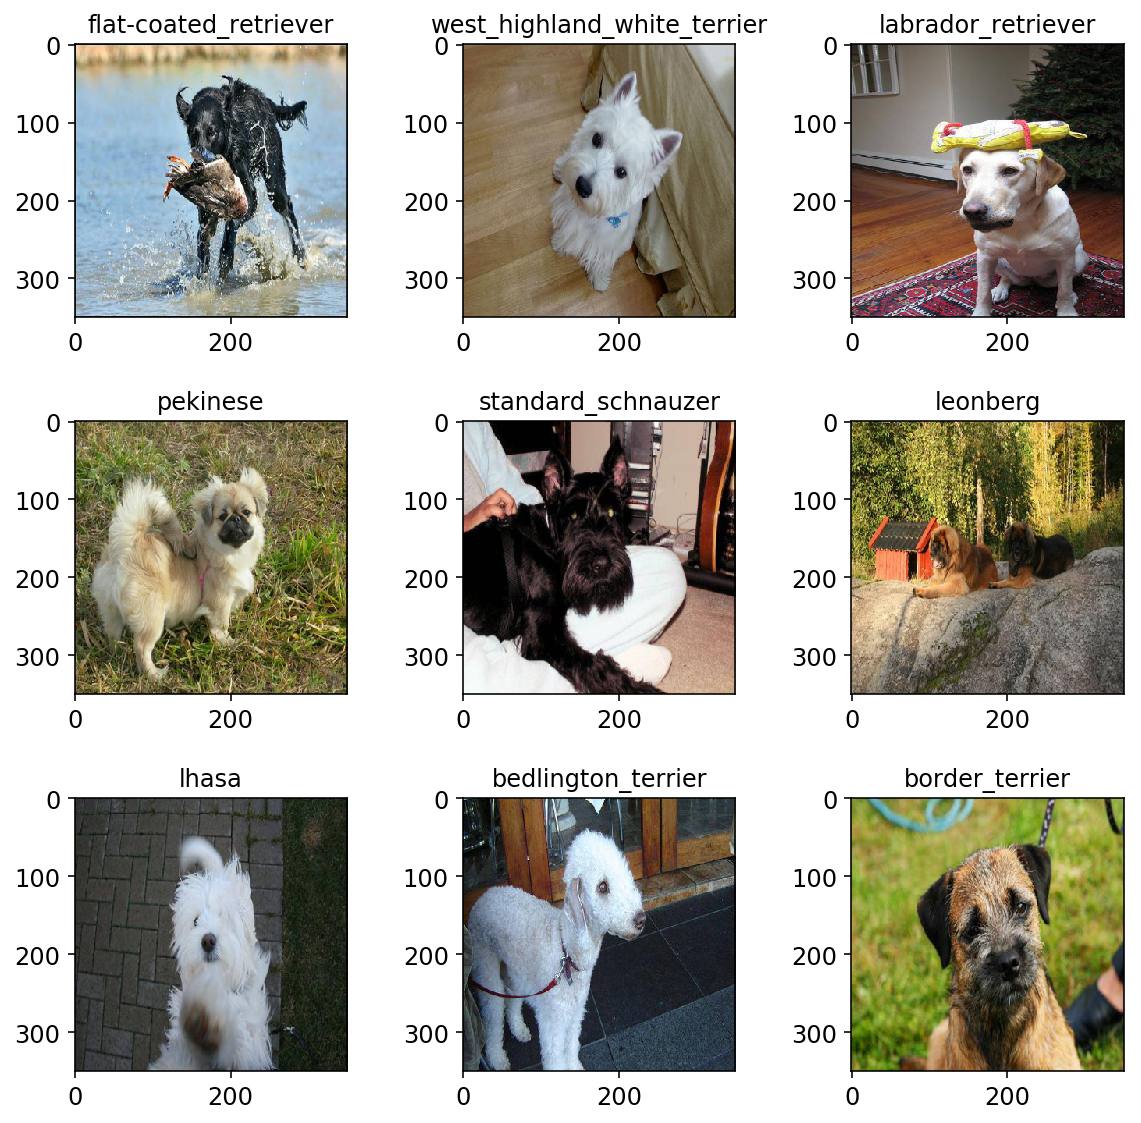

In [13]:
# To plot pretty figures
%matplotlib inline

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(8, 8))
for i in range(9):
    # randomly pick 9 train images 
    random_index = random.randint(0, y.shape[0]-1)
    plt.subplot(3, 3, i+1)
    plt.imshow(X[random_index][:,:,::-1])
    
    # get the figure number id (0 -119) then map back to the breed name
    plt.title(num_to_class[y[random_index].argmax()])

save_fig('Train Image Samples')
# good image resolution


Define a function for extracting bottleneck features

In [16]:
width = 350

def get_features(MODEL, data=X):
    # use pre-trained weights 
    cnn_model = MODEL(include_top=False, input_shape=(width, width, 3), weights='imagenet')
    
    inputs = Input((width, width, 3))
    x = inputs
    # use pre-processing unit from Inception_V3 to normalize the data
    x = Lambda(preprocess_input, name='preprocessing')(x)
    x = cnn_model(x)
    
    # use global average pooling to layer to output the features as a vector
    # if use flatten layer, the vector would be huge, 
    # and the size varies a lot for different models
    x = GlobalAveragePooling2D()(x)
    cnn_model = Model(inputs, x)

    # batch size cannot be too large, otherwise GPU RAM may not enough, 
    # causing Resource Exhausted Error
    features = cnn_model.predict(data, batch_size=32, verbose=1)
    return features

Obtain the Bottleneck Features from 6 Pre-trained Models

In [17]:
inception_features = get_features(InceptionV3, X)
xception_features = get_features(Xception, X)
res_features = get_features(ResNet50, X)
inres_features = get_features(InceptionResNetV2, X)
vgg19_features = get_features(VGG19, X)
vgg16_features = get_features(VGG16, X)

   32/30802 [..............................] - ETA: 34:21

   64/30802 [..............................] - ETA: 21:01

   96/30802 [..............................] - ETA: 16:34

  128/30802 [..............................] - ETA: 14:20

  160/30802 [..............................] - ETA: 13:00

  192/30802 [..............................] - ETA: 12:06

  224/30802 [..............................] - ETA: 11:28

  256/30802 [..............................] - ETA: 10:59

  288/30802 [..............................] - ETA: 10:36

  320/30802 [..............................] - ETA: 10:18

  352/30802 [..............................] - ETA: 10:03

  384/30802 [..............................] - ETA: 9:51 

  416/30802 [..............................] - ETA: 9:40

  448/30802 [..............................] - ETA: 9:31

  480/30802 [..............................] - ETA: 9:23

  512/30802 [..............................] - ETA: 9:16

  544/30802 [..............................] - ETA: 9:10

  576/30802 [..............................] - ETA: 9:04

  608/30802 [..............................] - ETA: 8:59

  640/30802 [..............................] - ETA: 8:54

  672/30802 [..............................] - ETA: 8:50

  704/30802 [..............................] - ETA: 8:46

  736/30802 [..............................] - ETA: 8:42

  768/30802 [..............................] - ETA: 8:39

  800/30802 [..............................] - ETA: 8:36

  832/30802 [..............................] - ETA: 8:33

  864/30802 [..............................] - ETA: 8:30

  896/30802 [..............................] - ETA: 8:27

  928/30802 [..............................] - ETA: 8:25

  960/30802 [..............................] - ETA: 8:23

  992/30802 [..............................] - ETA: 8:21

 1024/30802 [..............................] - ETA: 8:18

 1056/30802 [>.............................] - ETA: 8:16

 1088/30802 [>.............................] - ETA: 8:14

 1120/30802 [>.............................] - ETA: 8:13

 1152/30802 [>.............................] - ETA: 8:11

 1184/30802 [>.............................] - ETA: 8:09

 1216/30802 [>.............................] - ETA: 8:08

 1248/30802 [>.............................] - ETA: 8:06

 1280/30802 [>.............................] - ETA: 8:05

 1312/30802 [>.............................] - ETA: 8:03

 1344/30802 [>.............................] - ETA: 8:02

 1376/30802 [>.............................] - ETA: 8:01

 1408/30802 [>.............................] - ETA: 7:59

 1440/30802 [>.............................] - ETA: 7:58

 1472/30802 [>.............................] - ETA: 7:57

 1504/30802 [>.............................] - ETA: 7:56

 1536/30802 [>.............................] - ETA: 7:55

 1568/30802 [>.............................] - ETA: 7:54

 1600/30802 [>.............................] - ETA: 7:53

 1632/30802 [>.............................] - ETA: 7:52

 1664/30802 [>.............................] - ETA: 7:51

 1696/30802 [>.............................] - ETA: 7:49

 1728/30802 [>.............................] - ETA: 7:49

 1760/30802 [>.............................] - ETA: 7:48

 1792/30802 [>.............................] - ETA: 7:47

 1824/30802 [>.............................] - ETA: 7:46

 1856/30802 [>.............................] - ETA: 7:45

 1888/30802 [>.............................] - ETA: 7:44

 1920/30802 [>.............................] - ETA: 7:43

 1952/30802 [>.............................] - ETA: 7:42

 1984/30802 [>.............................] - ETA: 7:41

 2016/30802 [>.............................] - ETA: 7:40

 2048/30802 [>.............................] - ETA: 7:39

 2080/30802 [=>............................] - ETA: 7:38

 2112/30802 [=>............................] - ETA: 7:38

 2144/30802 [=>............................] - ETA: 7:37

 2176/30802 [=>............................] - ETA: 7:36

 2208/30802 [=>............................] - ETA: 7:35

 2240/30802 [=>............................] - ETA: 7:34

 2272/30802 [=>............................] - ETA: 7:34

 2304/30802 [=>............................] - ETA: 7:33

 2336/30802 [=>............................] - ETA: 7:32

 2368/30802 [=>............................] - ETA: 7:31

 2400/30802 [=>............................] - ETA: 7:30

 2432/30802 [=>............................] - ETA: 7:30

 2464/30802 [=>............................] - ETA: 7:29

 2496/30802 [=>............................] - ETA: 7:28

 2528/30802 [=>............................] - ETA: 7:27

 2560/30802 [=>............................] - ETA: 7:27

 2592/30802 [=>............................] - ETA: 7:26

 2624/30802 [=>............................] - ETA: 7:25

 2656/30802 [=>............................] - ETA: 7:24

 2688/30802 [=>............................] - ETA: 7:24

 2720/30802 [=>............................] - ETA: 7:23

 2752/30802 [=>............................] - ETA: 7:22

 2784/30802 [=>............................] - ETA: 7:22

 2816/30802 [=>............................] - ETA: 7:21

 2848/30802 [=>............................] - ETA: 7:20

 2880/30802 [=>............................] - ETA: 7:20

 2912/30802 [=>............................] - ETA: 7:19

 2944/30802 [=>............................] - ETA: 7:18

 2976/30802 [=>............................] - ETA: 7:17

 3008/30802 [=>............................] - ETA: 7:17

 3040/30802 [=>............................] - ETA: 7:16

 3072/30802 [=>............................] - ETA: 7:15

 3104/30802 [==>...........................] - ETA: 7:15

 3136/30802 [==>...........................] - ETA: 7:14

 3168/30802 [==>...........................] - ETA: 7:14

 3200/30802 [==>...........................] - ETA: 7:13

 3232/30802 [==>...........................] - ETA: 7:12

 3264/30802 [==>...........................] - ETA: 7:12

 3296/30802 [==>...........................] - ETA: 7:11

 3328/30802 [==>...........................] - ETA: 7:11

 3360/30802 [==>...........................] - ETA: 7:10

 3392/30802 [==>...........................] - ETA: 7:09

 3424/30802 [==>...........................] - ETA: 7:09

 3456/30802 [==>...........................] - ETA: 7:08

 3488/30802 [==>...........................] - ETA: 7:07

 3520/30802 [==>...........................] - ETA: 7:07

 3552/30802 [==>...........................] - ETA: 7:06

 3584/30802 [==>...........................] - ETA: 7:05

 3616/30802 [==>...........................] - ETA: 7:05

 3648/30802 [==>...........................] - ETA: 7:04

 3680/30802 [==>...........................] - ETA: 7:04

 3712/30802 [==>...........................] - ETA: 7:03

 3744/30802 [==>...........................] - ETA: 7:02

 3776/30802 [==>...........................] - ETA: 7:02

 3808/30802 [==>...........................] - ETA: 7:01

 3840/30802 [==>...........................] - ETA: 7:01

 3872/30802 [==>...........................] - ETA: 7:00

 3904/30802 [==>...........................] - ETA: 6:59

 3936/30802 [==>...........................] - ETA: 6:59

 3968/30802 [==>...........................] - ETA: 6:58

 4000/30802 [==>...........................] - ETA: 6:58

 4032/30802 [==>...........................] - ETA: 6:57

 4064/30802 [==>...........................] - ETA: 6:57

 4096/30802 [==>...........................] - ETA: 6:56

 4128/30802 [===>..........................] - ETA: 6:55

 4160/30802 [===>..........................] - ETA: 6:55

 4192/30802 [===>..........................] - ETA: 6:54

 4224/30802 [===>..........................] - ETA: 6:54

 4256/30802 [===>..........................] - ETA: 6:53

 4288/30802 [===>..........................] - ETA: 6:53

 4320/30802 [===>..........................] - ETA: 6:52

 4352/30802 [===>..........................] - ETA: 6:51

 4384/30802 [===>..........................] - ETA: 6:51

 4416/30802 [===>..........................] - ETA: 6:50

 4448/30802 [===>..........................] - ETA: 6:50

 4480/30802 [===>..........................] - ETA: 6:49

 4512/30802 [===>..........................] - ETA: 6:49

 4544/30802 [===>..........................] - ETA: 6:48

 4576/30802 [===>..........................] - ETA: 6:48

 4608/30802 [===>..........................] - ETA: 6:47

 4640/30802 [===>..........................] - ETA: 6:46

 4672/30802 [===>..........................] - ETA: 6:46

 4704/30802 [===>..........................] - ETA: 6:45

 4736/30802 [===>..........................] - ETA: 6:45

 4768/30802 [===>..........................] - ETA: 6:44

 4800/30802 [===>..........................] - ETA: 6:44

 4832/30802 [===>..........................] - ETA: 6:43

 4864/30802 [===>..........................] - ETA: 6:43

 4896/30802 [===>..........................] - ETA: 6:42

 4928/30802 [===>..........................] - ETA: 6:42

 4960/30802 [===>..........................] - ETA: 6:41

 4992/30802 [===>..........................] - ETA: 6:40

 5024/30802 [===>..........................] - ETA: 6:40

 5056/30802 [===>..........................] - ETA: 6:39

 5088/30802 [===>..........................] - ETA: 6:39

 5120/30802 [===>..........................] - ETA: 6:38

 5152/30802 [====>.........................] - ETA: 6:38

 5184/30802 [====>.........................] - ETA: 6:37

 5216/30802 [====>.........................] - ETA: 6:37

 5248/30802 [====>.........................] - ETA: 6:36

 5280/30802 [====>.........................] - ETA: 6:36

 5312/30802 [====>.........................] - ETA: 6:35

 5344/30802 [====>.........................] - ETA: 6:34

 5376/30802 [====>.........................] - ETA: 6:34

 5408/30802 [====>.........................] - ETA: 6:33

 5440/30802 [====>.........................] - ETA: 6:33

 5472/30802 [====>.........................] - ETA: 6:32

 5504/30802 [====>.........................] - ETA: 6:32

 5536/30802 [====>.........................] - ETA: 6:31

 5568/30802 [====>.........................] - ETA: 6:31

 5600/30802 [====>.........................] - ETA: 6:30

 5632/30802 [====>.........................] - ETA: 6:30

 5664/30802 [====>.........................] - ETA: 6:29

 5696/30802 [====>.........................] - ETA: 6:29

 5728/30802 [====>.........................] - ETA: 6:28

 5760/30802 [====>.........................] - ETA: 6:28

 5792/30802 [====>.........................] - ETA: 6:27

 5824/30802 [====>.........................] - ETA: 6:26

 5856/30802 [====>.........................] - ETA: 6:26

 5888/30802 [====>.........................] - ETA: 6:25

 5920/30802 [====>.........................] - ETA: 6:25

 5952/30802 [====>.........................] - ETA: 6:24

 5984/30802 [====>.........................] - ETA: 6:24

 6016/30802 [====>.........................] - ETA: 6:23

 6048/30802 [====>.........................] - ETA: 6:23

 6080/30802 [====>.........................] - ETA: 6:23

 6112/30802 [====>.........................] - ETA: 6:22

 6144/30802 [====>.........................] - ETA: 6:22

 6176/30802 [=====>........................] - ETA: 6:21

 6208/30802 [=====>........................] - ETA: 6:20

 6240/30802 [=====>........................] - ETA: 6:20

 6272/30802 [=====>........................] - ETA: 6:20

 6304/30802 [=====>........................] - ETA: 6:19

 6336/30802 [=====>........................] - ETA: 6:18

 6368/30802 [=====>........................] - ETA: 6:18

 6400/30802 [=====>........................] - ETA: 6:17

 6432/30802 [=====>........................] - ETA: 6:17

 6464/30802 [=====>........................] - ETA: 6:16

 6496/30802 [=====>........................] - ETA: 6:16

 6528/30802 [=====>........................] - ETA: 6:15

 6560/30802 [=====>........................] - ETA: 6:15

 6592/30802 [=====>........................] - ETA: 6:14

 6624/30802 [=====>........................] - ETA: 6:14

 6656/30802 [=====>........................] - ETA: 6:14

 6688/30802 [=====>........................] - ETA: 6:13

 6720/30802 [=====>........................] - ETA: 6:13

 6752/30802 [=====>........................] - ETA: 6:12

 6784/30802 [=====>........................] - ETA: 6:12

 6816/30802 [=====>........................] - ETA: 6:11

 6848/30802 [=====>........................] - ETA: 6:11

 6880/30802 [=====>........................] - ETA: 6:10

 6912/30802 [=====>........................] - ETA: 6:10

 6944/30802 [=====>........................] - ETA: 6:09

 6976/30802 [=====>........................] - ETA: 6:09

 7008/30802 [=====>........................] - ETA: 6:08

 7040/30802 [=====>........................] - ETA: 6:08

 7072/30802 [=====>........................] - ETA: 6:07

 7104/30802 [=====>........................] - ETA: 6:07

 7136/30802 [=====>........................] - ETA: 6:06

 7168/30802 [=====>........................] - ETA: 6:05

 7200/30802 [======>.......................] - ETA: 6:05

 7232/30802 [======>.......................] - ETA: 6:04

 7264/30802 [======>.......................] - ETA: 6:04

 7296/30802 [======>.......................] - ETA: 6:03

 7328/30802 [======>.......................] - ETA: 6:03

 7360/30802 [======>.......................] - ETA: 6:02

 7392/30802 [======>.......................] - ETA: 6:02

 7424/30802 [======>.......................] - ETA: 6:01

 7456/30802 [======>.......................] - ETA: 6:01

 7488/30802 [======>.......................] - ETA: 6:00

 7520/30802 [======>.......................] - ETA: 6:00

 7552/30802 [======>.......................] - ETA: 5:59

 7584/30802 [======>.......................] - ETA: 5:59

 7616/30802 [======>.......................] - ETA: 5:58

 7648/30802 [======>.......................] - ETA: 5:58

 7680/30802 [======>.......................] - ETA: 5:57

 7712/30802 [======>.......................] - ETA: 5:57

 7744/30802 [======>.......................] - ETA: 5:56

 7776/30802 [======>.......................] - ETA: 5:56

 7808/30802 [======>.......................] - ETA: 5:55

 7840/30802 [======>.......................] - ETA: 5:55

 7872/30802 [======>.......................] - ETA: 5:54

 7904/30802 [======>.......................] - ETA: 5:54

 7936/30802 [======>.......................] - ETA: 5:53

 7968/30802 [======>.......................] - ETA: 5:53

 8000/30802 [======>.......................] - ETA: 5:52

 8032/30802 [======>.......................] - ETA: 5:52

 8064/30802 [======>.......................] - ETA: 5:51

 8096/30802 [======>.......................] - ETA: 5:51

 8128/30802 [======>.......................] - ETA: 5:50

 8160/30802 [======>.......................] - ETA: 5:50

 8192/30802 [======>.......................] - ETA: 5:49

 8224/30802 [=======>......................] - ETA: 5:49

 8256/30802 [=======>......................] - ETA: 5:48

 8288/30802 [=======>......................] - ETA: 5:48

 8320/30802 [=======>......................] - ETA: 5:47

 8352/30802 [=======>......................] - ETA: 5:47

 8384/30802 [=======>......................] - ETA: 5:46

 8416/30802 [=======>......................] - ETA: 5:46

 8448/30802 [=======>......................] - ETA: 5:45

 8480/30802 [=======>......................] - ETA: 5:45

 8512/30802 [=======>......................] - ETA: 5:44

 8544/30802 [=======>......................] - ETA: 5:44

 8576/30802 [=======>......................] - ETA: 5:43

 8608/30802 [=======>......................] - ETA: 5:43

 8640/30802 [=======>......................] - ETA: 5:42

 8672/30802 [=======>......................] - ETA: 5:42

 8704/30802 [=======>......................] - ETA: 5:41

 8736/30802 [=======>......................] - ETA: 5:41

 8768/30802 [=======>......................] - ETA: 5:40

 8800/30802 [=======>......................] - ETA: 5:40

 8832/30802 [=======>......................] - ETA: 5:39

 8864/30802 [=======>......................] - ETA: 5:38

 8896/30802 [=======>......................] - ETA: 5:38

 8928/30802 [=======>......................] - ETA: 5:37

 8960/30802 [=======>......................] - ETA: 5:37

 8992/30802 [=======>......................] - ETA: 5:36

 9024/30802 [=======>......................] - ETA: 5:36

 9056/30802 [=======>......................] - ETA: 5:35

 9088/30802 [=======>......................] - ETA: 5:35

 9120/30802 [=======>......................] - ETA: 5:34

 9152/30802 [=======>......................] - ETA: 5:34

 9184/30802 [=======>......................] - ETA: 5:33

 9216/30802 [=======>......................] - ETA: 5:33

 9248/30802 [========>.....................] - ETA: 5:32

 9280/30802 [========>.....................] - ETA: 5:32

 9312/30802 [========>.....................] - ETA: 5:31

 9344/30802 [========>.....................] - ETA: 5:31

 9376/30802 [========>.....................] - ETA: 5:30

 9408/30802 [========>.....................] - ETA: 5:30

 9440/30802 [========>.....................] - ETA: 5:29

 9472/30802 [========>.....................] - ETA: 5:29

 9504/30802 [========>.....................] - ETA: 5:28

 9536/30802 [========>.....................] - ETA: 5:28

 9568/30802 [========>.....................] - ETA: 5:27

 9600/30802 [========>.....................] - ETA: 5:27

 9632/30802 [========>.....................] - ETA: 5:26

 9664/30802 [========>.....................] - ETA: 5:26

 9696/30802 [========>.....................] - ETA: 5:25

 9728/30802 [========>.....................] - ETA: 5:25

 9760/30802 [========>.....................] - ETA: 5:24

 9792/30802 [========>.....................] - ETA: 5:24

 9824/30802 [========>.....................] - ETA: 5:23

 9856/30802 [========>.....................] - ETA: 5:23

 9888/30802 [========>.....................] - ETA: 5:22

 9920/30802 [========>.....................] - ETA: 5:22

 9952/30802 [========>.....................] - ETA: 5:21

 9984/30802 [========>.....................] - ETA: 5:21

10016/30802 [========>.....................] - ETA: 5:20

10048/30802 [========>.....................] - ETA: 5:20

10080/30802 [========>.....................] - ETA: 5:19

10112/30802 [========>.....................] - ETA: 5:19

10144/30802 [========>.....................] - ETA: 5:18

10176/30802 [========>.....................] - ETA: 5:18

10208/30802 [========>.....................] - ETA: 5:17

10240/30802 [========>.....................] - ETA: 5:17

10272/30802 [=========>....................] - ETA: 5:16

10304/30802 [=========>....................] - ETA: 5:16

10336/30802 [=========>....................] - ETA: 5:15

10368/30802 [=========>....................] - ETA: 5:15

10400/30802 [=========>....................] - ETA: 5:14

10432/30802 [=========>....................] - ETA: 5:14

10464/30802 [=========>....................] - ETA: 5:13

10496/30802 [=========>....................] - ETA: 5:13

10528/30802 [=========>....................] - ETA: 5:12

10560/30802 [=========>....................] - ETA: 5:12

10592/30802 [=========>....................] - ETA: 5:11

10624/30802 [=========>....................] - ETA: 5:11

10656/30802 [=========>....................] - ETA: 5:10

10688/30802 [=========>....................] - ETA: 5:10

10720/30802 [=========>....................] - ETA: 5:09

10752/30802 [=========>....................] - ETA: 5:09

10784/30802 [=========>....................] - ETA: 5:08

10816/30802 [=========>....................] - ETA: 5:08

10848/30802 [=========>....................] - ETA: 5:07

10880/30802 [=========>....................] - ETA: 5:07

10912/30802 [=========>....................] - ETA: 5:06

10944/30802 [=========>....................] - ETA: 5:06

10976/30802 [=========>....................] - ETA: 5:05

11008/30802 [=========>....................] - ETA: 5:05

11040/30802 [=========>....................] - ETA: 5:04

11072/30802 [=========>....................] - ETA: 5:04

11104/30802 [=========>....................] - ETA: 5:03

11136/30802 [=========>....................] - ETA: 5:03

11168/30802 [=========>....................] - ETA: 5:02

11200/30802 [=========>....................] - ETA: 5:02

11232/30802 [=========>....................] - ETA: 5:01

11264/30802 [=========>....................] - ETA: 5:01

11296/30802 [==========>...................] - ETA: 5:00

11328/30802 [==========>...................] - ETA: 5:00

11360/30802 [==========>...................] - ETA: 4:59

11392/30802 [==========>...................] - ETA: 4:59

11424/30802 [==========>...................] - ETA: 4:58

11456/30802 [==========>...................] - ETA: 4:58

11488/30802 [==========>...................] - ETA: 4:57

11520/30802 [==========>...................] - ETA: 4:57

11552/30802 [==========>...................] - ETA: 4:56

11584/30802 [==========>...................] - ETA: 4:56

11616/30802 [==========>...................] - ETA: 4:55

11648/30802 [==========>...................] - ETA: 4:55

11680/30802 [==========>...................] - ETA: 4:54

11712/30802 [==========>...................] - ETA: 4:54

11744/30802 [==========>...................] - ETA: 4:53

11776/30802 [==========>...................] - ETA: 4:53

11808/30802 [==========>...................] - ETA: 4:52

11840/30802 [==========>...................] - ETA: 4:52

11872/30802 [==========>...................] - ETA: 4:51

11904/30802 [==========>...................] - ETA: 4:51

11936/30802 [==========>...................] - ETA: 4:50

11968/30802 [==========>...................] - ETA: 4:50

12000/30802 [==========>...................] - ETA: 4:49

12032/30802 [==========>...................] - ETA: 4:49

12064/30802 [==========>...................] - ETA: 4:48

12096/30802 [==========>...................] - ETA: 4:48

12128/30802 [==========>...................] - ETA: 4:47

12160/30802 [==========>...................] - ETA: 4:47

12192/30802 [==========>...................] - ETA: 4:46

12224/30802 [==========>...................] - ETA: 4:46

12256/30802 [==========>...................] - ETA: 4:45

12288/30802 [==========>...................] - ETA: 4:45

12320/30802 [==========>...................] - ETA: 4:44

12352/30802 [===========>..................] - ETA: 4:44

12384/30802 [===========>..................] - ETA: 4:43

12416/30802 [===========>..................] - ETA: 4:43

12448/30802 [===========>..................] - ETA: 4:42

12480/30802 [===========>..................] - ETA: 4:42

12512/30802 [===========>..................] - ETA: 4:41

12544/30802 [===========>..................] - ETA: 4:41

12576/30802 [===========>..................] - ETA: 4:40

12608/30802 [===========>..................] - ETA: 4:40

12640/30802 [===========>..................] - ETA: 4:39

12672/30802 [===========>..................] - ETA: 4:39

12704/30802 [===========>..................] - ETA: 4:38

12736/30802 [===========>..................] - ETA: 4:38

12768/30802 [===========>..................] - ETA: 4:37

12800/30802 [===========>..................] - ETA: 4:37

12832/30802 [===========>..................] - ETA: 4:36

12864/30802 [===========>..................] - ETA: 4:36

12896/30802 [===========>..................] - ETA: 4:35

12928/30802 [===========>..................] - ETA: 4:35

12960/30802 [===========>..................] - ETA: 4:34

12992/30802 [===========>..................] - ETA: 4:34

13024/30802 [===========>..................] - ETA: 4:33

13056/30802 [===========>..................] - ETA: 4:33

13088/30802 [===========>..................] - ETA: 4:32

13120/30802 [===========>..................] - ETA: 4:32

13152/30802 [===========>..................] - ETA: 4:31

13184/30802 [===========>..................] - ETA: 4:31

13216/30802 [===========>..................] - ETA: 4:30

13248/30802 [===========>..................] - ETA: 4:30

13280/30802 [===========>..................] - ETA: 4:29

13312/30802 [===========>..................] - ETA: 4:29

13344/30802 [===========>..................] - ETA: 4:28

13376/30802 [============>.................] - ETA: 4:28

13408/30802 [============>.................] - ETA: 4:27

13440/30802 [============>.................] - ETA: 4:27

13472/30802 [============>.................] - ETA: 4:27

13504/30802 [============>.................] - ETA: 4:26

13536/30802 [============>.................] - ETA: 4:26

13568/30802 [============>.................] - ETA: 4:25

13600/30802 [============>.................] - ETA: 4:25

13632/30802 [============>.................] - ETA: 4:24

13664/30802 [============>.................] - ETA: 4:24

13696/30802 [============>.................] - ETA: 4:23

13728/30802 [============>.................] - ETA: 4:23

13760/30802 [============>.................] - ETA: 4:22

13792/30802 [============>.................] - ETA: 4:22

13824/30802 [============>.................] - ETA: 4:21

13856/30802 [============>.................] - ETA: 4:21

13888/30802 [============>.................] - ETA: 4:20

13920/30802 [============>.................] - ETA: 4:20

13952/30802 [============>.................] - ETA: 4:19

13984/30802 [============>.................] - ETA: 4:19

14016/30802 [============>.................] - ETA: 4:18

14048/30802 [============>.................] - ETA: 4:18

14080/30802 [============>.................] - ETA: 4:17

14112/30802 [============>.................] - ETA: 4:17

14144/30802 [============>.................] - ETA: 4:16

14176/30802 [============>.................] - ETA: 4:16

14208/30802 [============>.................] - ETA: 4:15

14240/30802 [============>.................] - ETA: 4:15

14272/30802 [============>.................] - ETA: 4:14

14304/30802 [============>.................] - ETA: 4:14

14336/30802 [============>.................] - ETA: 4:14

14368/30802 [============>.................] - ETA: 4:13

14400/30802 [=============>................] - ETA: 4:13

14432/30802 [=============>................] - ETA: 4:12

14464/30802 [=============>................] - ETA: 4:12

14496/30802 [=============>................] - ETA: 4:11

14528/30802 [=============>................] - ETA: 4:11

14560/30802 [=============>................] - ETA: 4:10

14592/30802 [=============>................] - ETA: 4:10

14624/30802 [=============>................] - ETA: 4:09

14656/30802 [=============>................] - ETA: 4:09

14688/30802 [=============>................] - ETA: 4:08

14720/30802 [=============>................] - ETA: 4:08

14752/30802 [=============>................] - ETA: 4:07

14784/30802 [=============>................] - ETA: 4:07

14816/30802 [=============>................] - ETA: 4:06

14848/30802 [=============>................] - ETA: 4:06

14880/30802 [=============>................] - ETA: 4:05

14912/30802 [=============>................] - ETA: 4:05

14944/30802 [=============>................] - ETA: 4:04

14976/30802 [=============>................] - ETA: 4:04

15008/30802 [=============>................] - ETA: 4:03

15040/30802 [=============>................] - ETA: 4:03

15072/30802 [=============>................] - ETA: 4:02

15104/30802 [=============>................] - ETA: 4:02

15136/30802 [=============>................] - ETA: 4:01

15168/30802 [=============>................] - ETA: 4:01

15200/30802 [=============>................] - ETA: 4:00

15232/30802 [=============>................] - ETA: 4:00

15264/30802 [=============>................] - ETA: 3:59

15296/30802 [=============>................] - ETA: 3:59

15328/30802 [=============>................] - ETA: 3:58

15360/30802 [=============>................] - ETA: 3:58

15392/30802 [=============>................] - ETA: 3:57

15424/30802 [==============>...............] - ETA: 3:57

15456/30802 [==============>...............] - ETA: 3:56

15488/30802 [==============>...............] - ETA: 3:56

15520/30802 [==============>...............] - ETA: 3:55

15552/30802 [==============>...............] - ETA: 3:55

15584/30802 [==============>...............] - ETA: 3:54

15616/30802 [==============>...............] - ETA: 3:54

15648/30802 [==============>...............] - ETA: 3:53

15680/30802 [==============>...............] - ETA: 3:53

15712/30802 [==============>...............] - ETA: 3:52

15744/30802 [==============>...............] - ETA: 3:52

15776/30802 [==============>...............] - ETA: 3:51

15808/30802 [==============>...............] - ETA: 3:51

15840/30802 [==============>...............] - ETA: 3:51

15872/30802 [==============>...............] - ETA: 3:50

15904/30802 [==============>...............] - ETA: 3:50

15936/30802 [==============>...............] - ETA: 3:49

15968/30802 [==============>...............] - ETA: 3:49

16000/30802 [==============>...............] - ETA: 3:48

16032/30802 [==============>...............] - ETA: 3:48

16064/30802 [==============>...............] - ETA: 3:47

16096/30802 [==============>...............] - ETA: 3:47

16128/30802 [==============>...............] - ETA: 3:46

16160/30802 [==============>...............] - ETA: 3:46

16192/30802 [==============>...............] - ETA: 3:45

16224/30802 [==============>...............] - ETA: 3:45

16256/30802 [==============>...............] - ETA: 3:44

16288/30802 [==============>...............] - ETA: 3:44

16320/30802 [==============>...............] - ETA: 3:43

16352/30802 [==============>...............] - ETA: 3:43

16384/30802 [==============>...............] - ETA: 3:42

16416/30802 [==============>...............] - ETA: 3:42

16448/30802 [===============>..............] - ETA: 3:41

16480/30802 [===============>..............] - ETA: 3:41

16512/30802 [===============>..............] - ETA: 3:40

16544/30802 [===============>..............] - ETA: 3:40

16576/30802 [===============>..............] - ETA: 3:39

16608/30802 [===============>..............] - ETA: 3:39

16640/30802 [===============>..............] - ETA: 3:38

16672/30802 [===============>..............] - ETA: 3:38

16704/30802 [===============>..............] - ETA: 3:37

16736/30802 [===============>..............] - ETA: 3:37

16768/30802 [===============>..............] - ETA: 3:36

16800/30802 [===============>..............] - ETA: 3:36

16832/30802 [===============>..............] - ETA: 3:35

16864/30802 [===============>..............] - ETA: 3:35

16896/30802 [===============>..............] - ETA: 3:34

16928/30802 [===============>..............] - ETA: 3:34

16960/30802 [===============>..............] - ETA: 3:33

16992/30802 [===============>..............] - ETA: 3:33

17024/30802 [===============>..............] - ETA: 3:32

17056/30802 [===============>..............] - ETA: 3:32

17088/30802 [===============>..............] - ETA: 3:31

17120/30802 [===============>..............] - ETA: 3:31

17152/30802 [===============>..............] - ETA: 3:30

17184/30802 [===============>..............] - ETA: 3:30

17216/30802 [===============>..............] - ETA: 3:29

17248/30802 [===============>..............] - ETA: 3:29

17280/30802 [===============>..............] - ETA: 3:28

17312/30802 [===============>..............] - ETA: 3:28

17344/30802 [===============>..............] - ETA: 3:27

17376/30802 [===============>..............] - ETA: 3:27

17408/30802 [===============>..............] - ETA: 3:26

17440/30802 [===============>..............] - ETA: 3:26

17472/30802 [================>.............] - ETA: 3:25

17504/30802 [================>.............] - ETA: 3:25

17536/30802 [================>.............] - ETA: 3:24

17568/30802 [================>.............] - ETA: 3:24

17600/30802 [================>.............] - ETA: 3:23

17632/30802 [================>.............] - ETA: 3:23

17664/30802 [================>.............] - ETA: 3:22

17696/30802 [================>.............] - ETA: 3:22

17728/30802 [================>.............] - ETA: 3:21

17760/30802 [================>.............] - ETA: 3:21

17792/30802 [================>.............] - ETA: 3:20

17824/30802 [================>.............] - ETA: 3:20

17856/30802 [================>.............] - ETA: 3:19

17888/30802 [================>.............] - ETA: 3:19

17920/30802 [================>.............] - ETA: 3:18

17952/30802 [================>.............] - ETA: 3:18

17984/30802 [================>.............] - ETA: 3:17

18016/30802 [================>.............] - ETA: 3:17

18048/30802 [================>.............] - ETA: 3:16

18080/30802 [================>.............] - ETA: 3:16

18112/30802 [================>.............] - ETA: 3:15

18144/30802 [================>.............] - ETA: 3:15

18176/30802 [================>.............] - ETA: 3:14

18208/30802 [================>.............] - ETA: 3:14

18240/30802 [================>.............] - ETA: 3:13

18272/30802 [================>.............] - ETA: 3:13

18304/30802 [================>.............] - ETA: 3:12

18336/30802 [================>.............] - ETA: 3:12

18368/30802 [================>.............] - ETA: 3:11

18400/30802 [================>.............] - ETA: 3:11

18432/30802 [================>.............] - ETA: 3:10

18464/30802 [================>.............] - ETA: 3:10

18496/30802 [=================>............] - ETA: 3:09

18528/30802 [=================>............] - ETA: 3:09

18560/30802 [=================>............] - ETA: 3:08

18592/30802 [=================>............] - ETA: 3:08

18624/30802 [=================>............] - ETA: 3:07

18656/30802 [=================>............] - ETA: 3:07

18688/30802 [=================>............] - ETA: 3:06

18720/30802 [=================>............] - ETA: 3:06

18752/30802 [=================>............] - ETA: 3:05

18784/30802 [=================>............] - ETA: 3:05

18816/30802 [=================>............] - ETA: 3:04

18848/30802 [=================>............] - ETA: 3:04

18880/30802 [=================>............] - ETA: 3:03

18912/30802 [=================>............] - ETA: 3:03

18944/30802 [=================>............] - ETA: 3:02

18976/30802 [=================>............] - ETA: 3:02

19008/30802 [=================>............] - ETA: 3:01

19040/30802 [=================>............] - ETA: 3:01

19072/30802 [=================>............] - ETA: 3:00

19104/30802 [=================>............] - ETA: 3:00

19136/30802 [=================>............] - ETA: 2:59

19168/30802 [=================>............] - ETA: 2:59

19200/30802 [=================>............] - ETA: 2:58

19232/30802 [=================>............] - ETA: 2:58

19264/30802 [=================>............] - ETA: 2:57

19296/30802 [=================>............] - ETA: 2:57

19328/30802 [=================>............] - ETA: 2:56

19360/30802 [=================>............] - ETA: 2:56

19392/30802 [=================>............] - ETA: 2:55

19424/30802 [=================>............] - ETA: 2:55

19456/30802 [=================>............] - ETA: 2:54

19488/30802 [=================>............] - ETA: 2:54

19520/30802 [==================>...........] - ETA: 2:53

19552/30802 [==================>...........] - ETA: 2:53

19584/30802 [==================>...........] - ETA: 2:52

19616/30802 [==================>...........] - ETA: 2:52

19648/30802 [==================>...........] - ETA: 2:51

19680/30802 [==================>...........] - ETA: 2:51

19712/30802 [==================>...........] - ETA: 2:50

19744/30802 [==================>...........] - ETA: 2:50

19776/30802 [==================>...........] - ETA: 2:49

19808/30802 [==================>...........] - ETA: 2:49

19840/30802 [==================>...........] - ETA: 2:49

19872/30802 [==================>...........] - ETA: 2:48

19904/30802 [==================>...........] - ETA: 2:48

19936/30802 [==================>...........] - ETA: 2:47

19968/30802 [==================>...........] - ETA: 2:47

20000/30802 [==================>...........] - ETA: 2:46

20032/30802 [==================>...........] - ETA: 2:46

20064/30802 [==================>...........] - ETA: 2:45

20096/30802 [==================>...........] - ETA: 2:45

20128/30802 [==================>...........] - ETA: 2:44

20160/30802 [==================>...........] - ETA: 2:44

20192/30802 [==================>...........] - ETA: 2:43

20224/30802 [==================>...........] - ETA: 2:43

20256/30802 [==================>...........] - ETA: 2:42

20288/30802 [==================>...........] - ETA: 2:42

20320/30802 [==================>...........] - ETA: 2:41

20352/30802 [==================>...........] - ETA: 2:41

20384/30802 [==================>...........] - ETA: 2:40

20416/30802 [==================>...........] - ETA: 2:40

20448/30802 [==================>...........] - ETA: 2:39

20480/30802 [==================>...........] - ETA: 2:39

20512/30802 [==================>...........] - ETA: 2:38

20544/30802 [===================>..........] - ETA: 2:38

20576/30802 [===================>..........] - ETA: 2:37

20608/30802 [===================>..........] - ETA: 2:37

20640/30802 [===================>..........] - ETA: 2:36

20672/30802 [===================>..........] - ETA: 2:36

20704/30802 [===================>..........] - ETA: 2:35

20736/30802 [===================>..........] - ETA: 2:35

20768/30802 [===================>..........] - ETA: 2:34

20800/30802 [===================>..........] - ETA: 2:34

20832/30802 [===================>..........] - ETA: 2:33

20864/30802 [===================>..........] - ETA: 2:33

20896/30802 [===================>..........] - ETA: 2:32

20928/30802 [===================>..........] - ETA: 2:32

20960/30802 [===================>..........] - ETA: 2:31

20992/30802 [===================>..........] - ETA: 2:31

21024/30802 [===================>..........] - ETA: 2:30

21056/30802 [===================>..........] - ETA: 2:30

21088/30802 [===================>..........] - ETA: 2:29

21120/30802 [===================>..........] - ETA: 2:29

21152/30802 [===================>..........] - ETA: 2:28

21184/30802 [===================>..........] - ETA: 2:28

21216/30802 [===================>..........] - ETA: 2:27

21248/30802 [===================>..........] - ETA: 2:27

21280/30802 [===================>..........] - ETA: 2:26

21312/30802 [===================>..........] - ETA: 2:26

21344/30802 [===================>..........] - ETA: 2:25

21376/30802 [===================>..........] - ETA: 2:25

21408/30802 [===================>..........] - ETA: 2:24

21440/30802 [===================>..........] - ETA: 2:24

21472/30802 [===================>..........] - ETA: 2:23

21504/30802 [===================>..........] - ETA: 2:23

21536/30802 [===================>..........] - ETA: 2:22

21568/30802 [====================>.........] - ETA: 2:22

21600/30802 [====================>.........] - ETA: 2:21

21632/30802 [====================>.........] - ETA: 2:21

21664/30802 [====================>.........] - ETA: 2:20

21696/30802 [====================>.........] - ETA: 2:20

21728/30802 [====================>.........] - ETA: 2:19

21760/30802 [====================>.........] - ETA: 2:19

21792/30802 [====================>.........] - ETA: 2:18

21824/30802 [====================>.........] - ETA: 2:18

21856/30802 [====================>.........] - ETA: 2:17

21888/30802 [====================>.........] - ETA: 2:17

21920/30802 [====================>.........] - ETA: 2:16

21952/30802 [====================>.........] - ETA: 2:16

21984/30802 [====================>.........] - ETA: 2:15

22016/30802 [====================>.........] - ETA: 2:15

22048/30802 [====================>.........] - ETA: 2:14

22080/30802 [====================>.........] - ETA: 2:14

22112/30802 [====================>.........] - ETA: 2:13

22144/30802 [====================>.........] - ETA: 2:13

22176/30802 [====================>.........] - ETA: 2:12

22208/30802 [====================>.........] - ETA: 2:12

22240/30802 [====================>.........] - ETA: 2:11

22272/30802 [====================>.........] - ETA: 2:11

22304/30802 [====================>.........] - ETA: 2:10

22336/30802 [====================>.........] - ETA: 2:10

22368/30802 [====================>.........] - ETA: 2:09

22400/30802 [====================>.........] - ETA: 2:09

22432/30802 [====================>.........] - ETA: 2:08

22464/30802 [====================>.........] - ETA: 2:08

22496/30802 [====================>.........] - ETA: 2:07

22528/30802 [====================>.........] - ETA: 2:07

22560/30802 [====================>.........] - ETA: 2:06

22592/30802 [=====================>........] - ETA: 2:06

22624/30802 [=====================>........] - ETA: 2:05

22656/30802 [=====================>........] - ETA: 2:05

22688/30802 [=====================>........] - ETA: 2:04

22720/30802 [=====================>........] - ETA: 2:04

22752/30802 [=====================>........] - ETA: 2:04

22784/30802 [=====================>........] - ETA: 2:03

22816/30802 [=====================>........] - ETA: 2:03

22848/30802 [=====================>........] - ETA: 2:02

22880/30802 [=====================>........] - ETA: 2:02

22912/30802 [=====================>........] - ETA: 2:01

22944/30802 [=====================>........] - ETA: 2:01

22976/30802 [=====================>........] - ETA: 2:00

23008/30802 [=====================>........] - ETA: 2:00

23040/30802 [=====================>........] - ETA: 1:59

23072/30802 [=====================>........] - ETA: 1:59

23104/30802 [=====================>........] - ETA: 1:58

23136/30802 [=====================>........] - ETA: 1:58

23168/30802 [=====================>........] - ETA: 1:57

23200/30802 [=====================>........] - ETA: 1:57

23232/30802 [=====================>........] - ETA: 1:56

23264/30802 [=====================>........] - ETA: 1:56

23296/30802 [=====================>........] - ETA: 1:55

23328/30802 [=====================>........] - ETA: 1:55

23360/30802 [=====================>........] - ETA: 1:54

23392/30802 [=====================>........] - ETA: 1:54

23424/30802 [=====================>........] - ETA: 1:53

23456/30802 [=====================>........] - ETA: 1:53

23488/30802 [=====================>........] - ETA: 1:52

23520/30802 [=====================>........] - ETA: 1:52

23552/30802 [=====================>........] - ETA: 1:51

23584/30802 [=====================>........] - ETA: 1:51

23616/30802 [======================>.......] - ETA: 1:50

23648/30802 [======================>.......] - ETA: 1:50

23680/30802 [======================>.......] - ETA: 1:49

23712/30802 [======================>.......] - ETA: 1:49

23744/30802 [======================>.......] - ETA: 1:48

23776/30802 [======================>.......] - ETA: 1:48

23808/30802 [======================>.......] - ETA: 1:47

23840/30802 [======================>.......] - ETA: 1:47

23872/30802 [======================>.......] - ETA: 1:46

23904/30802 [======================>.......] - ETA: 1:46

23936/30802 [======================>.......] - ETA: 1:45

23968/30802 [======================>.......] - ETA: 1:45

24000/30802 [======================>.......] - ETA: 1:44

24032/30802 [======================>.......] - ETA: 1:44

24064/30802 [======================>.......] - ETA: 1:43

24096/30802 [======================>.......] - ETA: 1:43

24128/30802 [======================>.......] - ETA: 1:42

24160/30802 [======================>.......] - ETA: 1:42

24192/30802 [======================>.......] - ETA: 1:41

24224/30802 [======================>.......] - ETA: 1:41

24256/30802 [======================>.......] - ETA: 1:40

24288/30802 [======================>.......] - ETA: 1:40

24320/30802 [======================>.......] - ETA: 1:39

24352/30802 [======================>.......] - ETA: 1:39

24384/30802 [======================>.......] - ETA: 1:38

24416/30802 [======================>.......] - ETA: 1:38

24448/30802 [======================>.......] - ETA: 1:37

24480/30802 [======================>.......] - ETA: 1:37

24512/30802 [======================>.......] - ETA: 1:36

24544/30802 [======================>.......] - ETA: 1:36

24576/30802 [======================>.......] - ETA: 1:35

24608/30802 [======================>.......] - ETA: 1:35

24640/30802 [======================>.......] - ETA: 1:34

24672/30802 [=======================>......] - ETA: 1:34

24704/30802 [=======================>......] - ETA: 1:33

24736/30802 [=======================>......] - ETA: 1:33

24768/30802 [=======================>......] - ETA: 1:32

24800/30802 [=======================>......] - ETA: 1:32

24832/30802 [=======================>......] - ETA: 1:31

24864/30802 [=======================>......] - ETA: 1:31

24896/30802 [=======================>......] - ETA: 1:30

24928/30802 [=======================>......] - ETA: 1:30

24960/30802 [=======================>......] - ETA: 1:29

24992/30802 [=======================>......] - ETA: 1:29

25024/30802 [=======================>......] - ETA: 1:28

25056/30802 [=======================>......] - ETA: 1:28

25088/30802 [=======================>......] - ETA: 1:28

25120/30802 [=======================>......] - ETA: 1:27

25152/30802 [=======================>......] - ETA: 1:27

25184/30802 [=======================>......] - ETA: 1:26

25216/30802 [=======================>......] - ETA: 1:26

25248/30802 [=======================>......] - ETA: 1:25

25280/30802 [=======================>......] - ETA: 1:25

25312/30802 [=======================>......] - ETA: 1:24

25344/30802 [=======================>......] - ETA: 1:24

25376/30802 [=======================>......] - ETA: 1:23

25408/30802 [=======================>......] - ETA: 1:23

25440/30802 [=======================>......] - ETA: 1:22

25472/30802 [=======================>......] - ETA: 1:22

25504/30802 [=======================>......] - ETA: 1:21

25536/30802 [=======================>......] - ETA: 1:21

25568/30802 [=======================>......] - ETA: 1:20

25600/30802 [=======================>......] - ETA: 1:20

25632/30802 [=======================>......] - ETA: 1:19

25664/30802 [=======================>......] - ETA: 1:19

25696/30802 [========================>.....] - ETA: 1:18

25728/30802 [========================>.....] - ETA: 1:18

25760/30802 [========================>.....] - ETA: 1:17

25792/30802 [========================>.....] - ETA: 1:17

25824/30802 [========================>.....] - ETA: 1:16

25856/30802 [========================>.....] - ETA: 1:16

25888/30802 [========================>.....] - ETA: 1:15

25920/30802 [========================>.....] - ETA: 1:15

25952/30802 [========================>.....] - ETA: 1:14

25984/30802 [========================>.....] - ETA: 1:14

26016/30802 [========================>.....] - ETA: 1:13

26048/30802 [========================>.....] - ETA: 1:13

26080/30802 [========================>.....] - ETA: 1:12

26112/30802 [========================>.....] - ETA: 1:12

26144/30802 [========================>.....] - ETA: 1:11

26176/30802 [========================>.....] - ETA: 1:11

26208/30802 [========================>.....] - ETA: 1:10

26240/30802 [========================>.....] - ETA: 1:10

26272/30802 [========================>.....] - ETA: 1:09

26304/30802 [========================>.....] - ETA: 1:09

26336/30802 [========================>.....] - ETA: 1:08

26368/30802 [========================>.....] - ETA: 1:08

26400/30802 [========================>.....] - ETA: 1:07

26432/30802 [========================>.....] - ETA: 1:07

26464/30802 [========================>.....] - ETA: 1:06

26496/30802 [========================>.....] - ETA: 1:06

26528/30802 [========================>.....] - ETA: 1:05

26560/30802 [========================>.....] - ETA: 1:05

26592/30802 [========================>.....] - ETA: 1:04

26624/30802 [========================>.....] - ETA: 1:04

26656/30802 [========================>.....] - ETA: 1:03

26688/30802 [========================>.....] - ETA: 1:03

26720/30802 [=========================>....] - ETA: 1:02

26752/30802 [=========================>....] - ETA: 1:02

26784/30802 [=========================>....] - ETA: 1:01

26816/30802 [=========================>....] - ETA: 1:01

26848/30802 [=========================>....] - ETA: 1:00

26880/30802 [=========================>....] - ETA: 1:00

26912/30802 [=========================>....] - ETA: 59s 

26944/30802 [=========================>....] - ETA: 59s

26976/30802 [=========================>....] - ETA: 58s

27008/30802 [=========================>....] - ETA: 58s

27040/30802 [=========================>....] - ETA: 57s

27072/30802 [=========================>....] - ETA: 57s

27104/30802 [=========================>....] - ETA: 56s

27136/30802 [=========================>....] - ETA: 56s

27168/30802 [=========================>....] - ETA: 55s

27200/30802 [=========================>....] - ETA: 55s

27232/30802 [=========================>....] - ETA: 54s

27264/30802 [=========================>....] - ETA: 54s

27296/30802 [=========================>....] - ETA: 53s

27328/30802 [=========================>....] - ETA: 53s

27360/30802 [=========================>....] - ETA: 52s

27392/30802 [=========================>....] - ETA: 52s

27424/30802 [=========================>....] - ETA: 52s

27456/30802 [=========================>....] - ETA: 51s

27488/30802 [=========================>....] - ETA: 51s

27520/30802 [=========================>....] - ETA: 50s

27552/30802 [=========================>....] - ETA: 50s

27584/30802 [=========================>....] - ETA: 49s

27616/30802 [=========================>....] - ETA: 49s

27648/30802 [=========================>....] - ETA: 48s

27680/30802 [=========================>....] - ETA: 48s

27712/30802 [=========================>....] - ETA: 47s

27744/30802 [==========================>...] - ETA: 47s

27776/30802 [==========================>...] - ETA: 46s

27808/30802 [==========================>...] - ETA: 46s

27840/30802 [==========================>...] - ETA: 45s

27872/30802 [==========================>...] - ETA: 45s

27904/30802 [==========================>...] - ETA: 44s

27936/30802 [==========================>...] - ETA: 44s

27968/30802 [==========================>...] - ETA: 43s

28000/30802 [==========================>...] - ETA: 43s

28032/30802 [==========================>...] - ETA: 42s

28064/30802 [==========================>...] - ETA: 42s

28096/30802 [==========================>...] - ETA: 41s

28128/30802 [==========================>...] - ETA: 41s

28160/30802 [==========================>...] - ETA: 40s

28192/30802 [==========================>...] - ETA: 40s

28224/30802 [==========================>...] - ETA: 39s

28256/30802 [==========================>...] - ETA: 39s

28288/30802 [==========================>...] - ETA: 38s

28320/30802 [==========================>...] - ETA: 38s

28352/30802 [==========================>...] - ETA: 37s

28384/30802 [==========================>...] - ETA: 37s

28416/30802 [==========================>...] - ETA: 36s

28448/30802 [==========================>...] - ETA: 36s

28480/30802 [==========================>...] - ETA: 35s

28512/30802 [==========================>...] - ETA: 35s

28544/30802 [==========================>...] - ETA: 34s

28576/30802 [==========================>...] - ETA: 34s

28608/30802 [==========================>...] - ETA: 33s

28640/30802 [==========================>...] - ETA: 33s

28672/30802 [==========================>...] - ETA: 32s

28704/30802 [==========================>...] - ETA: 32s

28736/30802 [==========================>...] - ETA: 31s

28768/30802 [===========================>..] - ETA: 31s

28800/30802 [===========================>..] - ETA: 30s

28832/30802 [===========================>..] - ETA: 30s

28864/30802 [===========================>..] - ETA: 29s

28896/30802 [===========================>..] - ETA: 29s

28928/30802 [===========================>..] - ETA: 28s

28960/30802 [===========================>..] - ETA: 28s

28992/30802 [===========================>..] - ETA: 27s

29024/30802 [===========================>..] - ETA: 27s

29056/30802 [===========================>..] - ETA: 26s

29088/30802 [===========================>..] - ETA: 26s

29120/30802 [===========================>..] - ETA: 25s

29152/30802 [===========================>..] - ETA: 25s

29184/30802 [===========================>..] - ETA: 24s

29216/30802 [===========================>..] - ETA: 24s

29248/30802 [===========================>..] - ETA: 23s

29280/30802 [===========================>..] - ETA: 23s

29312/30802 [===========================>..] - ETA: 22s

29344/30802 [===========================>..] - ETA: 22s

29376/30802 [===========================>..] - ETA: 21s

29408/30802 [===========================>..] - ETA: 21s

29440/30802 [===========================>..] - ETA: 20s

29472/30802 [===========================>..] - ETA: 20s

29504/30802 [===========================>..] - ETA: 19s

29536/30802 [===========================>..] - ETA: 19s

29568/30802 [===========================>..] - ETA: 18s

29600/30802 [===========================>..] - ETA: 18s

29632/30802 [===========================>..] - ETA: 18s

29664/30802 [===========================>..] - ETA: 17s

29696/30802 [===========================>..] - ETA: 17s

29728/30802 [===========================>..] - ETA: 16s

29760/30802 [===========================>..] - ETA: 16s

29792/30802 [============================>.] - ETA: 15s

29824/30802 [============================>.] - ETA: 15s

29856/30802 [============================>.] - ETA: 14s

29888/30802 [============================>.] - ETA: 14s

29920/30802 [============================>.] - ETA: 13s

29952/30802 [============================>.] - ETA: 13s

29984/30802 [============================>.] - ETA: 12s

30016/30802 [============================>.] - ETA: 12s

30048/30802 [============================>.] - ETA: 11s

30080/30802 [============================>.] - ETA: 11s

30112/30802 [============================>.] - ETA: 10s

30144/30802 [============================>.] - ETA: 10s

30176/30802 [============================>.] - ETA: 9s 

30208/30802 [============================>.] - ETA: 9s

30240/30802 [============================>.] - ETA: 8s

30272/30802 [============================>.] - ETA: 8s

30304/30802 [============================>.] - ETA: 7s

30336/30802 [============================>.] - ETA: 7s

30368/30802 [============================>.] - ETA: 6s

30400/30802 [============================>.] - ETA: 6s

30432/30802 [============================>.] - ETA: 5s

30464/30802 [============================>.] - ETA: 5s

30496/30802 [============================>.] - ETA: 4s

30528/30802 [============================>.] - ETA: 4s

30560/30802 [============================>.] - ETA: 3s

30592/30802 [============================>.] - ETA: 3s

30624/30802 [============================>.] - ETA: 2s

30656/30802 [============================>.] - ETA: 2s

30688/30802 [============================>.] - ETA: 1s

30720/30802 [============================>.] - ETA: 1s

30752/30802 [============================>.] - ETA: 0s

30784/30802 [============================>.] - ETA: 0s

30802/30802 [==============================] - 475s 15ms/step


   32/30802 [..............................] - ETA: 7:21

   64/30802 [..............................] - ETA: 7:04

   96/30802 [..............................] - ETA: 7:00

  128/30802 [..............................] - ETA: 6:56

  160/30802 [..............................] - ETA: 6:55

  192/30802 [..............................] - ETA: 6:53

  224/30802 [..............................] - ETA: 6:52

  256/30802 [..............................] - ETA: 6:51

  288/30802 [..............................] - ETA: 6:52

  320/30802 [..............................] - ETA: 6:51

  352/30802 [..............................] - ETA: 6:52

  384/30802 [..............................] - ETA: 6:51

  416/30802 [..............................] - ETA: 6:50

  448/30802 [..............................] - ETA: 6:49

  480/30802 [..............................] - ETA: 6:49

  512/30802 [..............................] - ETA: 6:49

  544/30802 [..............................] - ETA: 6:48

  576/30802 [..............................] - ETA: 6:47

  608/30802 [..............................] - ETA: 6:46

  640/30802 [..............................] - ETA: 6:45

  672/30802 [..............................] - ETA: 6:45

  704/30802 [..............................] - ETA: 6:44

  736/30802 [..............................] - ETA: 6:44

  768/30802 [..............................] - ETA: 6:43

  800/30802 [..............................] - ETA: 6:42

  832/30802 [..............................] - ETA: 6:42

  864/30802 [..............................] - ETA: 6:42

  896/30802 [..............................] - ETA: 6:43

  928/30802 [..............................] - ETA: 6:43

  960/30802 [..............................] - ETA: 6:43

  992/30802 [..............................] - ETA: 6:43

 1024/30802 [..............................] - ETA: 6:42

 1056/30802 [>.............................] - ETA: 6:42

 1088/30802 [>.............................] - ETA: 6:42

 1120/30802 [>.............................] - ETA: 6:41

 1152/30802 [>.............................] - ETA: 6:40

 1184/30802 [>.............................] - ETA: 6:40

 1216/30802 [>.............................] - ETA: 6:39

 1248/30802 [>.............................] - ETA: 6:38

 1280/30802 [>.............................] - ETA: 6:38

 1312/30802 [>.............................] - ETA: 6:37

 1344/30802 [>.............................] - ETA: 6:36

 1376/30802 [>.............................] - ETA: 6:36

 1408/30802 [>.............................] - ETA: 6:35

 1440/30802 [>.............................] - ETA: 6:35

 1472/30802 [>.............................] - ETA: 6:34

 1504/30802 [>.............................] - ETA: 6:34

 1536/30802 [>.............................] - ETA: 6:33

 1568/30802 [>.............................] - ETA: 6:33

 1600/30802 [>.............................] - ETA: 6:32

 1632/30802 [>.............................] - ETA: 6:32

 1664/30802 [>.............................] - ETA: 6:31

 1696/30802 [>.............................] - ETA: 6:31

 1728/30802 [>.............................] - ETA: 6:30

 1760/30802 [>.............................] - ETA: 6:30

 1792/30802 [>.............................] - ETA: 6:29

 1824/30802 [>.............................] - ETA: 6:28

 1856/30802 [>.............................] - ETA: 6:28

 1888/30802 [>.............................] - ETA: 6:28

 1920/30802 [>.............................] - ETA: 6:27

 1952/30802 [>.............................] - ETA: 6:27

 1984/30802 [>.............................] - ETA: 6:26

 2016/30802 [>.............................] - ETA: 6:26

 2048/30802 [>.............................] - ETA: 6:26

 2080/30802 [=>............................] - ETA: 6:25

 2112/30802 [=>............................] - ETA: 6:25

 2144/30802 [=>............................] - ETA: 6:24

 2176/30802 [=>............................] - ETA: 6:24

 2208/30802 [=>............................] - ETA: 6:23

 2240/30802 [=>............................] - ETA: 6:23

 2272/30802 [=>............................] - ETA: 6:23

 2304/30802 [=>............................] - ETA: 6:23

 2336/30802 [=>............................] - ETA: 6:22

 2368/30802 [=>............................] - ETA: 6:22

 2400/30802 [=>............................] - ETA: 6:22

 2432/30802 [=>............................] - ETA: 6:22

 2464/30802 [=>............................] - ETA: 6:22

 2496/30802 [=>............................] - ETA: 6:22

 2528/30802 [=>............................] - ETA: 6:22

 2560/30802 [=>............................] - ETA: 6:21

 2592/30802 [=>............................] - ETA: 6:21

 2624/30802 [=>............................] - ETA: 6:21

 2656/30802 [=>............................] - ETA: 6:20

 2688/30802 [=>............................] - ETA: 6:20

 2720/30802 [=>............................] - ETA: 6:19

 2752/30802 [=>............................] - ETA: 6:19

 2784/30802 [=>............................] - ETA: 6:18

 2816/30802 [=>............................] - ETA: 6:18

 2848/30802 [=>............................] - ETA: 6:17

 2880/30802 [=>............................] - ETA: 6:17

 2912/30802 [=>............................] - ETA: 6:16

 2944/30802 [=>............................] - ETA: 6:16

 2976/30802 [=>............................] - ETA: 6:15

 3008/30802 [=>............................] - ETA: 6:15

 3040/30802 [=>............................] - ETA: 6:14

 3072/30802 [=>............................] - ETA: 6:13

 3104/30802 [==>...........................] - ETA: 6:13

 3136/30802 [==>...........................] - ETA: 6:12

 3168/30802 [==>...........................] - ETA: 6:12

 3200/30802 [==>...........................] - ETA: 6:11

 3232/30802 [==>...........................] - ETA: 6:11

 3264/30802 [==>...........................] - ETA: 6:10

 3296/30802 [==>...........................] - ETA: 6:10

 3328/30802 [==>...........................] - ETA: 6:10

 3360/30802 [==>...........................] - ETA: 6:10

 3392/30802 [==>...........................] - ETA: 6:10

 3424/30802 [==>...........................] - ETA: 6:09

 3456/30802 [==>...........................] - ETA: 6:09

 3488/30802 [==>...........................] - ETA: 6:09

 3520/30802 [==>...........................] - ETA: 6:08

 3552/30802 [==>...........................] - ETA: 6:08

 3584/30802 [==>...........................] - ETA: 6:07

 3616/30802 [==>...........................] - ETA: 6:07

 3648/30802 [==>...........................] - ETA: 6:06

 3680/30802 [==>...........................] - ETA: 6:06

 3712/30802 [==>...........................] - ETA: 6:05

 3744/30802 [==>...........................] - ETA: 6:05

 3776/30802 [==>...........................] - ETA: 6:05

 3808/30802 [==>...........................] - ETA: 6:04

 3840/30802 [==>...........................] - ETA: 6:04

 3872/30802 [==>...........................] - ETA: 6:04

 3904/30802 [==>...........................] - ETA: 6:03

 3936/30802 [==>...........................] - ETA: 6:03

 3968/30802 [==>...........................] - ETA: 6:03

 4000/30802 [==>...........................] - ETA: 6:03

 4032/30802 [==>...........................] - ETA: 6:02

 4064/30802 [==>...........................] - ETA: 6:02

 4096/30802 [==>...........................] - ETA: 6:01

 4128/30802 [===>..........................] - ETA: 6:01

 4160/30802 [===>..........................] - ETA: 6:00

 4192/30802 [===>..........................] - ETA: 6:00

 4224/30802 [===>..........................] - ETA: 5:59

 4256/30802 [===>..........................] - ETA: 5:59

 4288/30802 [===>..........................] - ETA: 5:58

 4320/30802 [===>..........................] - ETA: 5:58

 4352/30802 [===>..........................] - ETA: 5:57

 4384/30802 [===>..........................] - ETA: 5:57

 4416/30802 [===>..........................] - ETA: 5:56

 4448/30802 [===>..........................] - ETA: 5:56

 4480/30802 [===>..........................] - ETA: 5:55

 4512/30802 [===>..........................] - ETA: 5:55

 4544/30802 [===>..........................] - ETA: 5:54

 4576/30802 [===>..........................] - ETA: 5:54

 4608/30802 [===>..........................] - ETA: 5:53

 4640/30802 [===>..........................] - ETA: 5:53

 4672/30802 [===>..........................] - ETA: 5:52

 4704/30802 [===>..........................] - ETA: 5:52

 4736/30802 [===>..........................] - ETA: 5:51

 4768/30802 [===>..........................] - ETA: 5:51

 4800/30802 [===>..........................] - ETA: 5:50

 4832/30802 [===>..........................] - ETA: 5:50

 4864/30802 [===>..........................] - ETA: 5:50

 4896/30802 [===>..........................] - ETA: 5:49

 4928/30802 [===>..........................] - ETA: 5:49

 4960/30802 [===>..........................] - ETA: 5:49

 4992/30802 [===>..........................] - ETA: 5:48

 5024/30802 [===>..........................] - ETA: 5:48

 5056/30802 [===>..........................] - ETA: 5:48

 5088/30802 [===>..........................] - ETA: 5:47

 5120/30802 [===>..........................] - ETA: 5:47

 5152/30802 [====>.........................] - ETA: 5:46

 5184/30802 [====>.........................] - ETA: 5:46

 5216/30802 [====>.........................] - ETA: 5:45

 5248/30802 [====>.........................] - ETA: 5:45

 5280/30802 [====>.........................] - ETA: 5:44

 5312/30802 [====>.........................] - ETA: 5:44

 5344/30802 [====>.........................] - ETA: 5:44

 5376/30802 [====>.........................] - ETA: 5:43

 5408/30802 [====>.........................] - ETA: 5:43

 5440/30802 [====>.........................] - ETA: 5:42

 5472/30802 [====>.........................] - ETA: 5:42

 5504/30802 [====>.........................] - ETA: 5:42

 5536/30802 [====>.........................] - ETA: 5:41

 5568/30802 [====>.........................] - ETA: 5:41

 5600/30802 [====>.........................] - ETA: 5:40

 5632/30802 [====>.........................] - ETA: 5:40

 5664/30802 [====>.........................] - ETA: 5:39

 5696/30802 [====>.........................] - ETA: 5:39

 5728/30802 [====>.........................] - ETA: 5:38

 5760/30802 [====>.........................] - ETA: 5:38

 5792/30802 [====>.........................] - ETA: 5:37

 5824/30802 [====>.........................] - ETA: 5:37

 5856/30802 [====>.........................] - ETA: 5:36

 5888/30802 [====>.........................] - ETA: 5:36

 5920/30802 [====>.........................] - ETA: 5:35

 5952/30802 [====>.........................] - ETA: 5:35

 5984/30802 [====>.........................] - ETA: 5:34

 6016/30802 [====>.........................] - ETA: 5:34

 6048/30802 [====>.........................] - ETA: 5:34

 6080/30802 [====>.........................] - ETA: 5:33

 6112/30802 [====>.........................] - ETA: 5:33

 6144/30802 [====>.........................] - ETA: 5:32

 6176/30802 [=====>........................] - ETA: 5:32

 6208/30802 [=====>........................] - ETA: 5:31

 6240/30802 [=====>........................] - ETA: 5:31

 6272/30802 [=====>........................] - ETA: 5:30

 6304/30802 [=====>........................] - ETA: 5:30

 6336/30802 [=====>........................] - ETA: 5:29

 6368/30802 [=====>........................] - ETA: 5:29

 6400/30802 [=====>........................] - ETA: 5:28

 6432/30802 [=====>........................] - ETA: 5:28

 6464/30802 [=====>........................] - ETA: 5:28

 6496/30802 [=====>........................] - ETA: 5:27

 6528/30802 [=====>........................] - ETA: 5:27

 6560/30802 [=====>........................] - ETA: 5:26

 6592/30802 [=====>........................] - ETA: 5:26

 6624/30802 [=====>........................] - ETA: 5:25

 6656/30802 [=====>........................] - ETA: 5:25

 6688/30802 [=====>........................] - ETA: 5:24

 6720/30802 [=====>........................] - ETA: 5:24

 6752/30802 [=====>........................] - ETA: 5:23

 6784/30802 [=====>........................] - ETA: 5:23

 6816/30802 [=====>........................] - ETA: 5:22

 6848/30802 [=====>........................] - ETA: 5:22

 6880/30802 [=====>........................] - ETA: 5:22

 6912/30802 [=====>........................] - ETA: 5:21

 6944/30802 [=====>........................] - ETA: 5:21

 6976/30802 [=====>........................] - ETA: 5:20

 7008/30802 [=====>........................] - ETA: 5:20

 7040/30802 [=====>........................] - ETA: 5:19

 7072/30802 [=====>........................] - ETA: 5:19

 7104/30802 [=====>........................] - ETA: 5:18

 7136/30802 [=====>........................] - ETA: 5:18

 7168/30802 [=====>........................] - ETA: 5:18

 7200/30802 [======>.......................] - ETA: 5:17

 7232/30802 [======>.......................] - ETA: 5:17

 7264/30802 [======>.......................] - ETA: 5:16

 7296/30802 [======>.......................] - ETA: 5:16

 7328/30802 [======>.......................] - ETA: 5:15

 7360/30802 [======>.......................] - ETA: 5:15

 7392/30802 [======>.......................] - ETA: 5:14

 7424/30802 [======>.......................] - ETA: 5:14

 7456/30802 [======>.......................] - ETA: 5:13

 7488/30802 [======>.......................] - ETA: 5:13

 7520/30802 [======>.......................] - ETA: 5:13

 7552/30802 [======>.......................] - ETA: 5:12

 7584/30802 [======>.......................] - ETA: 5:12

 7616/30802 [======>.......................] - ETA: 5:11

 7648/30802 [======>.......................] - ETA: 5:11

 7680/30802 [======>.......................] - ETA: 5:10

 7712/30802 [======>.......................] - ETA: 5:10

 7744/30802 [======>.......................] - ETA: 5:09

 7776/30802 [======>.......................] - ETA: 5:09

 7808/30802 [======>.......................] - ETA: 5:09

 7840/30802 [======>.......................] - ETA: 5:08

 7872/30802 [======>.......................] - ETA: 5:08

 7904/30802 [======>.......................] - ETA: 5:07

 7936/30802 [======>.......................] - ETA: 5:07

 7968/30802 [======>.......................] - ETA: 5:06

 8000/30802 [======>.......................] - ETA: 5:06

 8032/30802 [======>.......................] - ETA: 5:05

 8064/30802 [======>.......................] - ETA: 5:05

 8096/30802 [======>.......................] - ETA: 5:05

 8128/30802 [======>.......................] - ETA: 5:04

 8160/30802 [======>.......................] - ETA: 5:04

 8192/30802 [======>.......................] - ETA: 5:03

 8224/30802 [=======>......................] - ETA: 5:03

 8256/30802 [=======>......................] - ETA: 5:02

 8288/30802 [=======>......................] - ETA: 5:02

 8320/30802 [=======>......................] - ETA: 5:01

 8352/30802 [=======>......................] - ETA: 5:01

 8384/30802 [=======>......................] - ETA: 5:01

 8416/30802 [=======>......................] - ETA: 5:00

 8448/30802 [=======>......................] - ETA: 5:00

 8480/30802 [=======>......................] - ETA: 4:59

 8512/30802 [=======>......................] - ETA: 4:59

 8544/30802 [=======>......................] - ETA: 4:58

 8576/30802 [=======>......................] - ETA: 4:58

 8608/30802 [=======>......................] - ETA: 4:57

 8640/30802 [=======>......................] - ETA: 4:57

 8672/30802 [=======>......................] - ETA: 4:57

 8704/30802 [=======>......................] - ETA: 4:56

 8736/30802 [=======>......................] - ETA: 4:56

 8768/30802 [=======>......................] - ETA: 4:55

 8800/30802 [=======>......................] - ETA: 4:55

 8832/30802 [=======>......................] - ETA: 4:54

 8864/30802 [=======>......................] - ETA: 4:54

 8896/30802 [=======>......................] - ETA: 4:53

 8928/30802 [=======>......................] - ETA: 4:53

 8960/30802 [=======>......................] - ETA: 4:53

 8992/30802 [=======>......................] - ETA: 4:52

 9024/30802 [=======>......................] - ETA: 4:52

 9056/30802 [=======>......................] - ETA: 4:51

 9088/30802 [=======>......................] - ETA: 4:51

 9120/30802 [=======>......................] - ETA: 4:50

 9152/30802 [=======>......................] - ETA: 4:50

 9184/30802 [=======>......................] - ETA: 4:49

 9216/30802 [=======>......................] - ETA: 4:49

 9248/30802 [========>.....................] - ETA: 4:49

 9280/30802 [========>.....................] - ETA: 4:48

 9312/30802 [========>.....................] - ETA: 4:48

 9344/30802 [========>.....................] - ETA: 4:47

 9376/30802 [========>.....................] - ETA: 4:47

 9408/30802 [========>.....................] - ETA: 4:46

 9440/30802 [========>.....................] - ETA: 4:46

 9472/30802 [========>.....................] - ETA: 4:45

 9504/30802 [========>.....................] - ETA: 4:45

 9536/30802 [========>.....................] - ETA: 4:45

 9568/30802 [========>.....................] - ETA: 4:44

 9600/30802 [========>.....................] - ETA: 4:44

 9632/30802 [========>.....................] - ETA: 4:43

 9664/30802 [========>.....................] - ETA: 4:43

 9696/30802 [========>.....................] - ETA: 4:42

 9728/30802 [========>.....................] - ETA: 4:42

 9760/30802 [========>.....................] - ETA: 4:42

 9792/30802 [========>.....................] - ETA: 4:41

 9824/30802 [========>.....................] - ETA: 4:41

 9856/30802 [========>.....................] - ETA: 4:40

 9888/30802 [========>.....................] - ETA: 4:40

 9920/30802 [========>.....................] - ETA: 4:39

 9952/30802 [========>.....................] - ETA: 4:39

 9984/30802 [========>.....................] - ETA: 4:38

10016/30802 [========>.....................] - ETA: 4:38

10048/30802 [========>.....................] - ETA: 4:38

10080/30802 [========>.....................] - ETA: 4:37

10112/30802 [========>.....................] - ETA: 4:37

10144/30802 [========>.....................] - ETA: 4:36

10176/30802 [========>.....................] - ETA: 4:36

10208/30802 [========>.....................] - ETA: 4:35

10240/30802 [========>.....................] - ETA: 4:35

10272/30802 [=========>....................] - ETA: 4:35

10304/30802 [=========>....................] - ETA: 4:34

10336/30802 [=========>....................] - ETA: 4:34

10368/30802 [=========>....................] - ETA: 4:33

10400/30802 [=========>....................] - ETA: 4:33

10432/30802 [=========>....................] - ETA: 4:32

10464/30802 [=========>....................] - ETA: 4:32

10496/30802 [=========>....................] - ETA: 4:31

10528/30802 [=========>....................] - ETA: 4:31

10560/30802 [=========>....................] - ETA: 4:31

10592/30802 [=========>....................] - ETA: 4:30

10624/30802 [=========>....................] - ETA: 4:30

10656/30802 [=========>....................] - ETA: 4:29

10688/30802 [=========>....................] - ETA: 4:29

10720/30802 [=========>....................] - ETA: 4:28

10752/30802 [=========>....................] - ETA: 4:28

10784/30802 [=========>....................] - ETA: 4:28

10816/30802 [=========>....................] - ETA: 4:27

10848/30802 [=========>....................] - ETA: 4:27

10880/30802 [=========>....................] - ETA: 4:26

10912/30802 [=========>....................] - ETA: 4:26

10944/30802 [=========>....................] - ETA: 4:25

10976/30802 [=========>....................] - ETA: 4:25

11008/30802 [=========>....................] - ETA: 4:24

11040/30802 [=========>....................] - ETA: 4:24

11072/30802 [=========>....................] - ETA: 4:24

11104/30802 [=========>....................] - ETA: 4:23

11136/30802 [=========>....................] - ETA: 4:23

11168/30802 [=========>....................] - ETA: 4:22

11200/30802 [=========>....................] - ETA: 4:22

11232/30802 [=========>....................] - ETA: 4:21

11264/30802 [=========>....................] - ETA: 4:21

11296/30802 [==========>...................] - ETA: 4:21

11328/30802 [==========>...................] - ETA: 4:20

11360/30802 [==========>...................] - ETA: 4:20

11392/30802 [==========>...................] - ETA: 4:19

11424/30802 [==========>...................] - ETA: 4:19

11456/30802 [==========>...................] - ETA: 4:18

11488/30802 [==========>...................] - ETA: 4:18

11520/30802 [==========>...................] - ETA: 4:18

11552/30802 [==========>...................] - ETA: 4:17

11584/30802 [==========>...................] - ETA: 4:17

11616/30802 [==========>...................] - ETA: 4:16

11648/30802 [==========>...................] - ETA: 4:16

11680/30802 [==========>...................] - ETA: 4:15

11712/30802 [==========>...................] - ETA: 4:15

11744/30802 [==========>...................] - ETA: 4:14

11776/30802 [==========>...................] - ETA: 4:14

11808/30802 [==========>...................] - ETA: 4:14

11840/30802 [==========>...................] - ETA: 4:13

11872/30802 [==========>...................] - ETA: 4:13

11904/30802 [==========>...................] - ETA: 4:12

11936/30802 [==========>...................] - ETA: 4:12

11968/30802 [==========>...................] - ETA: 4:11

12000/30802 [==========>...................] - ETA: 4:11

12032/30802 [==========>...................] - ETA: 4:11

12064/30802 [==========>...................] - ETA: 4:10

12096/30802 [==========>...................] - ETA: 4:10

12128/30802 [==========>...................] - ETA: 4:09

12160/30802 [==========>...................] - ETA: 4:09

12192/30802 [==========>...................] - ETA: 4:08

12224/30802 [==========>...................] - ETA: 4:08

12256/30802 [==========>...................] - ETA: 4:08

12288/30802 [==========>...................] - ETA: 4:07

12320/30802 [==========>...................] - ETA: 4:07

12352/30802 [===========>..................] - ETA: 4:06

12384/30802 [===========>..................] - ETA: 4:06

12416/30802 [===========>..................] - ETA: 4:05

12448/30802 [===========>..................] - ETA: 4:05

12480/30802 [===========>..................] - ETA: 4:04

12512/30802 [===========>..................] - ETA: 4:04

12544/30802 [===========>..................] - ETA: 4:04

12576/30802 [===========>..................] - ETA: 4:03

12608/30802 [===========>..................] - ETA: 4:03

12640/30802 [===========>..................] - ETA: 4:02

12672/30802 [===========>..................] - ETA: 4:02

12704/30802 [===========>..................] - ETA: 4:01

12736/30802 [===========>..................] - ETA: 4:01

12768/30802 [===========>..................] - ETA: 4:01

12800/30802 [===========>..................] - ETA: 4:00

12832/30802 [===========>..................] - ETA: 4:00

12864/30802 [===========>..................] - ETA: 3:59

12896/30802 [===========>..................] - ETA: 3:59

12928/30802 [===========>..................] - ETA: 3:58

12960/30802 [===========>..................] - ETA: 3:58

12992/30802 [===========>..................] - ETA: 3:58

13024/30802 [===========>..................] - ETA: 3:57

13056/30802 [===========>..................] - ETA: 3:57

13088/30802 [===========>..................] - ETA: 3:56

13120/30802 [===========>..................] - ETA: 3:56

13152/30802 [===========>..................] - ETA: 3:55

13184/30802 [===========>..................] - ETA: 3:55

13216/30802 [===========>..................] - ETA: 3:55

13248/30802 [===========>..................] - ETA: 3:54

13280/30802 [===========>..................] - ETA: 3:54

13312/30802 [===========>..................] - ETA: 3:53

13344/30802 [===========>..................] - ETA: 3:53

13376/30802 [============>.................] - ETA: 3:52

13408/30802 [============>.................] - ETA: 3:52

13440/30802 [============>.................] - ETA: 3:52

13472/30802 [============>.................] - ETA: 3:51

13504/30802 [============>.................] - ETA: 3:51

13536/30802 [============>.................] - ETA: 3:50

13568/30802 [============>.................] - ETA: 3:50

13600/30802 [============>.................] - ETA: 3:49

13632/30802 [============>.................] - ETA: 3:49

13664/30802 [============>.................] - ETA: 3:48

13696/30802 [============>.................] - ETA: 3:48

13728/30802 [============>.................] - ETA: 3:48

13760/30802 [============>.................] - ETA: 3:47

13792/30802 [============>.................] - ETA: 3:47

13824/30802 [============>.................] - ETA: 3:46

13856/30802 [============>.................] - ETA: 3:46

13888/30802 [============>.................] - ETA: 3:45

13920/30802 [============>.................] - ETA: 3:45

13952/30802 [============>.................] - ETA: 3:45

13984/30802 [============>.................] - ETA: 3:44

14016/30802 [============>.................] - ETA: 3:44

14048/30802 [============>.................] - ETA: 3:43

14080/30802 [============>.................] - ETA: 3:43

14112/30802 [============>.................] - ETA: 3:42

14144/30802 [============>.................] - ETA: 3:42

14176/30802 [============>.................] - ETA: 3:42

14208/30802 [============>.................] - ETA: 3:41

14240/30802 [============>.................] - ETA: 3:41

14272/30802 [============>.................] - ETA: 3:40

14304/30802 [============>.................] - ETA: 3:40

14336/30802 [============>.................] - ETA: 3:39

14368/30802 [============>.................] - ETA: 3:39

14400/30802 [=============>................] - ETA: 3:39

14432/30802 [=============>................] - ETA: 3:38

14464/30802 [=============>................] - ETA: 3:38

14496/30802 [=============>................] - ETA: 3:37

14528/30802 [=============>................] - ETA: 3:37

14560/30802 [=============>................] - ETA: 3:36

14592/30802 [=============>................] - ETA: 3:36

14624/30802 [=============>................] - ETA: 3:36

14656/30802 [=============>................] - ETA: 3:35

14688/30802 [=============>................] - ETA: 3:35

14720/30802 [=============>................] - ETA: 3:34

14752/30802 [=============>................] - ETA: 3:34

14784/30802 [=============>................] - ETA: 3:33

14816/30802 [=============>................] - ETA: 3:33

14848/30802 [=============>................] - ETA: 3:33

14880/30802 [=============>................] - ETA: 3:32

14912/30802 [=============>................] - ETA: 3:32

14944/30802 [=============>................] - ETA: 3:31

14976/30802 [=============>................] - ETA: 3:31

15008/30802 [=============>................] - ETA: 3:30

15040/30802 [=============>................] - ETA: 3:30

15072/30802 [=============>................] - ETA: 3:30

15104/30802 [=============>................] - ETA: 3:29

15136/30802 [=============>................] - ETA: 3:29

15168/30802 [=============>................] - ETA: 3:28

15200/30802 [=============>................] - ETA: 3:28

15232/30802 [=============>................] - ETA: 3:27

15264/30802 [=============>................] - ETA: 3:27

15296/30802 [=============>................] - ETA: 3:27

15328/30802 [=============>................] - ETA: 3:26

15360/30802 [=============>................] - ETA: 3:26

15392/30802 [=============>................] - ETA: 3:25

15424/30802 [==============>...............] - ETA: 3:25

15456/30802 [==============>...............] - ETA: 3:24

15488/30802 [==============>...............] - ETA: 3:24

15520/30802 [==============>...............] - ETA: 3:24

15552/30802 [==============>...............] - ETA: 3:23

15584/30802 [==============>...............] - ETA: 3:23

15616/30802 [==============>...............] - ETA: 3:22

15648/30802 [==============>...............] - ETA: 3:22

15680/30802 [==============>...............] - ETA: 3:21

15712/30802 [==============>...............] - ETA: 3:21

15744/30802 [==============>...............] - ETA: 3:20

15776/30802 [==============>...............] - ETA: 3:20

15808/30802 [==============>...............] - ETA: 3:20

15840/30802 [==============>...............] - ETA: 3:19

15872/30802 [==============>...............] - ETA: 3:19

15904/30802 [==============>...............] - ETA: 3:18

15936/30802 [==============>...............] - ETA: 3:18

15968/30802 [==============>...............] - ETA: 3:17

16000/30802 [==============>...............] - ETA: 3:17

16032/30802 [==============>...............] - ETA: 3:17

16064/30802 [==============>...............] - ETA: 3:16

16096/30802 [==============>...............] - ETA: 3:16

16128/30802 [==============>...............] - ETA: 3:15

16160/30802 [==============>...............] - ETA: 3:15

16192/30802 [==============>...............] - ETA: 3:14

16224/30802 [==============>...............] - ETA: 3:14

16256/30802 [==============>...............] - ETA: 3:14

16288/30802 [==============>...............] - ETA: 3:13

16320/30802 [==============>...............] - ETA: 3:13

16352/30802 [==============>...............] - ETA: 3:12

16384/30802 [==============>...............] - ETA: 3:12

16416/30802 [==============>...............] - ETA: 3:11

16448/30802 [===============>..............] - ETA: 3:11

16480/30802 [===============>..............] - ETA: 3:11

16512/30802 [===============>..............] - ETA: 3:10

16544/30802 [===============>..............] - ETA: 3:10

16576/30802 [===============>..............] - ETA: 3:09

16608/30802 [===============>..............] - ETA: 3:09

16640/30802 [===============>..............] - ETA: 3:08

16672/30802 [===============>..............] - ETA: 3:08

16704/30802 [===============>..............] - ETA: 3:08

16736/30802 [===============>..............] - ETA: 3:07

16768/30802 [===============>..............] - ETA: 3:07

16800/30802 [===============>..............] - ETA: 3:06

16832/30802 [===============>..............] - ETA: 3:06

16864/30802 [===============>..............] - ETA: 3:05

16896/30802 [===============>..............] - ETA: 3:05

16928/30802 [===============>..............] - ETA: 3:05

16960/30802 [===============>..............] - ETA: 3:04

16992/30802 [===============>..............] - ETA: 3:04

17024/30802 [===============>..............] - ETA: 3:03

17056/30802 [===============>..............] - ETA: 3:03

17088/30802 [===============>..............] - ETA: 3:02

17120/30802 [===============>..............] - ETA: 3:02

17152/30802 [===============>..............] - ETA: 3:02

17184/30802 [===============>..............] - ETA: 3:01

17216/30802 [===============>..............] - ETA: 3:01

17248/30802 [===============>..............] - ETA: 3:00

17280/30802 [===============>..............] - ETA: 3:00

17312/30802 [===============>..............] - ETA: 2:59

17344/30802 [===============>..............] - ETA: 2:59

17376/30802 [===============>..............] - ETA: 2:59

17408/30802 [===============>..............] - ETA: 2:58

17440/30802 [===============>..............] - ETA: 2:58

17472/30802 [================>.............] - ETA: 2:57

17504/30802 [================>.............] - ETA: 2:57

17536/30802 [================>.............] - ETA: 2:56

17568/30802 [================>.............] - ETA: 2:56

17600/30802 [================>.............] - ETA: 2:56

17632/30802 [================>.............] - ETA: 2:55

17664/30802 [================>.............] - ETA: 2:55

17696/30802 [================>.............] - ETA: 2:54

17728/30802 [================>.............] - ETA: 2:54

17760/30802 [================>.............] - ETA: 2:53

17792/30802 [================>.............] - ETA: 2:53

17824/30802 [================>.............] - ETA: 2:53

17856/30802 [================>.............] - ETA: 2:52

17888/30802 [================>.............] - ETA: 2:52

17920/30802 [================>.............] - ETA: 2:51

17952/30802 [================>.............] - ETA: 2:51

17984/30802 [================>.............] - ETA: 2:50

18016/30802 [================>.............] - ETA: 2:50

18048/30802 [================>.............] - ETA: 2:50

18080/30802 [================>.............] - ETA: 2:49

18112/30802 [================>.............] - ETA: 2:49

18144/30802 [================>.............] - ETA: 2:48

18176/30802 [================>.............] - ETA: 2:48

18208/30802 [================>.............] - ETA: 2:47

18240/30802 [================>.............] - ETA: 2:47

18272/30802 [================>.............] - ETA: 2:47

18304/30802 [================>.............] - ETA: 2:46

18336/30802 [================>.............] - ETA: 2:46

18368/30802 [================>.............] - ETA: 2:45

18400/30802 [================>.............] - ETA: 2:45

18432/30802 [================>.............] - ETA: 2:44

18464/30802 [================>.............] - ETA: 2:44

18496/30802 [=================>............] - ETA: 2:44

18528/30802 [=================>............] - ETA: 2:43

18560/30802 [=================>............] - ETA: 2:43

18592/30802 [=================>............] - ETA: 2:42

18624/30802 [=================>............] - ETA: 2:42

18656/30802 [=================>............] - ETA: 2:41

18688/30802 [=================>............] - ETA: 2:41

18720/30802 [=================>............] - ETA: 2:41

18752/30802 [=================>............] - ETA: 2:40

18784/30802 [=================>............] - ETA: 2:40

18816/30802 [=================>............] - ETA: 2:39

18848/30802 [=================>............] - ETA: 2:39

18880/30802 [=================>............] - ETA: 2:38

18912/30802 [=================>............] - ETA: 2:38

18944/30802 [=================>............] - ETA: 2:38

18976/30802 [=================>............] - ETA: 2:37

19008/30802 [=================>............] - ETA: 2:37

19040/30802 [=================>............] - ETA: 2:36

19072/30802 [=================>............] - ETA: 2:36

19104/30802 [=================>............] - ETA: 2:35

19136/30802 [=================>............] - ETA: 2:35

19168/30802 [=================>............] - ETA: 2:35

19200/30802 [=================>............] - ETA: 2:34

19232/30802 [=================>............] - ETA: 2:34

19264/30802 [=================>............] - ETA: 2:33

19296/30802 [=================>............] - ETA: 2:33

19328/30802 [=================>............] - ETA: 2:32

19360/30802 [=================>............] - ETA: 2:32

19392/30802 [=================>............] - ETA: 2:32

19424/30802 [=================>............] - ETA: 2:31

19456/30802 [=================>............] - ETA: 2:31

19488/30802 [=================>............] - ETA: 2:30

19520/30802 [==================>...........] - ETA: 2:30

19552/30802 [==================>...........] - ETA: 2:29

19584/30802 [==================>...........] - ETA: 2:29

19616/30802 [==================>...........] - ETA: 2:29

19648/30802 [==================>...........] - ETA: 2:28

19680/30802 [==================>...........] - ETA: 2:28

19712/30802 [==================>...........] - ETA: 2:27

19744/30802 [==================>...........] - ETA: 2:27

19776/30802 [==================>...........] - ETA: 2:26

19808/30802 [==================>...........] - ETA: 2:26

19840/30802 [==================>...........] - ETA: 2:26

19872/30802 [==================>...........] - ETA: 2:25

19904/30802 [==================>...........] - ETA: 2:25

19936/30802 [==================>...........] - ETA: 2:24

19968/30802 [==================>...........] - ETA: 2:24

20000/30802 [==================>...........] - ETA: 2:23

20032/30802 [==================>...........] - ETA: 2:23

20064/30802 [==================>...........] - ETA: 2:23

20096/30802 [==================>...........] - ETA: 2:22

20128/30802 [==================>...........] - ETA: 2:22

20160/30802 [==================>...........] - ETA: 2:21

20192/30802 [==================>...........] - ETA: 2:21

20224/30802 [==================>...........] - ETA: 2:20

20256/30802 [==================>...........] - ETA: 2:20

20288/30802 [==================>...........] - ETA: 2:20

20320/30802 [==================>...........] - ETA: 2:19

20352/30802 [==================>...........] - ETA: 2:19

20384/30802 [==================>...........] - ETA: 2:18

20416/30802 [==================>...........] - ETA: 2:18

20448/30802 [==================>...........] - ETA: 2:17

20480/30802 [==================>...........] - ETA: 2:17

20512/30802 [==================>...........] - ETA: 2:17

20544/30802 [===================>..........] - ETA: 2:16

20576/30802 [===================>..........] - ETA: 2:16

20608/30802 [===================>..........] - ETA: 2:15

20640/30802 [===================>..........] - ETA: 2:15

20672/30802 [===================>..........] - ETA: 2:14

20704/30802 [===================>..........] - ETA: 2:14

20736/30802 [===================>..........] - ETA: 2:14

20768/30802 [===================>..........] - ETA: 2:13

20800/30802 [===================>..........] - ETA: 2:13

20832/30802 [===================>..........] - ETA: 2:12

20864/30802 [===================>..........] - ETA: 2:12

20896/30802 [===================>..........] - ETA: 2:12

20928/30802 [===================>..........] - ETA: 2:11

20960/30802 [===================>..........] - ETA: 2:11

20992/30802 [===================>..........] - ETA: 2:10

21024/30802 [===================>..........] - ETA: 2:10

21056/30802 [===================>..........] - ETA: 2:09

21088/30802 [===================>..........] - ETA: 2:09

21120/30802 [===================>..........] - ETA: 2:09

21152/30802 [===================>..........] - ETA: 2:08

21184/30802 [===================>..........] - ETA: 2:08

21216/30802 [===================>..........] - ETA: 2:07

21248/30802 [===================>..........] - ETA: 2:07

21280/30802 [===================>..........] - ETA: 2:06

21312/30802 [===================>..........] - ETA: 2:06

21344/30802 [===================>..........] - ETA: 2:06

21376/30802 [===================>..........] - ETA: 2:05

21408/30802 [===================>..........] - ETA: 2:05

21440/30802 [===================>..........] - ETA: 2:04

21472/30802 [===================>..........] - ETA: 2:04

21504/30802 [===================>..........] - ETA: 2:03

21536/30802 [===================>..........] - ETA: 2:03

21568/30802 [====================>.........] - ETA: 2:03

21600/30802 [====================>.........] - ETA: 2:02

21632/30802 [====================>.........] - ETA: 2:02

21664/30802 [====================>.........] - ETA: 2:01

21696/30802 [====================>.........] - ETA: 2:01

21728/30802 [====================>.........] - ETA: 2:00

21760/30802 [====================>.........] - ETA: 2:00

21792/30802 [====================>.........] - ETA: 2:00

21824/30802 [====================>.........] - ETA: 1:59

21856/30802 [====================>.........] - ETA: 1:59

21888/30802 [====================>.........] - ETA: 1:58

21920/30802 [====================>.........] - ETA: 1:58

21952/30802 [====================>.........] - ETA: 1:57

21984/30802 [====================>.........] - ETA: 1:57

22016/30802 [====================>.........] - ETA: 1:57

22048/30802 [====================>.........] - ETA: 1:56

22080/30802 [====================>.........] - ETA: 1:56

22112/30802 [====================>.........] - ETA: 1:55

22144/30802 [====================>.........] - ETA: 1:55

22176/30802 [====================>.........] - ETA: 1:54

22208/30802 [====================>.........] - ETA: 1:54

22240/30802 [====================>.........] - ETA: 1:54

22272/30802 [====================>.........] - ETA: 1:53

22304/30802 [====================>.........] - ETA: 1:53

22336/30802 [====================>.........] - ETA: 1:52

22368/30802 [====================>.........] - ETA: 1:52

22400/30802 [====================>.........] - ETA: 1:51

22432/30802 [====================>.........] - ETA: 1:51

22464/30802 [====================>.........] - ETA: 1:51

22496/30802 [====================>.........] - ETA: 1:50

22528/30802 [====================>.........] - ETA: 1:50

22560/30802 [====================>.........] - ETA: 1:49

22592/30802 [=====================>........] - ETA: 1:49

22624/30802 [=====================>........] - ETA: 1:48

22656/30802 [=====================>........] - ETA: 1:48

22688/30802 [=====================>........] - ETA: 1:48

22720/30802 [=====================>........] - ETA: 1:47

22752/30802 [=====================>........] - ETA: 1:47

22784/30802 [=====================>........] - ETA: 1:46

22816/30802 [=====================>........] - ETA: 1:46

22848/30802 [=====================>........] - ETA: 1:45

22880/30802 [=====================>........] - ETA: 1:45

22912/30802 [=====================>........] - ETA: 1:45

22944/30802 [=====================>........] - ETA: 1:44

22976/30802 [=====================>........] - ETA: 1:44

23008/30802 [=====================>........] - ETA: 1:43

23040/30802 [=====================>........] - ETA: 1:43

23072/30802 [=====================>........] - ETA: 1:42

23104/30802 [=====================>........] - ETA: 1:42

23136/30802 [=====================>........] - ETA: 1:42

23168/30802 [=====================>........] - ETA: 1:41

23200/30802 [=====================>........] - ETA: 1:41

23232/30802 [=====================>........] - ETA: 1:40

23264/30802 [=====================>........] - ETA: 1:40

23296/30802 [=====================>........] - ETA: 1:39

23328/30802 [=====================>........] - ETA: 1:39

23360/30802 [=====================>........] - ETA: 1:39

23392/30802 [=====================>........] - ETA: 1:38

23424/30802 [=====================>........] - ETA: 1:38

23456/30802 [=====================>........] - ETA: 1:37

23488/30802 [=====================>........] - ETA: 1:37

23520/30802 [=====================>........] - ETA: 1:36

23552/30802 [=====================>........] - ETA: 1:36

23584/30802 [=====================>........] - ETA: 1:36

23616/30802 [======================>.......] - ETA: 1:35

23648/30802 [======================>.......] - ETA: 1:35

23680/30802 [======================>.......] - ETA: 1:34

23712/30802 [======================>.......] - ETA: 1:34

23744/30802 [======================>.......] - ETA: 1:33

23776/30802 [======================>.......] - ETA: 1:33

23808/30802 [======================>.......] - ETA: 1:33

23840/30802 [======================>.......] - ETA: 1:32

23872/30802 [======================>.......] - ETA: 1:32

23904/30802 [======================>.......] - ETA: 1:31

23936/30802 [======================>.......] - ETA: 1:31

23968/30802 [======================>.......] - ETA: 1:31

24000/30802 [======================>.......] - ETA: 1:30

24032/30802 [======================>.......] - ETA: 1:30

24064/30802 [======================>.......] - ETA: 1:29

24096/30802 [======================>.......] - ETA: 1:29

24128/30802 [======================>.......] - ETA: 1:28

24160/30802 [======================>.......] - ETA: 1:28

24192/30802 [======================>.......] - ETA: 1:28

24224/30802 [======================>.......] - ETA: 1:27

24256/30802 [======================>.......] - ETA: 1:27

24288/30802 [======================>.......] - ETA: 1:26

24320/30802 [======================>.......] - ETA: 1:26

24352/30802 [======================>.......] - ETA: 1:25

24384/30802 [======================>.......] - ETA: 1:25

24416/30802 [======================>.......] - ETA: 1:25

24448/30802 [======================>.......] - ETA: 1:24

24480/30802 [======================>.......] - ETA: 1:24

24512/30802 [======================>.......] - ETA: 1:23

24544/30802 [======================>.......] - ETA: 1:23

24576/30802 [======================>.......] - ETA: 1:22

24608/30802 [======================>.......] - ETA: 1:22

24640/30802 [======================>.......] - ETA: 1:22

24672/30802 [=======================>......] - ETA: 1:21

24704/30802 [=======================>......] - ETA: 1:21

24736/30802 [=======================>......] - ETA: 1:20

24768/30802 [=======================>......] - ETA: 1:20

24800/30802 [=======================>......] - ETA: 1:19

24832/30802 [=======================>......] - ETA: 1:19

24864/30802 [=======================>......] - ETA: 1:19

24896/30802 [=======================>......] - ETA: 1:18

24928/30802 [=======================>......] - ETA: 1:18

24960/30802 [=======================>......] - ETA: 1:17

24992/30802 [=======================>......] - ETA: 1:17

25024/30802 [=======================>......] - ETA: 1:16

25056/30802 [=======================>......] - ETA: 1:16

25088/30802 [=======================>......] - ETA: 1:16

25120/30802 [=======================>......] - ETA: 1:15

25152/30802 [=======================>......] - ETA: 1:15

25184/30802 [=======================>......] - ETA: 1:14

25216/30802 [=======================>......] - ETA: 1:14

25248/30802 [=======================>......] - ETA: 1:13

25280/30802 [=======================>......] - ETA: 1:13

25312/30802 [=======================>......] - ETA: 1:13

25344/30802 [=======================>......] - ETA: 1:12

25376/30802 [=======================>......] - ETA: 1:12

25408/30802 [=======================>......] - ETA: 1:11

25440/30802 [=======================>......] - ETA: 1:11

25472/30802 [=======================>......] - ETA: 1:10

25504/30802 [=======================>......] - ETA: 1:10

25536/30802 [=======================>......] - ETA: 1:10

25568/30802 [=======================>......] - ETA: 1:09

25600/30802 [=======================>......] - ETA: 1:09

25632/30802 [=======================>......] - ETA: 1:08

25664/30802 [=======================>......] - ETA: 1:08

25696/30802 [========================>.....] - ETA: 1:07

25728/30802 [========================>.....] - ETA: 1:07

25760/30802 [========================>.....] - ETA: 1:07

25792/30802 [========================>.....] - ETA: 1:06

25824/30802 [========================>.....] - ETA: 1:06

25856/30802 [========================>.....] - ETA: 1:05

25888/30802 [========================>.....] - ETA: 1:05

25920/30802 [========================>.....] - ETA: 1:04

25952/30802 [========================>.....] - ETA: 1:04

25984/30802 [========================>.....] - ETA: 1:04

26016/30802 [========================>.....] - ETA: 1:03

26048/30802 [========================>.....] - ETA: 1:03

26080/30802 [========================>.....] - ETA: 1:02

26112/30802 [========================>.....] - ETA: 1:02

26144/30802 [========================>.....] - ETA: 1:02

26176/30802 [========================>.....] - ETA: 1:01

26208/30802 [========================>.....] - ETA: 1:01

26240/30802 [========================>.....] - ETA: 1:00

26272/30802 [========================>.....] - ETA: 1:00

26304/30802 [========================>.....] - ETA: 59s 

26336/30802 [========================>.....] - ETA: 59s

26368/30802 [========================>.....] - ETA: 59s

26400/30802 [========================>.....] - ETA: 58s

26432/30802 [========================>.....] - ETA: 58s

26464/30802 [========================>.....] - ETA: 57s

26496/30802 [========================>.....] - ETA: 57s

26528/30802 [========================>.....] - ETA: 56s

26560/30802 [========================>.....] - ETA: 56s

26592/30802 [========================>.....] - ETA: 56s

26624/30802 [========================>.....] - ETA: 55s

26656/30802 [========================>.....] - ETA: 55s

26688/30802 [========================>.....] - ETA: 54s

26720/30802 [=========================>....] - ETA: 54s

26752/30802 [=========================>....] - ETA: 53s

26784/30802 [=========================>....] - ETA: 53s

26816/30802 [=========================>....] - ETA: 53s

26848/30802 [=========================>....] - ETA: 52s

26880/30802 [=========================>....] - ETA: 52s

26912/30802 [=========================>....] - ETA: 51s

26944/30802 [=========================>....] - ETA: 51s

26976/30802 [=========================>....] - ETA: 50s

27008/30802 [=========================>....] - ETA: 50s

27040/30802 [=========================>....] - ETA: 50s

27072/30802 [=========================>....] - ETA: 49s

27104/30802 [=========================>....] - ETA: 49s

27136/30802 [=========================>....] - ETA: 48s

27168/30802 [=========================>....] - ETA: 48s

27200/30802 [=========================>....] - ETA: 47s

27232/30802 [=========================>....] - ETA: 47s

27264/30802 [=========================>....] - ETA: 47s

27296/30802 [=========================>....] - ETA: 46s

27328/30802 [=========================>....] - ETA: 46s

27360/30802 [=========================>....] - ETA: 45s

27392/30802 [=========================>....] - ETA: 45s

27424/30802 [=========================>....] - ETA: 44s

27456/30802 [=========================>....] - ETA: 44s

27488/30802 [=========================>....] - ETA: 44s

27520/30802 [=========================>....] - ETA: 43s

27552/30802 [=========================>....] - ETA: 43s

27584/30802 [=========================>....] - ETA: 42s

27616/30802 [=========================>....] - ETA: 42s

27648/30802 [=========================>....] - ETA: 41s

27680/30802 [=========================>....] - ETA: 41s

27712/30802 [=========================>....] - ETA: 41s

27744/30802 [==========================>...] - ETA: 40s

27776/30802 [==========================>...] - ETA: 40s

27808/30802 [==========================>...] - ETA: 39s

27840/30802 [==========================>...] - ETA: 39s

27872/30802 [==========================>...] - ETA: 38s

27904/30802 [==========================>...] - ETA: 38s

27936/30802 [==========================>...] - ETA: 38s

27968/30802 [==========================>...] - ETA: 37s

28000/30802 [==========================>...] - ETA: 37s

28032/30802 [==========================>...] - ETA: 36s

28064/30802 [==========================>...] - ETA: 36s

28096/30802 [==========================>...] - ETA: 36s

28128/30802 [==========================>...] - ETA: 35s

28160/30802 [==========================>...] - ETA: 35s

28192/30802 [==========================>...] - ETA: 34s

28224/30802 [==========================>...] - ETA: 34s

28256/30802 [==========================>...] - ETA: 33s

28288/30802 [==========================>...] - ETA: 33s

28320/30802 [==========================>...] - ETA: 33s

28352/30802 [==========================>...] - ETA: 32s

28384/30802 [==========================>...] - ETA: 32s

28416/30802 [==========================>...] - ETA: 31s

28448/30802 [==========================>...] - ETA: 31s

28480/30802 [==========================>...] - ETA: 30s

28512/30802 [==========================>...] - ETA: 30s

28544/30802 [==========================>...] - ETA: 30s

28576/30802 [==========================>...] - ETA: 29s

28608/30802 [==========================>...] - ETA: 29s

28640/30802 [==========================>...] - ETA: 28s

28672/30802 [==========================>...] - ETA: 28s

28704/30802 [==========================>...] - ETA: 27s

28736/30802 [==========================>...] - ETA: 27s

28768/30802 [===========================>..] - ETA: 27s

28800/30802 [===========================>..] - ETA: 26s

28832/30802 [===========================>..] - ETA: 26s

28864/30802 [===========================>..] - ETA: 25s

28896/30802 [===========================>..] - ETA: 25s

28928/30802 [===========================>..] - ETA: 24s

28960/30802 [===========================>..] - ETA: 24s

28992/30802 [===========================>..] - ETA: 24s

29024/30802 [===========================>..] - ETA: 23s

29056/30802 [===========================>..] - ETA: 23s

29088/30802 [===========================>..] - ETA: 22s

29120/30802 [===========================>..] - ETA: 22s

29152/30802 [===========================>..] - ETA: 21s

29184/30802 [===========================>..] - ETA: 21s

29216/30802 [===========================>..] - ETA: 21s

29248/30802 [===========================>..] - ETA: 20s

29280/30802 [===========================>..] - ETA: 20s

29312/30802 [===========================>..] - ETA: 19s

29344/30802 [===========================>..] - ETA: 19s

29376/30802 [===========================>..] - ETA: 18s

29408/30802 [===========================>..] - ETA: 18s

29440/30802 [===========================>..] - ETA: 18s

29472/30802 [===========================>..] - ETA: 17s

29504/30802 [===========================>..] - ETA: 17s

29536/30802 [===========================>..] - ETA: 16s

29568/30802 [===========================>..] - ETA: 16s

29600/30802 [===========================>..] - ETA: 15s

29632/30802 [===========================>..] - ETA: 15s

29664/30802 [===========================>..] - ETA: 15s

29696/30802 [===========================>..] - ETA: 14s

29728/30802 [===========================>..] - ETA: 14s

29760/30802 [===========================>..] - ETA: 13s

29792/30802 [============================>.] - ETA: 13s

29824/30802 [============================>.] - ETA: 13s

29856/30802 [============================>.] - ETA: 12s

29888/30802 [============================>.] - ETA: 12s

29920/30802 [============================>.] - ETA: 11s

29952/30802 [============================>.] - ETA: 11s

29984/30802 [============================>.] - ETA: 10s

30016/30802 [============================>.] - ETA: 10s

30048/30802 [============================>.] - ETA: 10s

30080/30802 [============================>.] - ETA: 9s 

30112/30802 [============================>.] - ETA: 9s

30144/30802 [============================>.] - ETA: 8s

30176/30802 [============================>.] - ETA: 8s

30208/30802 [============================>.] - ETA: 7s

30240/30802 [============================>.] - ETA: 7s

30272/30802 [============================>.] - ETA: 7s

30304/30802 [============================>.] - ETA: 6s

30336/30802 [============================>.] - ETA: 6s

30368/30802 [============================>.] - ETA: 5s

30400/30802 [============================>.] - ETA: 5s

30432/30802 [============================>.] - ETA: 4s

30464/30802 [============================>.] - ETA: 4s

30496/30802 [============================>.] - ETA: 4s

30528/30802 [============================>.] - ETA: 3s

30560/30802 [============================>.] - ETA: 3s

30592/30802 [============================>.] - ETA: 2s

30624/30802 [============================>.] - ETA: 2s

30656/30802 [============================>.] - ETA: 1s

30688/30802 [============================>.] - ETA: 1s

30720/30802 [============================>.] - ETA: 1s

30752/30802 [============================>.] - ETA: 0s

30784/30802 [============================>.] - ETA: 0s

30802/30802 [==============================] - 410s 13ms/step


Concatenate All the Features to A Single Vector as the Top Layer Input 

In [18]:
features_train = np.concatenate([inception_features, xception_features, 
                res_features, inres_features, vgg19_features, vgg16_features], axis=-1)
inception_features.shape, xception_features.shape, \
res_features.shape, inres_features.shape,  vgg16_features.shape, \
vgg19_features.shape, features_train.shape,

((30802, 512), (30802, 512))

Save the Features for Reuse, Simply Load the Next Time

In [7]:
np.save(BOTTLE_PATH + '/train_incep_350_full.npy', inception_features)
np.save(BOTTLE_PATH + '/train_xcep_350_full.npy', xception_features)
np.save(BOTTLE_PATH + '/train_inres_350_full.npy', inres_features)
np.save(BOTTLE_PATH + '/train_res_350_full.npy', res_features)
np.save(BOTTLE_PATH + '/train_vgg19_350_full.npy', vgg19_features)
np.save(BOTTLE_PATH + '/train_vgg16_350_full.npy', vgg16_features)
np.save(BOTTLE_PATH + '/All_train_350.npy', features_train)

features_train = np.load(BOTTLE_PATH + '/All_train_350.npy')
features_train.shape

(30802, 8704)

Create the Top Layers Using Keras

Some Parameters I've tested suatable for this project:(Cannot show all the tuning process, that would be too much)

1. Batch size: 64
2. Optimizer: Adam (a greet one currently)
3. Adam learning rate: 1e-3 to 1e-5
4. Loss Function: categorical crossentrophy
5. Dense Layer Activation: ReLu


Train directly with output layer

In [34]:
model = Sequential()
model.add(Dense(n_class, activation='softmax', input_shape=features_train.shape[1:]))

optimizer = keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                                  decay=0.0)
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 120)               1044600   
Total params: 1,044,600
Trainable params: 1,044,600
Non-trainable params: 0
_________________________________________________________________


In [35]:
batch_size = 64
epochs = 30
history = model.fit(features_train, y, batch_size=batch_size, shuffle=True,
                            epochs = epochs, validation_split=0.1,verbose = 2)

Train on 26181 samples, validate on 4621 samples
Epoch 1/30


 - 2s - loss: 0.8216 - acc: 0.8090 - val_loss: 0.4099 - val_acc: 0.8818


Epoch 2/30


 - 1s - loss: 0.2804 - acc: 0.9143 - val_loss: 0.4133 - val_acc: 0.8609


Epoch 3/30


 - 1s - loss: 0.1988 - acc: 0.9396 - val_loss: 0.3331 - val_acc: 0.8844


Epoch 4/30


 - 1s - loss: 0.1472 - acc: 0.9566 - val_loss: 0.3829 - val_acc: 0.8767


Epoch 5/30


 - 1s - loss: 0.1104 - acc: 0.9699 - val_loss: 0.2944 - val_acc: 0.9093


Epoch 6/30


 - 1s - loss: 0.0849 - acc: 0.9770 - val_loss: 0.2396 - val_acc: 0.9292


Epoch 7/30


 - 1s - loss: 0.0683 - acc: 0.9837 - val_loss: 0.3237 - val_acc: 0.8966


Epoch 8/30


 - 1s - loss: 0.0566 - acc: 0.9867 - val_loss: 0.2657 - val_acc: 0.9208


Epoch 9/30


 - 1s - loss: 0.0474 - acc: 0.9892 - val_loss: 0.2693 - val_acc: 0.9240


Epoch 10/30


 - 1s - loss: 0.0416 - acc: 0.9903 - val_loss: 0.2719 - val_acc: 0.9210


Epoch 11/30


 - 1s - loss: 0.0369 - acc: 0.9918 - val_loss: 0.2476 - val_acc: 0.9323


Epoch 12/30


 - 1s - loss: 0.0316 - acc: 0.9926 - val_loss: 0.2516 - val_acc: 0.9338


Epoch 13/30


 - 1s - loss: 0.0281 - acc: 0.9933 - val_loss: 0.2422 - val_acc: 0.9351


Epoch 14/30


 - 1s - loss: 0.0233 - acc: 0.9949 - val_loss: 0.2718 - val_acc: 0.9243


Epoch 15/30


 - 1s - loss: 0.0242 - acc: 0.9938 - val_loss: 0.2694 - val_acc: 0.9349


Epoch 16/30


 - 1s - loss: 0.0258 - acc: 0.9935 - val_loss: 0.3003 - val_acc: 0.9240


Epoch 17/30


 - 1s - loss: 0.0228 - acc: 0.9949 - val_loss: 0.2692 - val_acc: 0.9351


Epoch 18/30


 - 1s - loss: 0.0177 - acc: 0.9956 - val_loss: 0.2518 - val_acc: 0.9388


Epoch 19/30


 - 1s - loss: 0.0225 - acc: 0.9940 - val_loss: 0.2984 - val_acc: 0.9271


Epoch 20/30


 - 1s - loss: 0.0209 - acc: 0.9943 - val_loss: 0.2911 - val_acc: 0.9310


Epoch 21/30


 - 1s - loss: 0.0162 - acc: 0.9959 - val_loss: 0.2706 - val_acc: 0.9398


Epoch 22/30


 - 1s - loss: 0.0159 - acc: 0.9954 - val_loss: 0.3050 - val_acc: 0.9308


Epoch 23/30


 - 1s - loss: 0.0205 - acc: 0.9946 - val_loss: 0.2838 - val_acc: 0.9362


Epoch 24/30


 - 1s - loss: 0.0157 - acc: 0.9961 - val_loss: 0.3406 - val_acc: 0.9234


Epoch 25/30


 - 1s - loss: 0.0176 - acc: 0.9950 - val_loss: 0.2832 - val_acc: 0.9368


Epoch 26/30


 - 1s - loss: 0.0189 - acc: 0.9945 - val_loss: 0.3222 - val_acc: 0.9288


Epoch 27/30


 - 1s - loss: 0.0143 - acc: 0.9958 - val_loss: 0.2979 - val_acc: 0.9370


Epoch 28/30


 - 1s - loss: 0.0166 - acc: 0.9956 - val_loss: 0.3027 - val_acc: 0.9344


Epoch 29/30


 - 1s - loss: 0.0135 - acc: 0.9955 - val_loss: 0.3543 - val_acc: 0.9223


Epoch 30/30


 - 1s - loss: 0.0120 - acc: 0.9965 - val_loss: 0.2948 - val_acc: 0.9392


1. Without Dense layers, the validation loss and accuracy is not stable, and easily get overfitted
2. Then try to improve the top layer model
3. First tune the Dense layer size, number of neurons

Initialize the callbacks, some parameters, and functions

In [13]:
# add a early stopping callback to help tuning (in case over-fitting)
early = keras.callbacks.EarlyStopping(monitor='val_acc', patience=8, verbose=2, mode='auto')

# add a learning rate reduction
reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.1, 
                                            min_lr=5e-5)
# add tensorboard
tensorboard = keras.callbacks.TensorBoard(log_dir=LOG_PATH, histogram_freq=0, batch_size=32, 
                            write_graph=True, write_grads=False, write_images=False)

# generally, add bias is a good choice
bias_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=22)

# Using Adam optimizer with init_lr 1e-3
optimizer = keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
                                  decay=0.0)
# regulizer
reg = keras.regularizers.l2(0.0001)

In [45]:
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(features_train.shape[1],),
                use_bias=True, bias_initializer=bias_initializer))
# add dropout to slow overfitting
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu', use_bias=True, bias_initializer=bias_initializer))
model.add(Dropout(0.25))
model.add(Dense(n_class, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 256)               2228480   
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 120)               30840     
Total params: 2,325,112
Trainable params: 2,325,112
Non-trainable params: 0
_________________________________________________________________


In [41]:
batch_size = 64
epochs = 100
history = model.fit(features_train, y, batch_size=batch_size, shuffle=True,
                            epochs = epochs, validation_split=0.1,verbose = 2,
                            callbacks=[early])

Train on 27721 samples, validate on 3081 samples
Epoch 1/100


 - 2s - loss: 2.7861 - acc: 0.4128 - val_loss: 2.2045 - val_acc: 0.5401


Epoch 2/100


 - 2s - loss: 0.9854 - acc: 0.7374 - val_loss: 0.7482 - val_acc: 0.8192


Epoch 3/100


 - 2s - loss: 0.6954 - acc: 0.8007 - val_loss: 0.5318 - val_acc: 0.8601


Epoch 4/100


 - 2s - loss: 0.5755 - acc: 0.8323 - val_loss: 0.4203 - val_acc: 0.8802


Epoch 5/100


 - 2s - loss: 0.5011 - acc: 0.8505 - val_loss: 0.3646 - val_acc: 0.8997


Epoch 6/100


 - 2s - loss: 0.4522 - acc: 0.8630 - val_loss: 0.3436 - val_acc: 0.8968


Epoch 7/100


 - 2s - loss: 0.4167 - acc: 0.8742 - val_loss: 0.3136 - val_acc: 0.9107


Epoch 8/100


 - 2s - loss: 0.3761 - acc: 0.8836 - val_loss: 0.3098 - val_acc: 0.9081


Epoch 9/100


 - 2s - loss: 0.3450 - acc: 0.8949 - val_loss: 0.2964 - val_acc: 0.9114


Epoch 10/100


 - 2s - loss: 0.3254 - acc: 0.8986 - val_loss: 0.2829 - val_acc: 0.9192


Epoch 11/100


 - 2s - loss: 0.3048 - acc: 0.9051 - val_loss: 0.2697 - val_acc: 0.9202


Epoch 12/100


 - 2s - loss: 0.2888 - acc: 0.9096 - val_loss: 0.2542 - val_acc: 0.9250


Epoch 13/100


 - 2s - loss: 0.2717 - acc: 0.9153 - val_loss: 0.2600 - val_acc: 0.9253


Epoch 14/100


 - 2s - loss: 0.2561 - acc: 0.9197 - val_loss: 0.2601 - val_acc: 0.9228


Epoch 15/100


 - 2s - loss: 0.2379 - acc: 0.9248 - val_loss: 0.2461 - val_acc: 0.9247


Epoch 16/100


 - 2s - loss: 0.2181 - acc: 0.9290 - val_loss: 0.2447 - val_acc: 0.9296


Epoch 17/100


 - 2s - loss: 0.2076 - acc: 0.9333 - val_loss: 0.2478 - val_acc: 0.9260


Epoch 18/100


 - 2s - loss: 0.1974 - acc: 0.9379 - val_loss: 0.2218 - val_acc: 0.9341


Epoch 19/100


 - 2s - loss: 0.1824 - acc: 0.9409 - val_loss: 0.2318 - val_acc: 0.9325


Epoch 20/100


 - 2s - loss: 0.1725 - acc: 0.9459 - val_loss: 0.2401 - val_acc: 0.9322


Epoch 21/100


 - 2s - loss: 0.1647 - acc: 0.9482 - val_loss: 0.2260 - val_acc: 0.9348


Epoch 22/100


 - 2s - loss: 0.1546 - acc: 0.9502 - val_loss: 0.2210 - val_acc: 0.9338


Epoch 23/100


 - 2s - loss: 0.1459 - acc: 0.9545 - val_loss: 0.2330 - val_acc: 0.9296


Epoch 24/100


 - 2s - loss: 0.1392 - acc: 0.9558 - val_loss: 0.2228 - val_acc: 0.9328


Epoch 25/100


 - 2s - loss: 0.1328 - acc: 0.9581 - val_loss: 0.2045 - val_acc: 0.9403


Epoch 26/100


 - 2s - loss: 0.1255 - acc: 0.9602 - val_loss: 0.2046 - val_acc: 0.9393


Epoch 27/100


 - 2s - loss: 0.1162 - acc: 0.9633 - val_loss: 0.2136 - val_acc: 0.9387


Epoch 28/100


 - 2s - loss: 0.1102 - acc: 0.9657 - val_loss: 0.2019 - val_acc: 0.9403


Epoch 29/100


 - 2s - loss: 0.1071 - acc: 0.9663 - val_loss: 0.2030 - val_acc: 0.9416


Epoch 30/100


 - 2s - loss: 0.1014 - acc: 0.9690 - val_loss: 0.2332 - val_acc: 0.9309


Epoch 31/100


 - 2s - loss: 0.0971 - acc: 0.9693 - val_loss: 0.2181 - val_acc: 0.9357


Epoch 32/100


 - 2s - loss: 0.0915 - acc: 0.9715 - val_loss: 0.1917 - val_acc: 0.9445


Epoch 33/100


 - 2s - loss: 0.0855 - acc: 0.9738 - val_loss: 0.1995 - val_acc: 0.9432


Epoch 34/100


 - 2s - loss: 0.0831 - acc: 0.9745 - val_loss: 0.2199 - val_acc: 0.9322


Epoch 35/100


 - 2s - loss: 0.0812 - acc: 0.9751 - val_loss: 0.2120 - val_acc: 0.9400


Epoch 36/100


 - 2s - loss: 0.0757 - acc: 0.9764 - val_loss: 0.2013 - val_acc: 0.9451


Epoch 37/100


 - 2s - loss: 0.0711 - acc: 0.9776 - val_loss: 0.2173 - val_acc: 0.9403


Epoch 38/100


 - 2s - loss: 0.0694 - acc: 0.9787 - val_loss: 0.1988 - val_acc: 0.9451


Epoch 39/100


 - 2s - loss: 0.0683 - acc: 0.9789 - val_loss: 0.2146 - val_acc: 0.9419


Epoch 40/100


 - 2s - loss: 0.0625 - acc: 0.9808 - val_loss: 0.2136 - val_acc: 0.9445


Epoch 41/100


 - 2s - loss: 0.0593 - acc: 0.9825 - val_loss: 0.2098 - val_acc: 0.9432


Epoch 42/100


 - 2s - loss: 0.0574 - acc: 0.9833 - val_loss: 0.2105 - val_acc: 0.9442


Epoch 43/100


 - 2s - loss: 0.0552 - acc: 0.9835 - val_loss: 0.2131 - val_acc: 0.9426


Epoch 44/100


 - 2s - loss: 0.0533 - acc: 0.9837 - val_loss: 0.2046 - val_acc: 0.9468


Epoch 45/100


 - 2s - loss: 0.0512 - acc: 0.9839 - val_loss: 0.2170 - val_acc: 0.9461


Epoch 46/100


 - 2s - loss: 0.0495 - acc: 0.9848 - val_loss: 0.1903 - val_acc: 0.9507


Epoch 47/100


 - 2s - loss: 0.0480 - acc: 0.9854 - val_loss: 0.1928 - val_acc: 0.9500


Epoch 48/100


 - 2s - loss: 0.0462 - acc: 0.9859 - val_loss: 0.2219 - val_acc: 0.9429


Epoch 49/100


 - 2s - loss: 0.0458 - acc: 0.9863 - val_loss: 0.2533 - val_acc: 0.9357


Epoch 50/100


 - 2s - loss: 0.0413 - acc: 0.9879 - val_loss: 0.2010 - val_acc: 0.9500


Epoch 51/100


 - 2s - loss: 0.0428 - acc: 0.9871 - val_loss: 0.2193 - val_acc: 0.9464


Epoch 52/100


 - 2s - loss: 0.0444 - acc: 0.9868 - val_loss: 0.2161 - val_acc: 0.9481


Epoch 53/100


 - 2s - loss: 0.0416 - acc: 0.9868 - val_loss: 0.2110 - val_acc: 0.9477


Epoch 54/100


 - 2s - loss: 0.0363 - acc: 0.9884 - val_loss: 0.2008 - val_acc: 0.9513


Epoch 55/100


 - 2s - loss: 0.0368 - acc: 0.9895 - val_loss: 0.2186 - val_acc: 0.9471


Epoch 56/100


 - 2s - loss: 0.0355 - acc: 0.9895 - val_loss: 0.2076 - val_acc: 0.9471


Epoch 57/100


 - 2s - loss: 0.0383 - acc: 0.9884 - val_loss: 0.2037 - val_acc: 0.9549


Epoch 58/100


 - 2s - loss: 0.0321 - acc: 0.9909 - val_loss: 0.2339 - val_acc: 0.9481


Epoch 59/100


 - 2s - loss: 0.0352 - acc: 0.9892 - val_loss: 0.2373 - val_acc: 0.9426


Epoch 60/100


 - 2s - loss: 0.0351 - acc: 0.9896 - val_loss: 0.2179 - val_acc: 0.9474


Epoch 61/100


 - 2s - loss: 0.0282 - acc: 0.9922 - val_loss: 0.2121 - val_acc: 0.9484


Epoch 62/100


 - 2s - loss: 0.0302 - acc: 0.9910 - val_loss: 0.2096 - val_acc: 0.9464


Epoch 63/100


 - 2s - loss: 0.0296 - acc: 0.9916 - val_loss: 0.2267 - val_acc: 0.9513


Epoch 64/100


 - 2s - loss: 0.0325 - acc: 0.9907 - val_loss: 0.2294 - val_acc: 0.9474


Epoch 65/100


 - 3s - loss: 0.0289 - acc: 0.9912 - val_loss: 0.2374 - val_acc: 0.9435


Epoch 00065: early stopping


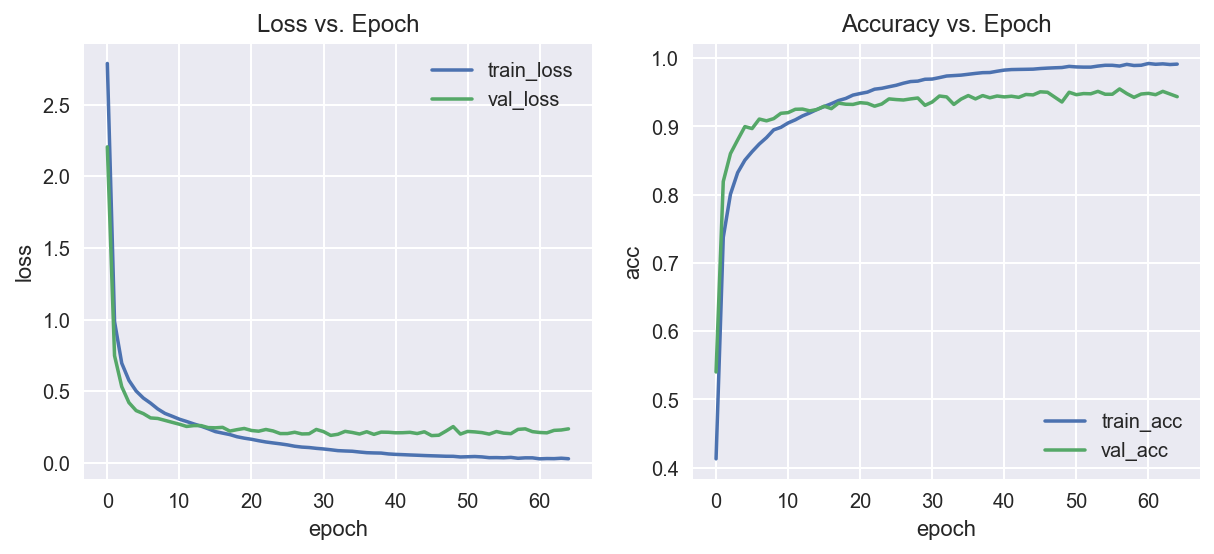

In [46]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn')

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train_loss', 'val_loss'])
plt.title('Loss vs. Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['train_acc', 'val_acc'])
plt.title('Accuracy vs. Epoch')
plt.ylabel('acc')
plt.xlabel('epoch')

save_fig('Dense 256 train')

In [55]:

model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(features_train.shape[1],),
                use_bias=True, bias_initializer=bias_initializer))
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu', use_bias=True, bias_initializer=bias_initializer))
model.add(Dropout(0.25))
model.add(Dense(n_class, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 1024)              8913920   
_________________________________________________________________
dropout_20 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_21 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 120)               123000    
Total params: 10,086,520
Trainable params: 10,086,520
Non-trainable params: 0
_________________________________________________________________


In [57]:
batch_size = 64
epochs = 100
history = model.fit(features_train, y, batch_size=batch_size, shuffle=True,
                            epochs = epochs, validation_split=0.1,verbose = 2,
                            callbacks=[early, reduction, tensorboard])

Train on 27721 samples, validate on 3081 samples


Epoch 1/100


 - 5s - loss: 1.1467 - acc: 0.6948 - val_loss: 0.4579 - val_acc: 0.8445


Epoch 2/100


 - 5s - loss: 0.5521 - acc: 0.8303 - val_loss: 0.4338 - val_acc: 0.8799


Epoch 3/100


 - 5s - loss: 0.4604 - acc: 0.8576 - val_loss: 0.3836 - val_acc: 0.8786


Epoch 4/100


 - 5s - loss: 0.4004 - acc: 0.8743 - val_loss: 0.3274 - val_acc: 0.9000


Epoch 5/100


 - 5s - loss: 0.3751 - acc: 0.8798 - val_loss: 0.3472 - val_acc: 0.8987


Epoch 6/100


 - 5s - loss: 0.3520 - acc: 0.8899 - val_loss: 0.3608 - val_acc: 0.8900


Epoch 7/100


 - 5s - loss: 0.3227 - acc: 0.8950 - val_loss: 0.3282 - val_acc: 0.9000


Epoch 8/100


 - 5s - loss: 0.3180 - acc: 0.8988 - val_loss: 0.3164 - val_acc: 0.9091


Epoch 9/100


 - 5s - loss: 0.2996 - acc: 0.9045 - val_loss: 0.3352 - val_acc: 0.9039


Epoch 10/100


 - 5s - loss: 0.2836 - acc: 0.9072 - val_loss: 0.3214 - val_acc: 0.9062


Epoch 11/100


 - 5s - loss: 0.2607 - acc: 0.9161 - val_loss: 0.3696 - val_acc: 0.8968


Epoch 12/100



Epoch 00012: reducing learning rate to 0.00010000000474974513.
 - 5s - loss: 0.2463 - acc: 0.9198 - val_loss: 0.3940 - val_acc: 0.8929


Epoch 13/100


 - 5s - loss: 0.1275 - acc: 0.9565 - val_loss: 0.2574 - val_acc: 0.9318


Epoch 14/100


 - 5s - loss: 0.0991 - acc: 0.9664 - val_loss: 0.2463 - val_acc: 0.9348


Epoch 15/100


 - 5s - loss: 0.0914 - acc: 0.9678 - val_loss: 0.2400 - val_acc: 0.9393


Epoch 16/100


 - 5s - loss: 0.0830 - acc: 0.9711 - val_loss: 0.2412 - val_acc: 0.9377


Epoch 17/100


 - 5s - loss: 0.0786 - acc: 0.9739 - val_loss: 0.2379 - val_acc: 0.9403


Epoch 18/100


 - 5s - loss: 0.0731 - acc: 0.9746 - val_loss: 0.2305 - val_acc: 0.9461


Epoch 19/100


 - 5s - loss: 0.0714 - acc: 0.9748 - val_loss: 0.2335 - val_acc: 0.9413


Epoch 20/100


 - 5s - loss: 0.0692 - acc: 0.9758 - val_loss: 0.2437 - val_acc: 0.9393


Epoch 21/100


 - 5s - loss: 0.0644 - acc: 0.9769 - val_loss: 0.2314 - val_acc: 0.9461


Epoch 22/100


 - 5s - loss: 0.0598 - acc: 0.9798 - val_loss: 0.2286 - val_acc: 0.9461


Epoch 23/100


 - 5s - loss: 0.0585 - acc: 0.9789 - val_loss: 0.2466 - val_acc: 0.9461


Epoch 24/100


 - 5s - loss: 0.0535 - acc: 0.9808 - val_loss: 0.2320 - val_acc: 0.9458


Epoch 25/100


 - 5s - loss: 0.0510 - acc: 0.9821 - val_loss: 0.2362 - val_acc: 0.9494


Epoch 26/100


 - 5s - loss: 0.0500 - acc: 0.9828 - val_loss: 0.2508 - val_acc: 0.9445


Epoch 27/100


 - 5s - loss: 0.0478 - acc: 0.9826 - val_loss: 0.2260 - val_acc: 0.9507


Epoch 28/100


 - 5s - loss: 0.0445 - acc: 0.9844 - val_loss: 0.2400 - val_acc: 0.9494


Epoch 29/100


 - 5s - loss: 0.0436 - acc: 0.9843 - val_loss: 0.2423 - val_acc: 0.9477


Epoch 30/100


 - 5s - loss: 0.0403 - acc: 0.9865 - val_loss: 0.2524 - val_acc: 0.9451


Epoch 31/100


 - 5s - loss: 0.0393 - acc: 0.9857 - val_loss: 0.2424 - val_acc: 0.9500


Epoch 32/100


 - 5s - loss: 0.0405 - acc: 0.9855 - val_loss: 0.2531 - val_acc: 0.9461


Epoch 33/100


 - 5s - loss: 0.0345 - acc: 0.9876 - val_loss: 0.2533 - val_acc: 0.9464


Epoch 34/100


 - 5s - loss: 0.0368 - acc: 0.9876 - val_loss: 0.2654 - val_acc: 0.9455


Epoch 35/100


 - 5s - loss: 0.0345 - acc: 0.9878 - val_loss: 0.2544 - val_acc: 0.9477


Epoch 00035: early stopping


1. Tried 2-Dense layer stacked with size (256, 512, 1024, 2048)
2. 1024 is suitable size for this project

In [60]:
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(features_train.shape[1],),
                use_bias=True, bias_initializer=bias_initializer))
model.add(Dense(1024, activation='relu', use_bias=True, bias_initializer=bias_initializer))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu', input_shape=(features_train.shape[1],),
                use_bias=True, bias_initializer=bias_initializer))
model.add(Dense(1024, activation='relu', input_shape=(features_train.shape[1],),
                use_bias=True, bias_initializer=bias_initializer))
model.add(Dropout(0.5))
model.add(Dense(n_class, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 1024)              8913920   
_________________________________________________________________
dense_39 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_22 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_40 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_41 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_23 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_42 (Dense)             (None, 120)               123000    
Total para

In [61]:
batch_size = 64
epochs = 100
history = model.fit(features_train, y, batch_size=batch_size, shuffle=True,
                            epochs = epochs, validation_split=0.1,verbose = 2,
                            callbacks=[early, reduction, tensorboard])

Train on 27721 samples, validate on 3081 samples


Epoch 1/100


 - 6s - loss: 1.8855 - acc: 0.5104 - val_loss: 0.9222 - val_acc: 0.7345


Epoch 2/100


 - 6s - loss: 0.6705 - acc: 0.7986 - val_loss: 0.4889 - val_acc: 0.8442


Epoch 3/100


 - 6s - loss: 0.5412 - acc: 0.8405 - val_loss: 0.4579 - val_acc: 0.8595


Epoch 4/100


 - 6s - loss: 0.4567 - acc: 0.8666 - val_loss: 0.6428 - val_acc: 0.8260


Epoch 5/100


 - 6s - loss: 0.4347 - acc: 0.8696 - val_loss: 0.5075 - val_acc: 0.8650


Epoch 6/100


 - 6s - loss: 0.3752 - acc: 0.8872 - val_loss: 0.4887 - val_acc: 0.8598


Epoch 7/100


 - 6s - loss: 0.3387 - acc: 0.8993 - val_loss: 0.3790 - val_acc: 0.9065


Epoch 8/100


 - 6s - loss: 0.3271 - acc: 0.9045 - val_loss: 0.4355 - val_acc: 0.8939


Epoch 9/100


 - 6s - loss: 0.3176 - acc: 0.9053 - val_loss: 0.4872 - val_acc: 0.8939


Epoch 10/100


 - 6s - loss: 0.2995 - acc: 0.9135 - val_loss: 0.4935 - val_acc: 0.8780


Epoch 11/100



Epoch 00011: reducing learning rate to 0.00010000000474974513.
 - 6s - loss: 0.2750 - acc: 0.9209 - val_loss: 0.5592 - val_acc: 0.8822


Epoch 12/100


 - 6s - loss: 0.1469 - acc: 0.9525 - val_loss: 0.3545 - val_acc: 0.9224


Epoch 13/100


 - 6s - loss: 0.1159 - acc: 0.9627 - val_loss: 0.3524 - val_acc: 0.9276


Epoch 14/100


 - 6s - loss: 0.1054 - acc: 0.9654 - val_loss: 0.3514 - val_acc: 0.9315


Epoch 15/100


 - 6s - loss: 0.0948 - acc: 0.9695 - val_loss: 0.3628 - val_acc: 0.9315


Epoch 16/100


 - 6s - loss: 0.0856 - acc: 0.9712 - val_loss: 0.3575 - val_acc: 0.9309


Epoch 17/100


 - 6s - loss: 0.0793 - acc: 0.9738 - val_loss: 0.3565 - val_acc: 0.9344


Epoch 18/100


 - 6s - loss: 0.0766 - acc: 0.9735 - val_loss: 0.3694 - val_acc: 0.9335


Epoch 19/100


 - 6s - loss: 0.0676 - acc: 0.9771 - val_loss: 0.3757 - val_acc: 0.9338


Epoch 20/100


 - 6s - loss: 0.0673 - acc: 0.9766 - val_loss: 0.3675 - val_acc: 0.9361


Epoch 21/100


 - 6s - loss: 0.0604 - acc: 0.9786 - val_loss: 0.3815 - val_acc: 0.9328


Epoch 22/100


 - 6s - loss: 0.0547 - acc: 0.9804 - val_loss: 0.3770 - val_acc: 0.9348


Epoch 23/100


 - 6s - loss: 0.0527 - acc: 0.9817 - val_loss: 0.3658 - val_acc: 0.9406


Epoch 24/100


 - 6s - loss: 0.0496 - acc: 0.9831 - val_loss: 0.3923 - val_acc: 0.9361


Epoch 25/100


 - 6s - loss: 0.0460 - acc: 0.9836 - val_loss: 0.3901 - val_acc: 0.9393


Epoch 26/100


 - 6s - loss: 0.0418 - acc: 0.9853 - val_loss: 0.3902 - val_acc: 0.9419


Epoch 27/100


 - 6s - loss: 0.0400 - acc: 0.9864 - val_loss: 0.3775 - val_acc: 0.9419


Epoch 28/100


 - 6s - loss: 0.0370 - acc: 0.9873 - val_loss: 0.3920 - val_acc: 0.9413


Epoch 29/100


 - 6s - loss: 0.0382 - acc: 0.9870 - val_loss: 0.3949 - val_acc: 0.9403


Epoch 30/100



Epoch 00030: reducing learning rate to 5e-05.
 - 6s - loss: 0.0345 - acc: 0.9886 - val_loss: 0.3790 - val_acc: 0.9419


Epoch 31/100


 - 6s - loss: 0.0278 - acc: 0.9908 - val_loss: 0.3986 - val_acc: 0.9435


Epoch 32/100


 - 6s - loss: 0.0260 - acc: 0.9912 - val_loss: 0.3895 - val_acc: 0.9442


Epoch 33/100


 - 6s - loss: 0.0239 - acc: 0.9921 - val_loss: 0.4079 - val_acc: 0.9438


Epoch 34/100


 - 6s - loss: 0.0253 - acc: 0.9912 - val_loss: 0.4254 - val_acc: 0.9400


Epoch 35/100


 - 6s - loss: 0.0227 - acc: 0.9922 - val_loss: 0.4117 - val_acc: 0.9435


Epoch 36/100


 - 6s - loss: 0.0219 - acc: 0.9931 - val_loss: 0.4161 - val_acc: 0.9458


Epoch 37/100


 - 6s - loss: 0.0219 - acc: 0.9920 - val_loss: 0.4163 - val_acc: 0.9458


Epoch 38/100


 - 6s - loss: 0.0209 - acc: 0.9921 - val_loss: 0.4129 - val_acc: 0.9432


Epoch 39/100


 - 6s - loss: 0.0204 - acc: 0.9927 - val_loss: 0.4215 - val_acc: 0.9445


Epoch 40/100


 - 6s - loss: 0.0188 - acc: 0.9933 - val_loss: 0.4062 - val_acc: 0.9474


Epoch 41/100


 - 6s - loss: 0.0187 - acc: 0.9938 - val_loss: 0.4097 - val_acc: 0.9445


Epoch 42/100


 - 6s - loss: 0.0174 - acc: 0.9935 - val_loss: 0.4133 - val_acc: 0.9471


Epoch 43/100


 - 6s - loss: 0.0161 - acc: 0.9938 - val_loss: 0.4237 - val_acc: 0.9445


Epoch 44/100


 - 6s - loss: 0.0160 - acc: 0.9943 - val_loss: 0.4400 - val_acc: 0.9438


Epoch 45/100


 - 6s - loss: 0.0161 - acc: 0.9947 - val_loss: 0.4324 - val_acc: 0.9461


Epoch 46/100


 - 6s - loss: 0.0144 - acc: 0.9953 - val_loss: 0.4407 - val_acc: 0.9464


Epoch 47/100


 - 6s - loss: 0.0151 - acc: 0.9948 - val_loss: 0.4346 - val_acc: 0.9464


Epoch 48/100


 - 6s - loss: 0.0148 - acc: 0.9949 - val_loss: 0.4324 - val_acc: 0.9477


Epoch 49/100


 - 6s - loss: 0.0137 - acc: 0.9953 - val_loss: 0.4427 - val_acc: 0.9461


Epoch 50/100


 - 6s - loss: 0.0141 - acc: 0.9950 - val_loss: 0.4432 - val_acc: 0.9464


Epoch 51/100


 - 6s - loss: 0.0151 - acc: 0.9948 - val_loss: 0.4391 - val_acc: 0.9461


Epoch 52/100


 - 6s - loss: 0.0112 - acc: 0.9959 - val_loss: 0.4514 - val_acc: 0.9458


Epoch 53/100


 - 6s - loss: 0.0123 - acc: 0.9956 - val_loss: 0.4405 - val_acc: 0.9484


Epoch 54/100


 - 6s - loss: 0.0137 - acc: 0.9955 - val_loss: 0.4370 - val_acc: 0.9484


Epoch 55/100


 - 6s - loss: 0.0110 - acc: 0.9961 - val_loss: 0.4653 - val_acc: 0.9429


Epoch 56/100


 - 6s - loss: 0.0121 - acc: 0.9956 - val_loss: 0.4524 - val_acc: 0.9461


Epoch 57/100


 - 6s - loss: 0.0097 - acc: 0.9968 - val_loss: 0.4476 - val_acc: 0.9468


Epoch 58/100


 - 6s - loss: 0.0113 - acc: 0.9960 - val_loss: 0.4636 - val_acc: 0.9458


Epoch 59/100


 - 6s - loss: 0.0120 - acc: 0.9959 - val_loss: 0.4439 - val_acc: 0.9461


Epoch 60/100


 - 6s - loss: 0.0112 - acc: 0.9962 - val_loss: 0.4482 - val_acc: 0.9490


Epoch 61/100


 - 6s - loss: 0.0116 - acc: 0.9961 - val_loss: 0.4413 - val_acc: 0.9468


Epoch 62/100


 - 6s - loss: 0.0101 - acc: 0.9967 - val_loss: 0.4685 - val_acc: 0.9464


Epoch 63/100


 - 6s - loss: 0.0102 - acc: 0.9966 - val_loss: 0.4426 - val_acc: 0.9497


Epoch 64/100


 - 6s - loss: 0.0095 - acc: 0.9965 - val_loss: 0.4440 - val_acc: 0.9487


Epoch 65/100


 - 6s - loss: 0.0093 - acc: 0.9968 - val_loss: 0.4609 - val_acc: 0.9471


Epoch 66/100


 - 6s - loss: 0.0097 - acc: 0.9965 - val_loss: 0.4701 - val_acc: 0.9464


Epoch 67/100


 - 6s - loss: 0.0099 - acc: 0.9968 - val_loss: 0.4525 - val_acc: 0.9474


Epoch 68/100


 - 6s - loss: 0.0094 - acc: 0.9967 - val_loss: 0.4754 - val_acc: 0.9429


Epoch 69/100


 - 6s - loss: 0.0098 - acc: 0.9965 - val_loss: 0.4895 - val_acc: 0.9445


Epoch 70/100


 - 6s - loss: 0.0104 - acc: 0.9965 - val_loss: 0.4714 - val_acc: 0.9487


Epoch 71/100


 - 6s - loss: 0.0095 - acc: 0.9970 - val_loss: 0.4712 - val_acc: 0.9461


Epoch 72/100


 - 6s - loss: 0.0091 - acc: 0.9970 - val_loss: 0.4703 - val_acc: 0.9455


Epoch 73/100


 - 6s - loss: 0.0084 - acc: 0.9969 - val_loss: 0.4838 - val_acc: 0.9477


Epoch 00073: early stopping


1. Tried to stack more Dense layers, no improvement
2. Then try to add L2 regulariation to slow down training and overfitting

In [14]:
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(features_train.shape[1],),
                use_bias=True, bias_initializer=bias_initializer, kernel_regularizer=reg))
model.add(Dropout(0.25))

model.add(Dense(1024, activation='relu', use_bias=True, bias_initializer=bias_initializer,
                kernel_regularizer=reg))
model.add(Dropout(0.25))

model.add(Dense(n_class, activation='softmax', use_bias=True, bias_initializer=bias_initializer,))

model.compile(loss='categorical_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 1024)              8913920   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 120)               123000    
Total params: 10,086,520
Trainable params: 10,086,520
Non-trainable params: 0
_________________________________________________________________


In [15]:
batch_size = 64
epochs = 100
history = model.fit(features_train, y, batch_size=batch_size, shuffle=True,
                            epochs = epochs, validation_split=0.1,verbose = 2,
                            callbacks=[reduction, tensorboard])

Train on 27721 samples, validate on 3081 samples


Epoch 1/100


 - 7s - loss: 1.3089 - acc: 0.6980 - val_loss: 0.7742 - val_acc: 0.8101


Epoch 2/100


 - 6s - loss: 0.7393 - acc: 0.8251 - val_loss: 0.6486 - val_acc: 0.8536


Epoch 3/100


 - 6s - loss: 0.6628 - acc: 0.8497 - val_loss: 0.4742 - val_acc: 0.9081


Epoch 4/100


 - 6s - loss: 0.6359 - acc: 0.8596 - val_loss: 0.5633 - val_acc: 0.8942


Epoch 5/100


 - 6s - loss: 0.6234 - acc: 0.8628 - val_loss: 0.5719 - val_acc: 0.8780


Epoch 6/100


 - 6s - loss: 0.5946 - acc: 0.8737 - val_loss: 0.6433 - val_acc: 0.8715


Epoch 7/100



Epoch 00007: reducing learning rate to 0.00010000000474974513.
 - 6s - loss: 0.5963 - acc: 0.8735 - val_loss: 0.5578 - val_acc: 0.9007


Epoch 8/100


 - 6s - loss: 0.4236 - acc: 0.9266 - val_loss: 0.4626 - val_acc: 0.9205


Epoch 9/100


 - 6s - loss: 0.3883 - acc: 0.9358 - val_loss: 0.4604 - val_acc: 0.9179


Epoch 10/100


 - 6s - loss: 0.3701 - acc: 0.9407 - val_loss: 0.4419 - val_acc: 0.9279


Epoch 11/100


 - 6s - loss: 0.3513 - acc: 0.9443 - val_loss: 0.4234 - val_acc: 0.9286


Epoch 12/100


 - 6s - loss: 0.3390 - acc: 0.9478 - val_loss: 0.4070 - val_acc: 0.9354


Epoch 13/100


 - 6s - loss: 0.3229 - acc: 0.9497 - val_loss: 0.4021 - val_acc: 0.9357


Epoch 14/100


 - 6s - loss: 0.3098 - acc: 0.9514 - val_loss: 0.4102 - val_acc: 0.9354


Epoch 15/100


 - 6s - loss: 0.2971 - acc: 0.9548 - val_loss: 0.3949 - val_acc: 0.9367


Epoch 16/100


 - 6s - loss: 0.2881 - acc: 0.9575 - val_loss: 0.3787 - val_acc: 0.9383


Epoch 17/100


 - 6s - loss: 0.2784 - acc: 0.9571 - val_loss: 0.3849 - val_acc: 0.9396


Epoch 18/100


 - 6s - loss: 0.2642 - acc: 0.9602 - val_loss: 0.3798 - val_acc: 0.9387


Epoch 19/100


 - 6s - loss: 0.2575 - acc: 0.9614 - val_loss: 0.3710 - val_acc: 0.9393


Epoch 20/100


 - 6s - loss: 0.2469 - acc: 0.9633 - val_loss: 0.3656 - val_acc: 0.9357


Epoch 21/100


 - 6s - loss: 0.2407 - acc: 0.9659 - val_loss: 0.3430 - val_acc: 0.9455


Epoch 22/100


 - 6s - loss: 0.2315 - acc: 0.9660 - val_loss: 0.3475 - val_acc: 0.9455


Epoch 23/100


 - 6s - loss: 0.2274 - acc: 0.9680 - val_loss: 0.3400 - val_acc: 0.9432


Epoch 24/100


 - 6s - loss: 0.2186 - acc: 0.9695 - val_loss: 0.3370 - val_acc: 0.9458


Epoch 25/100


 - 6s - loss: 0.2131 - acc: 0.9684 - val_loss: 0.3220 - val_acc: 0.9490


Epoch 26/100


 - 6s - loss: 0.2058 - acc: 0.9718 - val_loss: 0.3526 - val_acc: 0.9422


Epoch 27/100


 - 6s - loss: 0.2010 - acc: 0.9717 - val_loss: 0.3368 - val_acc: 0.9461


Epoch 28/100


 - 6s - loss: 0.1951 - acc: 0.9747 - val_loss: 0.3378 - val_acc: 0.9429


Epoch 29/100



Epoch 00029: reducing learning rate to 5e-05.
 - 6s - loss: 0.1945 - acc: 0.9727 - val_loss: 0.3385 - val_acc: 0.9422


Epoch 30/100


 - 6s - loss: 0.1799 - acc: 0.9779 - val_loss: 0.3277 - val_acc: 0.9461


Epoch 31/100


 - 6s - loss: 0.1750 - acc: 0.9797 - val_loss: 0.3219 - val_acc: 0.9477


Epoch 32/100


 - 6s - loss: 0.1725 - acc: 0.9803 - val_loss: 0.3325 - val_acc: 0.9464


Epoch 33/100


 - 6s - loss: 0.1701 - acc: 0.9815 - val_loss: 0.3211 - val_acc: 0.9497


Epoch 34/100


 - 6s - loss: 0.1726 - acc: 0.9792 - val_loss: 0.3321 - val_acc: 0.9458


Epoch 35/100


 - 6s - loss: 0.1682 - acc: 0.9806 - val_loss: 0.3312 - val_acc: 0.9445


Epoch 36/100


 - 6s - loss: 0.1632 - acc: 0.9825 - val_loss: 0.3254 - val_acc: 0.9503


Epoch 37/100


 - 6s - loss: 0.1615 - acc: 0.9825 - val_loss: 0.3201 - val_acc: 0.9497


Epoch 38/100


 - 6s - loss: 0.1607 - acc: 0.9830 - val_loss: 0.3216 - val_acc: 0.9500


Epoch 39/100


 - 6s - loss: 0.1574 - acc: 0.9846 - val_loss: 0.3210 - val_acc: 0.9484


Epoch 40/100


 - 6s - loss: 0.1575 - acc: 0.9841 - val_loss: 0.3226 - val_acc: 0.9464


Epoch 41/100


 - 6s - loss: 0.1552 - acc: 0.9836 - val_loss: 0.3049 - val_acc: 0.9520


Epoch 42/100


 - 6s - loss: 0.1547 - acc: 0.9842 - val_loss: 0.3154 - val_acc: 0.9445


Epoch 43/100


 - 6s - loss: 0.1531 - acc: 0.9843 - val_loss: 0.3197 - val_acc: 0.9468


Epoch 44/100


 - 6s - loss: 0.1513 - acc: 0.9843 - val_loss: 0.3187 - val_acc: 0.9487


Epoch 45/100


 - 6s - loss: 0.1485 - acc: 0.9852 - val_loss: 0.3144 - val_acc: 0.9497


Epoch 46/100


 - 6s - loss: 0.1478 - acc: 0.9840 - val_loss: 0.3060 - val_acc: 0.9510


Epoch 47/100


 - 6s - loss: 0.1459 - acc: 0.9848 - val_loss: 0.3114 - val_acc: 0.9494


Epoch 48/100


 - 6s - loss: 0.1444 - acc: 0.9860 - val_loss: 0.3079 - val_acc: 0.9497


Epoch 49/100


 - 6s - loss: 0.1422 - acc: 0.9870 - val_loss: 0.3104 - val_acc: 0.9500


Epoch 50/100


 - 6s - loss: 0.1412 - acc: 0.9870 - val_loss: 0.3037 - val_acc: 0.9507


Epoch 51/100


 - 6s - loss: 0.1402 - acc: 0.9868 - val_loss: 0.3017 - val_acc: 0.9510


Epoch 52/100


 - 6s - loss: 0.1394 - acc: 0.9869 - val_loss: 0.3160 - val_acc: 0.9477


Epoch 53/100


 - 6s - loss: 0.1354 - acc: 0.9883 - val_loss: 0.3086 - val_acc: 0.9481


Epoch 54/100


 - 6s - loss: 0.1360 - acc: 0.9878 - val_loss: 0.3083 - val_acc: 0.9500


Epoch 55/100


 - 6s - loss: 0.1339 - acc: 0.9884 - val_loss: 0.3079 - val_acc: 0.9464


Epoch 56/100


 - 6s - loss: 0.1314 - acc: 0.9885 - val_loss: 0.3073 - val_acc: 0.9490


Epoch 57/100


 - 6s - loss: 0.1315 - acc: 0.9883 - val_loss: 0.3090 - val_acc: 0.9497


Epoch 58/100


 - 6s - loss: 0.1299 - acc: 0.9889 - val_loss: 0.3039 - val_acc: 0.9497


Epoch 59/100


 - 6s - loss: 0.1300 - acc: 0.9882 - val_loss: 0.3067 - val_acc: 0.9494


Epoch 60/100


 - 6s - loss: 0.1284 - acc: 0.9893 - val_loss: 0.3083 - val_acc: 0.9477


Epoch 61/100


 - 6s - loss: 0.1277 - acc: 0.9885 - val_loss: 0.3060 - val_acc: 0.9477


Epoch 62/100


 - 6s - loss: 0.1265 - acc: 0.9891 - val_loss: 0.3043 - val_acc: 0.9503


Epoch 63/100


 - 6s - loss: 0.1254 - acc: 0.9893 - val_loss: 0.2990 - val_acc: 0.9487


Epoch 64/100


 - 6s - loss: 0.1236 - acc: 0.9899 - val_loss: 0.3091 - val_acc: 0.9481


Epoch 65/100


 - 6s - loss: 0.1241 - acc: 0.9891 - val_loss: 0.2982 - val_acc: 0.9503


Epoch 66/100


 - 6s - loss: 0.1217 - acc: 0.9900 - val_loss: 0.2978 - val_acc: 0.9513


Epoch 67/100


 - 6s - loss: 0.1208 - acc: 0.9902 - val_loss: 0.2959 - val_acc: 0.9500


Epoch 68/100


 - 6s - loss: 0.1196 - acc: 0.9905 - val_loss: 0.3020 - val_acc: 0.9481


Epoch 69/100


 - 6s - loss: 0.1201 - acc: 0.9892 - val_loss: 0.2991 - val_acc: 0.9510


Epoch 70/100


 - 6s - loss: 0.1199 - acc: 0.9895 - val_loss: 0.2997 - val_acc: 0.9497


Epoch 71/100


 - 6s - loss: 0.1173 - acc: 0.9904 - val_loss: 0.2983 - val_acc: 0.9481


Epoch 72/100


 - 6s - loss: 0.1174 - acc: 0.9905 - val_loss: 0.3051 - val_acc: 0.9497


Epoch 73/100


 - 6s - loss: 0.1153 - acc: 0.9908 - val_loss: 0.2974 - val_acc: 0.9503


Epoch 74/100


 - 6s - loss: 0.1159 - acc: 0.9905 - val_loss: 0.2949 - val_acc: 0.9523


Epoch 75/100


 - 6s - loss: 0.1150 - acc: 0.9904 - val_loss: 0.3022 - val_acc: 0.9494


Epoch 76/100


 - 6s - loss: 0.1147 - acc: 0.9903 - val_loss: 0.2895 - val_acc: 0.9474


Epoch 77/100


 - 6s - loss: 0.1135 - acc: 0.9905 - val_loss: 0.2984 - val_acc: 0.9481


Epoch 78/100


 - 6s - loss: 0.1123 - acc: 0.9913 - val_loss: 0.2936 - val_acc: 0.9468


Epoch 79/100


 - 6s - loss: 0.1112 - acc: 0.9908 - val_loss: 0.2965 - val_acc: 0.9490


Epoch 80/100


 - 6s - loss: 0.1101 - acc: 0.9911 - val_loss: 0.2981 - val_acc: 0.9510


Epoch 81/100


 - 6s - loss: 0.1092 - acc: 0.9911 - val_loss: 0.2980 - val_acc: 0.9484


Epoch 82/100


 - 6s - loss: 0.1074 - acc: 0.9925 - val_loss: 0.2920 - val_acc: 0.9487


Epoch 83/100


 - 6s - loss: 0.1120 - acc: 0.9896 - val_loss: 0.3053 - val_acc: 0.9451


Epoch 84/100


 - 6s - loss: 0.1064 - acc: 0.9918 - val_loss: 0.2972 - val_acc: 0.9507


Epoch 85/100


 - 6s - loss: 0.1061 - acc: 0.9920 - val_loss: 0.2902 - val_acc: 0.9507


Epoch 86/100


 - 6s - loss: 0.1076 - acc: 0.9909 - val_loss: 0.2922 - val_acc: 0.9503


Epoch 87/100


 - 6s - loss: 0.1072 - acc: 0.9912 - val_loss: 0.2897 - val_acc: 0.9507


Epoch 88/100


 - 6s - loss: 0.1058 - acc: 0.9915 - val_loss: 0.2881 - val_acc: 0.9481


Epoch 89/100


 - 6s - loss: 0.1049 - acc: 0.9911 - val_loss: 0.2819 - val_acc: 0.9536


Epoch 90/100


 - 6s - loss: 0.1034 - acc: 0.9921 - val_loss: 0.2926 - val_acc: 0.9503


Epoch 91/100


 - 6s - loss: 0.1029 - acc: 0.9919 - val_loss: 0.2866 - val_acc: 0.9484


Epoch 92/100


 - 6s - loss: 0.1012 - acc: 0.9926 - val_loss: 0.2847 - val_acc: 0.9484


Epoch 93/100


 - 6s - loss: 0.1030 - acc: 0.9916 - val_loss: 0.2899 - val_acc: 0.9510


Epoch 94/100


 - 6s - loss: 0.1010 - acc: 0.9927 - val_loss: 0.2904 - val_acc: 0.9494


Epoch 95/100


 - 6s - loss: 0.1009 - acc: 0.9922 - val_loss: 0.2819 - val_acc: 0.9529


Epoch 96/100


 - 6s - loss: 0.0993 - acc: 0.9926 - val_loss: 0.2892 - val_acc: 0.9494


Epoch 97/100


 - 6s - loss: 0.0987 - acc: 0.9926 - val_loss: 0.2822 - val_acc: 0.9503


Epoch 98/100


 - 6s - loss: 0.0979 - acc: 0.9932 - val_loss: 0.2891 - val_acc: 0.9481


Epoch 99/100


 - 6s - loss: 0.0977 - acc: 0.9926 - val_loss: 0.2945 - val_acc: 0.9481


Epoch 100/100


 - 6s - loss: 0.0982 - acc: 0.9919 - val_loss: 0.2866 - val_acc: 0.9523


Performance increased a little bit after add L2 regularization

Saving figure final result 1


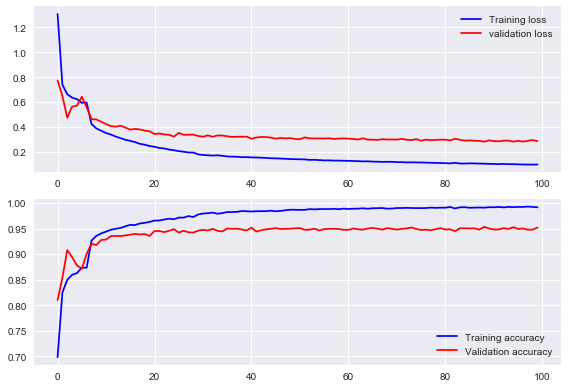

In [23]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

save_fig('final result 1')

Training Result Analysis

In [31]:
# obtain the wrongly predicted image index
y_pred_train = model.predict(features_train)
pred_index = np.argmax(y_pred_train, axis=1)
real_index = np.argmax(y, axis=1)
wrong = []
for ix, pred in enumerate(pred_index):
    if pred != real_index[ix]:
        wrong.append(ix)

Saving figure wrong prediction


/home/tulan/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


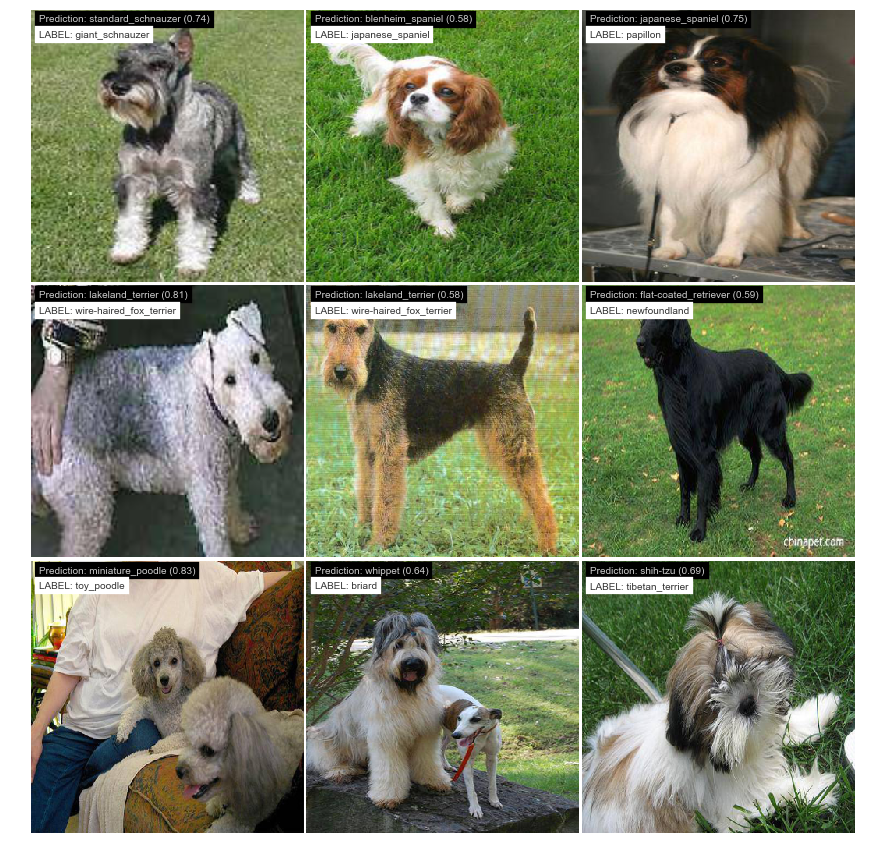

In [51]:
# plot the wrongly predicted image samples
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(1, figsize=(12, 12))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 3), axes_pad=0.05)
for i in range(9):
    
    ax = grid[i]
    ax.imshow(X[wrong[i]][:,:,::-1])
    
    # get the breed name
    pred_breed = num_to_class[pred_index[wrong[i]]]
    real_breed = num_to_class[real_index[wrong[i]]]
    # get the prediction value
    prob = y_pred_train[wrong[i]][pred_index[wrong[i]]]

    # plot the prediction and correct breed text label
    ax.text(10, 15, 'Prediction: %s (%.2f)' % (pred_breed , prob), color='w', 
            backgroundcolor='k', alpha=0.8)
    ax.text(10, 35, 'LABEL: %s' % real_breed, color='k', backgroundcolor='w', alpha=0.8)
    ax.axis('off')
save_fig('wrong prediction')

Saving figure Wrong Predicted Count


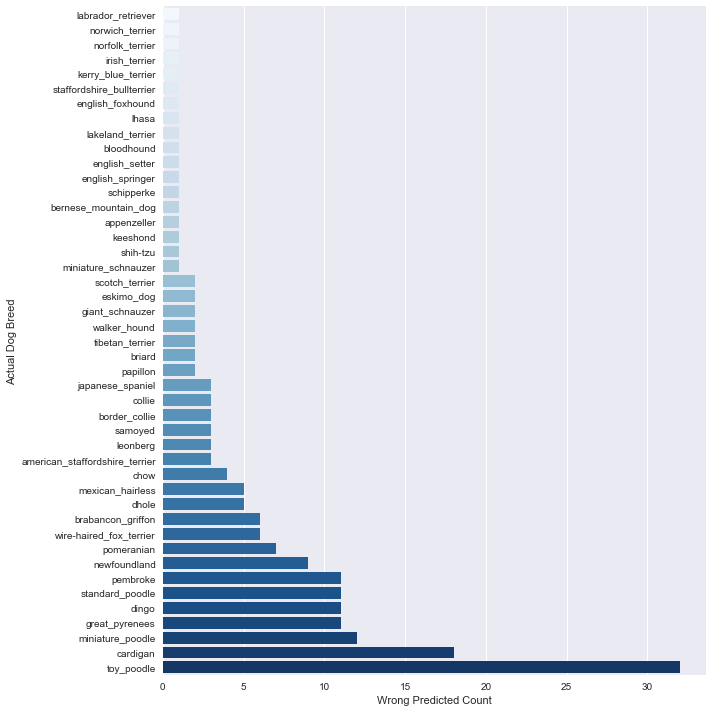

In [86]:
# plot the wrong prediction count bar chart
from collections import Counter
wrong_breed = []
for ix in wrong:
    real = num_to_class[real_index[ix]]
    wrong_breed.append(real)

count = Counter(wrong_breed)
labels, values = zip(*count.items())
df_wrong = pd.DataFrame()
df_wrong['Actual Dog Breed'] = labels
df_wrong['Wrong Predicted Count'] = values
df_wrong = df_wrong.sort_values('Wrong Predicted Count')

plt.figure(figsize=(10,10))
sns.barplot(y ='Actual Dog Breed', x='Wrong Predicted Count', data=df_wrong, palette="Blues")

save_fig('Wrong Predicted Count')

1. Training finished, start to touch the test data set
2. Extract the bottlenect features of test set
3. Use the trained model to predict the test set
4. generate the output file with submission format, and output to csv file

In [ ]:
# load the submission format
df2 = pd.read_csv(INPUT_PATH + '/sample_submission.csv')

Load the test images with the same size as training (350, 350)

In [61]:
n_test = len(df2)
X_test = np.zeros((n_test, width, width, 3), dtype=np.uint8)
for i in tqdm(range(n_test)):
    X_test[i] = cv2.resize(cv2.imread(INPUT_PATH + '/test/%s.jpg' % df2['id'][i]), (width, width))
X_test = np.load(INPUT_PATH + '/X_test_350.npy')
X_test.shape

(10357, 350, 350, 3)

Get the features of test set using the same 6 pre-trained models

In [62]:
inception_test = get_features(InceptionV3, X_test)
xception_test = get_features(Xception, X_test)
inres_test = get_features(InceptionResNetV2, X_test)
res_test = get_features(ResNet50, X_test)
vgg19_test = get_features(VGG19, X_test)
vgg16_test = get_features(VGG16, X_test)

   32/10357 [..............................] - ETA: 3:40

   64/10357 [..............................] - ETA: 3:07

   96/10357 [..............................] - ETA: 2:56

  128/10357 [..............................] - ETA: 2:50

  160/10357 [..............................] - ETA: 2:46

  192/10357 [..............................] - ETA: 2:44

  224/10357 [..............................] - ETA: 2:42

  256/10357 [..............................] - ETA: 2:40

  288/10357 [..............................] - ETA: 2:39

  320/10357 [..............................] - ETA: 2:37

  352/10357 [>.............................] - ETA: 2:36

  384/10357 [>.............................] - ETA: 2:35

  416/10357 [>.............................] - ETA: 2:34

  448/10357 [>.............................] - ETA: 2:33

  480/10357 [>.............................] - ETA: 2:33

  512/10357 [>.............................] - ETA: 2:32

  544/10357 [>.............................] - ETA: 2:31

  576/10357 [>.............................] - ETA: 2:30

  608/10357 [>.............................] - ETA: 2:30

  640/10357 [>.............................] - ETA: 2:29

  672/10357 [>.............................] - ETA: 2:29

  704/10357 [=>............................] - ETA: 2:28

  736/10357 [=>............................] - ETA: 2:27

  768/10357 [=>............................] - ETA: 2:27

  800/10357 [=>............................] - ETA: 2:26

  832/10357 [=>............................] - ETA: 2:25

  864/10357 [=>............................] - ETA: 2:25

  896/10357 [=>............................] - ETA: 2:24

  928/10357 [=>............................] - ETA: 2:24

  960/10357 [=>............................] - ETA: 2:23

  992/10357 [=>............................] - ETA: 2:23

 1024/10357 [=>............................] - ETA: 2:22

 1056/10357 [==>...........................] - ETA: 2:22

 1088/10357 [==>...........................] - ETA: 2:21

 1120/10357 [==>...........................] - ETA: 2:20

 1152/10357 [==>...........................] - ETA: 2:20

 1184/10357 [==>...........................] - ETA: 2:19

 1216/10357 [==>...........................] - ETA: 2:19

 1248/10357 [==>...........................] - ETA: 2:18

 1280/10357 [==>...........................] - ETA: 2:18

 1312/10357 [==>...........................] - ETA: 2:17

 1344/10357 [==>...........................] - ETA: 2:17

 1376/10357 [==>...........................] - ETA: 2:16

 1408/10357 [===>..........................] - ETA: 2:16

 1440/10357 [===>..........................] - ETA: 2:15

 1472/10357 [===>..........................] - ETA: 2:15

 1504/10357 [===>..........................] - ETA: 2:14

 1536/10357 [===>..........................] - ETA: 2:14

 1568/10357 [===>..........................] - ETA: 2:13

 1600/10357 [===>..........................] - ETA: 2:13

 1632/10357 [===>..........................] - ETA: 2:12

 1664/10357 [===>..........................] - ETA: 2:12

 1696/10357 [===>..........................] - ETA: 2:11

 1728/10357 [====>.........................] - ETA: 2:11

 1760/10357 [====>.........................] - ETA: 2:10

 1792/10357 [====>.........................] - ETA: 2:10

 1824/10357 [====>.........................] - ETA: 2:09

 1856/10357 [====>.........................] - ETA: 2:09

 1888/10357 [====>.........................] - ETA: 2:08

 1920/10357 [====>.........................] - ETA: 2:08

 1952/10357 [====>.........................] - ETA: 2:07

 1984/10357 [====>.........................] - ETA: 2:07

 2016/10357 [====>.........................] - ETA: 2:06

 2048/10357 [====>.........................] - ETA: 2:06

 2080/10357 [=====>........................] - ETA: 2:05

 2112/10357 [=====>........................] - ETA: 2:05

 2144/10357 [=====>........................] - ETA: 2:04

 2176/10357 [=====>........................] - ETA: 2:04

 2208/10357 [=====>........................] - ETA: 2:03

 2240/10357 [=====>........................] - ETA: 2:03

 2272/10357 [=====>........................] - ETA: 2:02

 2304/10357 [=====>........................] - ETA: 2:02

 2336/10357 [=====>........................] - ETA: 2:01

 2368/10357 [=====>........................] - ETA: 2:01

 2400/10357 [=====>........................] - ETA: 2:00

 2432/10357 [======>.......................] - ETA: 2:00

 2464/10357 [======>.......................] - ETA: 1:59

 2496/10357 [======>.......................] - ETA: 1:59

 2528/10357 [======>.......................] - ETA: 1:58

 2560/10357 [======>.......................] - ETA: 1:58

 2592/10357 [======>.......................] - ETA: 1:57

 2624/10357 [======>.......................] - ETA: 1:57

 2656/10357 [======>.......................] - ETA: 1:56

 2688/10357 [======>.......................] - ETA: 1:56

 2720/10357 [======>.......................] - ETA: 1:55

 2752/10357 [======>.......................] - ETA: 1:55

 2784/10357 [=======>......................] - ETA: 1:54

 2816/10357 [=======>......................] - ETA: 1:54

 2848/10357 [=======>......................] - ETA: 1:53

 2880/10357 [=======>......................] - ETA: 1:53

 2912/10357 [=======>......................] - ETA: 1:52

 2944/10357 [=======>......................] - ETA: 1:52

 2976/10357 [=======>......................] - ETA: 1:51

 3008/10357 [=======>......................] - ETA: 1:51

 3040/10357 [=======>......................] - ETA: 1:50

 3072/10357 [=======>......................] - ETA: 1:50

 3104/10357 [=======>......................] - ETA: 1:49

 3136/10357 [========>.....................] - ETA: 1:49

 3168/10357 [========>.....................] - ETA: 1:48

 3200/10357 [========>.....................] - ETA: 1:48

 3232/10357 [========>.....................] - ETA: 1:47

 3264/10357 [========>.....................] - ETA: 1:47

 3296/10357 [========>.....................] - ETA: 1:47

 3328/10357 [========>.....................] - ETA: 1:46

 3360/10357 [========>.....................] - ETA: 1:46

 3392/10357 [========>.....................] - ETA: 1:45

 3424/10357 [========>.....................] - ETA: 1:45

 3456/10357 [=========>....................] - ETA: 1:44

 3488/10357 [=========>....................] - ETA: 1:44

 3520/10357 [=========>....................] - ETA: 1:43

 3552/10357 [=========>....................] - ETA: 1:43

 3584/10357 [=========>....................] - ETA: 1:42

 3616/10357 [=========>....................] - ETA: 1:42

 3648/10357 [=========>....................] - ETA: 1:41

 3680/10357 [=========>....................] - ETA: 1:41

 3712/10357 [=========>....................] - ETA: 1:40

 3744/10357 [=========>....................] - ETA: 1:40

 3776/10357 [=========>....................] - ETA: 1:39

 3808/10357 [==========>...................] - ETA: 1:39

 3840/10357 [==========>...................] - ETA: 1:38

 3872/10357 [==========>...................] - ETA: 1:38

 3904/10357 [==========>...................] - ETA: 1:37

 3936/10357 [==========>...................] - ETA: 1:37

 3968/10357 [==========>...................] - ETA: 1:36

 4000/10357 [==========>...................] - ETA: 1:36

 4032/10357 [==========>...................] - ETA: 1:36

 4064/10357 [==========>...................] - ETA: 1:35

 4096/10357 [==========>...................] - ETA: 1:35

 4128/10357 [==========>...................] - ETA: 1:34

 4160/10357 [===========>..................] - ETA: 1:34

 4192/10357 [===========>..................] - ETA: 1:33

 4224/10357 [===========>..................] - ETA: 1:33

 4256/10357 [===========>..................] - ETA: 1:32

 4288/10357 [===========>..................] - ETA: 1:32

 4320/10357 [===========>..................] - ETA: 1:31

 4352/10357 [===========>..................] - ETA: 1:31

 4384/10357 [===========>..................] - ETA: 1:30

 4416/10357 [===========>..................] - ETA: 1:30

 4448/10357 [===========>..................] - ETA: 1:29

 4480/10357 [===========>..................] - ETA: 1:29

 4512/10357 [============>.................] - ETA: 1:28

 4544/10357 [============>.................] - ETA: 1:28

 4576/10357 [============>.................] - ETA: 1:28

 4608/10357 [============>.................] - ETA: 1:27

 4640/10357 [============>.................] - ETA: 1:27

 4672/10357 [============>.................] - ETA: 1:26

 4704/10357 [============>.................] - ETA: 1:26

 4736/10357 [============>.................] - ETA: 1:25

 4768/10357 [============>.................] - ETA: 1:25

 4800/10357 [============>.................] - ETA: 1:24

 4832/10357 [============>.................] - ETA: 1:24

 4864/10357 [=============>................] - ETA: 1:23

 4896/10357 [=============>................] - ETA: 1:23

 4928/10357 [=============>................] - ETA: 1:22

 4960/10357 [=============>................] - ETA: 1:22

 4992/10357 [=============>................] - ETA: 1:21

 5024/10357 [=============>................] - ETA: 1:21

 5056/10357 [=============>................] - ETA: 1:20

 5088/10357 [=============>................] - ETA: 1:20

 5120/10357 [=============>................] - ETA: 1:19

 5152/10357 [=============>................] - ETA: 1:19

 5184/10357 [==============>...............] - ETA: 1:18

 5216/10357 [==============>...............] - ETA: 1:18

 5248/10357 [==============>...............] - ETA: 1:17

 5280/10357 [==============>...............] - ETA: 1:17

 5312/10357 [==============>...............] - ETA: 1:16

 5344/10357 [==============>...............] - ETA: 1:16

 5376/10357 [==============>...............] - ETA: 1:15

 5408/10357 [==============>...............] - ETA: 1:15

 5440/10357 [==============>...............] - ETA: 1:14

 5472/10357 [==============>...............] - ETA: 1:14

 5504/10357 [==============>...............] - ETA: 1:14

 5536/10357 [===============>..............] - ETA: 1:13

 5568/10357 [===============>..............] - ETA: 1:13

 5600/10357 [===============>..............] - ETA: 1:12

 5632/10357 [===============>..............] - ETA: 1:12

 5664/10357 [===============>..............] - ETA: 1:11

 5696/10357 [===============>..............] - ETA: 1:11

 5728/10357 [===============>..............] - ETA: 1:10

 5760/10357 [===============>..............] - ETA: 1:10

 5792/10357 [===============>..............] - ETA: 1:09

 5824/10357 [===============>..............] - ETA: 1:09

 5856/10357 [===============>..............] - ETA: 1:08

 5888/10357 [================>.............] - ETA: 1:08

 5920/10357 [================>.............] - ETA: 1:07

 5952/10357 [================>.............] - ETA: 1:07

 5984/10357 [================>.............] - ETA: 1:06

 6016/10357 [================>.............] - ETA: 1:06

 6048/10357 [================>.............] - ETA: 1:05

 6080/10357 [================>.............] - ETA: 1:05

 6112/10357 [================>.............] - ETA: 1:04

 6144/10357 [================>.............] - ETA: 1:04

 6176/10357 [================>.............] - ETA: 1:03

 6208/10357 [================>.............] - ETA: 1:03

 6240/10357 [=================>............] - ETA: 1:02

 6272/10357 [=================>............] - ETA: 1:02

 6304/10357 [=================>............] - ETA: 1:01

 6336/10357 [=================>............] - ETA: 1:01

 6368/10357 [=================>............] - ETA: 1:00

 6400/10357 [=================>............] - ETA: 1:00

 6432/10357 [=================>............] - ETA: 59s 

 6464/10357 [=================>............] - ETA: 59s

 6496/10357 [=================>............] - ETA: 58s

 6528/10357 [=================>............] - ETA: 58s

 6560/10357 [==================>...........] - ETA: 58s

 6592/10357 [==================>...........] - ETA: 57s

 6624/10357 [==================>...........] - ETA: 57s

 6656/10357 [==================>...........] - ETA: 56s

 6688/10357 [==================>...........] - ETA: 56s

 6720/10357 [==================>...........] - ETA: 55s

 6752/10357 [==================>...........] - ETA: 55s

 6784/10357 [==================>...........] - ETA: 54s

 6816/10357 [==================>...........] - ETA: 54s

 6848/10357 [==================>...........] - ETA: 53s

 6880/10357 [==================>...........] - ETA: 53s

 6912/10357 [===================>..........] - ETA: 52s

 6944/10357 [===================>..........] - ETA: 52s

 6976/10357 [===================>..........] - ETA: 51s

 7008/10357 [===================>..........] - ETA: 51s

 7040/10357 [===================>..........] - ETA: 50s

 7072/10357 [===================>..........] - ETA: 50s

 7104/10357 [===================>..........] - ETA: 49s

 7136/10357 [===================>..........] - ETA: 49s

 7168/10357 [===================>..........] - ETA: 48s

 7200/10357 [===================>..........] - ETA: 48s

 7232/10357 [===================>..........] - ETA: 47s

 7264/10357 [====================>.........] - ETA: 47s

 7296/10357 [====================>.........] - ETA: 46s

 7328/10357 [====================>.........] - ETA: 46s

 7360/10357 [====================>.........] - ETA: 45s

 7392/10357 [====================>.........] - ETA: 45s

 7424/10357 [====================>.........] - ETA: 44s

 7456/10357 [====================>.........] - ETA: 44s

 7488/10357 [====================>.........] - ETA: 43s

 7520/10357 [====================>.........] - ETA: 43s

 7552/10357 [====================>.........] - ETA: 42s

 7584/10357 [====================>.........] - ETA: 42s

 7616/10357 [=====================>........] - ETA: 41s

 7648/10357 [=====================>........] - ETA: 41s

 7680/10357 [=====================>........] - ETA: 40s

 7712/10357 [=====================>........] - ETA: 40s

 7744/10357 [=====================>........] - ETA: 39s

 7776/10357 [=====================>........] - ETA: 39s

 7808/10357 [=====================>........] - ETA: 38s

 7840/10357 [=====================>........] - ETA: 38s

 7872/10357 [=====================>........] - ETA: 37s

 7904/10357 [=====================>........] - ETA: 37s

 7936/10357 [=====================>........] - ETA: 36s

 7968/10357 [======================>.......] - ETA: 36s

 8000/10357 [======================>.......] - ETA: 35s

 8032/10357 [======================>.......] - ETA: 35s

 8064/10357 [======================>.......] - ETA: 34s

 8096/10357 [======================>.......] - ETA: 34s

 8128/10357 [======================>.......] - ETA: 34s

 8160/10357 [======================>.......] - ETA: 33s

 8192/10357 [======================>.......] - ETA: 33s

 8224/10357 [======================>.......] - ETA: 32s

 8256/10357 [======================>.......] - ETA: 32s

 8288/10357 [=======================>......] - ETA: 31s

 8320/10357 [=======================>......] - ETA: 31s

 8352/10357 [=======================>......] - ETA: 30s

 8384/10357 [=======================>......] - ETA: 30s

 8416/10357 [=======================>......] - ETA: 29s

 8448/10357 [=======================>......] - ETA: 29s

 8480/10357 [=======================>......] - ETA: 28s

 8512/10357 [=======================>......] - ETA: 28s

 8544/10357 [=======================>......] - ETA: 27s

 8576/10357 [=======================>......] - ETA: 27s

 8608/10357 [=======================>......] - ETA: 26s

 8640/10357 [========================>.....] - ETA: 26s

 8672/10357 [========================>.....] - ETA: 25s

 8704/10357 [========================>.....] - ETA: 25s

 8736/10357 [========================>.....] - ETA: 24s

 8768/10357 [========================>.....] - ETA: 24s

 8800/10357 [========================>.....] - ETA: 23s

 8832/10357 [========================>.....] - ETA: 23s

 8864/10357 [========================>.....] - ETA: 22s

 8896/10357 [========================>.....] - ETA: 22s

 8928/10357 [========================>.....] - ETA: 21s

 8960/10357 [========================>.....] - ETA: 21s

 8992/10357 [=========================>....] - ETA: 20s

 9024/10357 [=========================>....] - ETA: 20s

 9056/10357 [=========================>....] - ETA: 19s

 9088/10357 [=========================>....] - ETA: 19s

 9120/10357 [=========================>....] - ETA: 18s

 9152/10357 [=========================>....] - ETA: 18s

 9184/10357 [=========================>....] - ETA: 17s

 9216/10357 [=========================>....] - ETA: 17s

 9248/10357 [=========================>....] - ETA: 16s

 9280/10357 [=========================>....] - ETA: 16s

 9312/10357 [=========================>....] - ETA: 15s

 9344/10357 [==========================>...] - ETA: 15s

 9376/10357 [==========================>...] - ETA: 14s

 9408/10357 [==========================>...] - ETA: 14s

 9440/10357 [==========================>...] - ETA: 14s

 9472/10357 [==========================>...] - ETA: 13s

 9504/10357 [==========================>...] - ETA: 13s

 9536/10357 [==========================>...] - ETA: 12s

 9568/10357 [==========================>...] - ETA: 12s

 9600/10357 [==========================>...] - ETA: 11s

 9632/10357 [==========================>...] - ETA: 11s

 9664/10357 [==========================>...] - ETA: 10s

 9696/10357 [===========================>..] - ETA: 10s

 9728/10357 [===========================>..] - ETA: 9s 

 9760/10357 [===========================>..] - ETA: 9s

 9792/10357 [===========================>..] - ETA: 8s

 9824/10357 [===========================>..] - ETA: 8s

 9856/10357 [===========================>..] - ETA: 7s

 9888/10357 [===========================>..] - ETA: 7s

 9920/10357 [===========================>..] - ETA: 6s

 9952/10357 [===========================>..] - ETA: 6s

 9984/10357 [===========================>..] - ETA: 5s

10016/10357 [============================>.] - ETA: 5s

10048/10357 [============================>.] - ETA: 4s

10080/10357 [============================>.] - ETA: 4s

10112/10357 [============================>.] - ETA: 3s

10144/10357 [============================>.] - ETA: 3s

10176/10357 [============================>.] - ETA: 2s

10208/10357 [============================>.] - ETA: 2s

10240/10357 [============================>.] - ETA: 1s

10272/10357 [============================>.] - ETA: 1s

10304/10357 [============================>.] - ETA: 0s

10336/10357 [============================>.] - ETA: 0s

10357/10357 [==============================] - 160s 15ms/step


   32/10357 [..............................] - ETA: 3:19

   64/10357 [..............................] - ETA: 2:48

   96/10357 [..............................] - ETA: 2:37

  128/10357 [..............................] - ETA: 2:31

  160/10357 [..............................] - ETA: 2:29

  192/10357 [..............................] - ETA: 2:28

  224/10357 [..............................] - ETA: 2:25

  256/10357 [..............................] - ETA: 2:23

  288/10357 [..............................] - ETA: 2:24

  320/10357 [..............................] - ETA: 2:23

  352/10357 [>.............................] - ETA: 2:21

  384/10357 [>.............................] - ETA: 2:20

  416/10357 [>.............................] - ETA: 2:19

  448/10357 [>.............................] - ETA: 2:18

  480/10357 [>.............................] - ETA: 2:17

  512/10357 [>.............................] - ETA: 2:16

  544/10357 [>.............................] - ETA: 2:16

  576/10357 [>.............................] - ETA: 2:15

  608/10357 [>.............................] - ETA: 2:14

  640/10357 [>.............................] - ETA: 2:14

  672/10357 [>.............................] - ETA: 2:13

  704/10357 [=>............................] - ETA: 2:13

  736/10357 [=>............................] - ETA: 2:12

  768/10357 [=>............................] - ETA: 2:12

  800/10357 [=>............................] - ETA: 2:11

  832/10357 [=>............................] - ETA: 2:11

  864/10357 [=>............................] - ETA: 2:10

  896/10357 [=>............................] - ETA: 2:09

  928/10357 [=>............................] - ETA: 2:09

  960/10357 [=>............................] - ETA: 2:08

  992/10357 [=>............................] - ETA: 2:08

 1024/10357 [=>............................] - ETA: 2:07

 1056/10357 [==>...........................] - ETA: 2:06

 1088/10357 [==>...........................] - ETA: 2:06

 1120/10357 [==>...........................] - ETA: 2:05

 1152/10357 [==>...........................] - ETA: 2:05

 1184/10357 [==>...........................] - ETA: 2:04

 1216/10357 [==>...........................] - ETA: 2:04

 1248/10357 [==>...........................] - ETA: 2:03

 1280/10357 [==>...........................] - ETA: 2:03

 1312/10357 [==>...........................] - ETA: 2:02

 1344/10357 [==>...........................] - ETA: 2:02

 1376/10357 [==>...........................] - ETA: 2:01

 1408/10357 [===>..........................] - ETA: 2:01

 1440/10357 [===>..........................] - ETA: 2:00

 1472/10357 [===>..........................] - ETA: 2:00

 1504/10357 [===>..........................] - ETA: 1:59

 1536/10357 [===>..........................] - ETA: 1:59

 1568/10357 [===>..........................] - ETA: 1:58

 1600/10357 [===>..........................] - ETA: 1:58

 1632/10357 [===>..........................] - ETA: 1:57

 1664/10357 [===>..........................] - ETA: 1:57

 1696/10357 [===>..........................] - ETA: 1:56

 1728/10357 [====>.........................] - ETA: 1:56

 1760/10357 [====>.........................] - ETA: 1:55

 1792/10357 [====>.........................] - ETA: 1:55

 1824/10357 [====>.........................] - ETA: 1:55

 1856/10357 [====>.........................] - ETA: 1:54

 1888/10357 [====>.........................] - ETA: 1:54

 1920/10357 [====>.........................] - ETA: 1:53

 1952/10357 [====>.........................] - ETA: 1:53

 1984/10357 [====>.........................] - ETA: 1:53

 2016/10357 [====>.........................] - ETA: 1:52

 2048/10357 [====>.........................] - ETA: 1:52

 2080/10357 [=====>........................] - ETA: 1:51

 2112/10357 [=====>........................] - ETA: 1:51

 2144/10357 [=====>........................] - ETA: 1:50

 2176/10357 [=====>........................] - ETA: 1:50

 2208/10357 [=====>........................] - ETA: 1:50

 2240/10357 [=====>........................] - ETA: 1:49

 2272/10357 [=====>........................] - ETA: 1:49

 2304/10357 [=====>........................] - ETA: 1:48

 2336/10357 [=====>........................] - ETA: 1:48

 2368/10357 [=====>........................] - ETA: 1:47

 2400/10357 [=====>........................] - ETA: 1:47

 2432/10357 [======>.......................] - ETA: 1:46

 2464/10357 [======>.......................] - ETA: 1:46

 2496/10357 [======>.......................] - ETA: 1:46

 2528/10357 [======>.......................] - ETA: 1:45

 2560/10357 [======>.......................] - ETA: 1:45

 2592/10357 [======>.......................] - ETA: 1:44

 2624/10357 [======>.......................] - ETA: 1:44

 2656/10357 [======>.......................] - ETA: 1:43

 2688/10357 [======>.......................] - ETA: 1:43

 2720/10357 [======>.......................] - ETA: 1:42

 2752/10357 [======>.......................] - ETA: 1:42

 2784/10357 [=======>......................] - ETA: 1:42

 2816/10357 [=======>......................] - ETA: 1:41

 2848/10357 [=======>......................] - ETA: 1:41

 2880/10357 [=======>......................] - ETA: 1:40

 2912/10357 [=======>......................] - ETA: 1:40

 2944/10357 [=======>......................] - ETA: 1:39

 2976/10357 [=======>......................] - ETA: 1:39

 3008/10357 [=======>......................] - ETA: 1:38

 3040/10357 [=======>......................] - ETA: 1:38

 3072/10357 [=======>......................] - ETA: 1:37

 3104/10357 [=======>......................] - ETA: 1:37

 3136/10357 [========>.....................] - ETA: 1:37

 3168/10357 [========>.....................] - ETA: 1:36

 3200/10357 [========>.....................] - ETA: 1:36

 3232/10357 [========>.....................] - ETA: 1:35

 3264/10357 [========>.....................] - ETA: 1:35

 3296/10357 [========>.....................] - ETA: 1:34

 3328/10357 [========>.....................] - ETA: 1:34

 3360/10357 [========>.....................] - ETA: 1:34

 3392/10357 [========>.....................] - ETA: 1:33

 3424/10357 [========>.....................] - ETA: 1:33

 3456/10357 [=========>....................] - ETA: 1:32

 3488/10357 [=========>....................] - ETA: 1:32

 3520/10357 [=========>....................] - ETA: 1:31

 3552/10357 [=========>....................] - ETA: 1:31

 3584/10357 [=========>....................] - ETA: 1:30

 3616/10357 [=========>....................] - ETA: 1:30

 3648/10357 [=========>....................] - ETA: 1:30

 3680/10357 [=========>....................] - ETA: 1:29

 3712/10357 [=========>....................] - ETA: 1:29

 3744/10357 [=========>....................] - ETA: 1:28

 3776/10357 [=========>....................] - ETA: 1:28

 3808/10357 [==========>...................] - ETA: 1:27

 3840/10357 [==========>...................] - ETA: 1:27

 3872/10357 [==========>...................] - ETA: 1:27

 3904/10357 [==========>...................] - ETA: 1:26

 3936/10357 [==========>...................] - ETA: 1:26

 3968/10357 [==========>...................] - ETA: 1:25

 4000/10357 [==========>...................] - ETA: 1:25

 4032/10357 [==========>...................] - ETA: 1:25

 4064/10357 [==========>...................] - ETA: 1:24

 4096/10357 [==========>...................] - ETA: 1:24

 4128/10357 [==========>...................] - ETA: 1:23

 4160/10357 [===========>..................] - ETA: 1:23

 4192/10357 [===========>..................] - ETA: 1:22

 4224/10357 [===========>..................] - ETA: 1:22

 4256/10357 [===========>..................] - ETA: 1:22

 4288/10357 [===========>..................] - ETA: 1:21

 4320/10357 [===========>..................] - ETA: 1:21

 4352/10357 [===========>..................] - ETA: 1:20

 4384/10357 [===========>..................] - ETA: 1:20

 4416/10357 [===========>..................] - ETA: 1:19

 4448/10357 [===========>..................] - ETA: 1:19

 4480/10357 [===========>..................] - ETA: 1:19

 4512/10357 [============>.................] - ETA: 1:18

 4544/10357 [============>.................] - ETA: 1:18

 4576/10357 [============>.................] - ETA: 1:17

 4608/10357 [============>.................] - ETA: 1:17

 4640/10357 [============>.................] - ETA: 1:16

 4672/10357 [============>.................] - ETA: 1:16

 4704/10357 [============>.................] - ETA: 1:16

 4736/10357 [============>.................] - ETA: 1:15

 4768/10357 [============>.................] - ETA: 1:15

 4800/10357 [============>.................] - ETA: 1:14

 4832/10357 [============>.................] - ETA: 1:14

 4864/10357 [=============>................] - ETA: 1:13

 4896/10357 [=============>................] - ETA: 1:13

 4928/10357 [=============>................] - ETA: 1:13

 4960/10357 [=============>................] - ETA: 1:12

 4992/10357 [=============>................] - ETA: 1:12

 5024/10357 [=============>................] - ETA: 1:11

 5056/10357 [=============>................] - ETA: 1:11

 5088/10357 [=============>................] - ETA: 1:10

 5120/10357 [=============>................] - ETA: 1:10

 5152/10357 [=============>................] - ETA: 1:10

 5184/10357 [==============>...............] - ETA: 1:09

 5216/10357 [==============>...............] - ETA: 1:09

 5248/10357 [==============>...............] - ETA: 1:08

 5280/10357 [==============>...............] - ETA: 1:08

 5312/10357 [==============>...............] - ETA: 1:07

 5344/10357 [==============>...............] - ETA: 1:07

 5376/10357 [==============>...............] - ETA: 1:06

 5408/10357 [==============>...............] - ETA: 1:06

 5440/10357 [==============>...............] - ETA: 1:06

 5472/10357 [==============>...............] - ETA: 1:05

 5504/10357 [==============>...............] - ETA: 1:05

 5536/10357 [===============>..............] - ETA: 1:04

 5568/10357 [===============>..............] - ETA: 1:04

 5600/10357 [===============>..............] - ETA: 1:03

 5632/10357 [===============>..............] - ETA: 1:03

 5664/10357 [===============>..............] - ETA: 1:03

 5696/10357 [===============>..............] - ETA: 1:02

 5728/10357 [===============>..............] - ETA: 1:02

 5760/10357 [===============>..............] - ETA: 1:01

 5792/10357 [===============>..............] - ETA: 1:01

 5824/10357 [===============>..............] - ETA: 1:00

 5856/10357 [===============>..............] - ETA: 1:00

 5888/10357 [================>.............] - ETA: 59s 

 5920/10357 [================>.............] - ETA: 59s

 5952/10357 [================>.............] - ETA: 59s

 5984/10357 [================>.............] - ETA: 58s

 6016/10357 [================>.............] - ETA: 58s

 6048/10357 [================>.............] - ETA: 57s

 6080/10357 [================>.............] - ETA: 57s

 6112/10357 [================>.............] - ETA: 56s

 6144/10357 [================>.............] - ETA: 56s

 6176/10357 [================>.............] - ETA: 56s

 6208/10357 [================>.............] - ETA: 55s

 6240/10357 [=================>............] - ETA: 55s

 6272/10357 [=================>............] - ETA: 54s

 6304/10357 [=================>............] - ETA: 54s

 6336/10357 [=================>............] - ETA: 53s

 6368/10357 [=================>............] - ETA: 53s

 6400/10357 [=================>............] - ETA: 53s

 6432/10357 [=================>............] - ETA: 52s

 6464/10357 [=================>............] - ETA: 52s

 6496/10357 [=================>............] - ETA: 51s

 6528/10357 [=================>............] - ETA: 51s

 6560/10357 [==================>...........] - ETA: 50s

 6592/10357 [==================>...........] - ETA: 50s

 6624/10357 [==================>...........] - ETA: 50s

 6656/10357 [==================>...........] - ETA: 49s

 6688/10357 [==================>...........] - ETA: 49s

 6720/10357 [==================>...........] - ETA: 48s

 6752/10357 [==================>...........] - ETA: 48s

 6784/10357 [==================>...........] - ETA: 47s

 6816/10357 [==================>...........] - ETA: 47s

 6848/10357 [==================>...........] - ETA: 47s

 6880/10357 [==================>...........] - ETA: 46s

 6912/10357 [===================>..........] - ETA: 46s

 6944/10357 [===================>..........] - ETA: 45s

 6976/10357 [===================>..........] - ETA: 45s

 7008/10357 [===================>..........] - ETA: 44s

 7040/10357 [===================>..........] - ETA: 44s

 7072/10357 [===================>..........] - ETA: 44s

 7104/10357 [===================>..........] - ETA: 43s

 7136/10357 [===================>..........] - ETA: 43s

 7168/10357 [===================>..........] - ETA: 42s

 7200/10357 [===================>..........] - ETA: 42s

 7232/10357 [===================>..........] - ETA: 41s

 7264/10357 [====================>.........] - ETA: 41s

 7296/10357 [====================>.........] - ETA: 41s

 7328/10357 [====================>.........] - ETA: 40s

 7360/10357 [====================>.........] - ETA: 40s

 7392/10357 [====================>.........] - ETA: 39s

 7424/10357 [====================>.........] - ETA: 39s

 7456/10357 [====================>.........] - ETA: 38s

 7488/10357 [====================>.........] - ETA: 38s

 7520/10357 [====================>.........] - ETA: 38s

 7552/10357 [====================>.........] - ETA: 37s

 7584/10357 [====================>.........] - ETA: 37s

 7616/10357 [=====================>........] - ETA: 36s

 7648/10357 [=====================>........] - ETA: 36s

 7680/10357 [=====================>........] - ETA: 35s

 7712/10357 [=====================>........] - ETA: 35s

 7744/10357 [=====================>........] - ETA: 35s

 7776/10357 [=====================>........] - ETA: 34s

 7808/10357 [=====================>........] - ETA: 34s

 7840/10357 [=====================>........] - ETA: 33s

 7872/10357 [=====================>........] - ETA: 33s

 7904/10357 [=====================>........] - ETA: 32s

 7936/10357 [=====================>........] - ETA: 32s

 7968/10357 [======================>.......] - ETA: 32s

 8000/10357 [======================>.......] - ETA: 31s

 8032/10357 [======================>.......] - ETA: 31s

 8064/10357 [======================>.......] - ETA: 30s

 8096/10357 [======================>.......] - ETA: 30s

 8128/10357 [======================>.......] - ETA: 29s

 8160/10357 [======================>.......] - ETA: 29s

 8192/10357 [======================>.......] - ETA: 28s

 8224/10357 [======================>.......] - ETA: 28s

 8256/10357 [======================>.......] - ETA: 28s

 8288/10357 [=======================>......] - ETA: 27s

 8320/10357 [=======================>......] - ETA: 27s

 8352/10357 [=======================>......] - ETA: 26s

 8384/10357 [=======================>......] - ETA: 26s

 8416/10357 [=======================>......] - ETA: 25s

 8448/10357 [=======================>......] - ETA: 25s

 8480/10357 [=======================>......] - ETA: 25s

 8512/10357 [=======================>......] - ETA: 24s

 8544/10357 [=======================>......] - ETA: 24s

 8576/10357 [=======================>......] - ETA: 23s

 8608/10357 [=======================>......] - ETA: 23s

 8640/10357 [========================>.....] - ETA: 22s

 8672/10357 [========================>.....] - ETA: 22s

 8704/10357 [========================>.....] - ETA: 22s

 8736/10357 [========================>.....] - ETA: 21s

 8768/10357 [========================>.....] - ETA: 21s

 8800/10357 [========================>.....] - ETA: 20s

 8832/10357 [========================>.....] - ETA: 20s

 8864/10357 [========================>.....] - ETA: 19s

 8896/10357 [========================>.....] - ETA: 19s

 8928/10357 [========================>.....] - ETA: 19s

 8960/10357 [========================>.....] - ETA: 18s

 8992/10357 [=========================>....] - ETA: 18s

 9024/10357 [=========================>....] - ETA: 17s

 9056/10357 [=========================>....] - ETA: 17s

 9088/10357 [=========================>....] - ETA: 16s

 9120/10357 [=========================>....] - ETA: 16s

 9152/10357 [=========================>....] - ETA: 16s

 9184/10357 [=========================>....] - ETA: 15s

 9216/10357 [=========================>....] - ETA: 15s

 9248/10357 [=========================>....] - ETA: 14s

 9280/10357 [=========================>....] - ETA: 14s

 9312/10357 [=========================>....] - ETA: 13s

 9344/10357 [==========================>...] - ETA: 13s

 9376/10357 [==========================>...] - ETA: 13s

 9408/10357 [==========================>...] - ETA: 12s

 9440/10357 [==========================>...] - ETA: 12s

 9472/10357 [==========================>...] - ETA: 11s

 9504/10357 [==========================>...] - ETA: 11s

 9536/10357 [==========================>...] - ETA: 10s

 9568/10357 [==========================>...] - ETA: 10s

 9600/10357 [==========================>...] - ETA: 10s

 9632/10357 [==========================>...] - ETA: 9s 

 9664/10357 [==========================>...] - ETA: 9s

 9696/10357 [===========================>..] - ETA: 8s

 9728/10357 [===========================>..] - ETA: 8s

 9760/10357 [===========================>..] - ETA: 7s

 9792/10357 [===========================>..] - ETA: 7s

 9824/10357 [===========================>..] - ETA: 7s

 9856/10357 [===========================>..] - ETA: 6s

 9888/10357 [===========================>..] - ETA: 6s

 9920/10357 [===========================>..] - ETA: 5s

 9952/10357 [===========================>..] - ETA: 5s

 9984/10357 [===========================>..] - ETA: 4s

10016/10357 [============================>.] - ETA: 4s

10048/10357 [============================>.] - ETA: 4s

10080/10357 [============================>.] - ETA: 3s

10112/10357 [============================>.] - ETA: 3s

10144/10357 [============================>.] - ETA: 2s

10176/10357 [============================>.] - ETA: 2s

10208/10357 [============================>.] - ETA: 1s

10240/10357 [============================>.] - ETA: 1s

10272/10357 [============================>.] - ETA: 1s

10304/10357 [============================>.] - ETA: 0s

10336/10357 [============================>.] - ETA: 0s

10357/10357 [==============================] - 138s 13ms/step


In [20]:
# concatenate the test features to a vector
features_test = np.concatenate([inception_test, xception_test, res_test, 
                                inres_test, vgg19_test, vgg16_test], axis=-1)
features_test.shape

(10357, 7680)

In [ ]:
# save the features for reuse
np.save(ROOT_PATH + '/bottle_feature' + '/test_incep_350_full.npy', inception_test)
np.save(ROOT_PATH + '/bottle_feature' + '/test_xcep_350_full.npy', xception_test)
np.save(ROOT_PATH + '/bottle_feature' + '/test_inres_350_full.npy', inres_test)
np.save(ROOT_PATH + '/bottle_feature' + '/test_res_350_full.npy', res_test)
np.save(BOTTLE_PATH + '/test_vgg19_350_full.npy', vgg19_test)
np.save(BOTTLE_PATH + '/test_vgg16_350_full.npy', vgg16_test)
np.save(BOTTLE_PATH + '/All_test_350.npy', features_test)

In [19]:
features_test = np.load(BOTTLE_PATH + '/All_test_350.npy')
features_test.shape

(10357, 8704)

Use the trained model to predict the test images

In [ ]:
y_pred = model.predict(features_test, batch_size=64, verbose=1)

In [80]:
# y_pred = model2.predict(features_test, batch_size=64, verbose=1)

   64/10357 [..............................] - ETA: 40s

 1472/10357 [===>..........................] - ETA: 1s 

 3008/10357 [=======>......................] - ETA: 0s

 4544/10357 [============>.................] - ETA: 0s

 6208/10357 [================>.............] - ETA: 0s

 7936/10357 [=====================>........] - ETA: 0s

 9664/10357 [==========================>...] - ETA: 0s

10357/10357 [==============================] - 1s 57us/step


1. Copy the predicted values to the submission dataframe
2. Be careful for the order, the image, grades, and breeds should be corresponding. I've sorted the breeds before in the same order as submission, so it is not a problem. Besides, I have a mapping dictionary to make sure.

In [21]:
df2 = pd.read_csv(INPUT_PATH + '/sample_submission.csv')
for b in breed:
    df2[b] = y_pred[:,class_to_num[b]]
y_pred[0]

array([  1.07136591e-10,   1.15393263e-07,   3.73968277e-07,
         2.15399643e-11,   4.06416524e-12,   1.99565689e-12,
         2.68911227e-10,   7.45572493e-11,   8.63225491e-09,
         5.26227506e-10,   4.17976675e-09,   1.56802779e-10,
         3.36234440e-09,   1.97043096e-06,   4.93457664e-10,
         2.44899958e-08,   3.59860808e-10,   2.21694916e-14,
         1.11027077e-06,   6.74263703e-08,   1.99637355e-11,
         5.74380083e-12,   8.57910132e-10,   6.72415552e-12,
         5.96837801e-10,   3.87095683e-13,   5.29842906e-11,
         6.06454054e-10,   9.82648004e-14,   2.09709494e-08,
         2.79256600e-11,   1.50340940e-09,   1.35181288e-09,
         2.19178808e-08,   4.86195226e-08,   6.08085227e-09,
         7.75385889e-09,   4.76961396e-12,   1.40430612e-10,
         3.20488667e-08,   1.12981589e-07,   3.04590975e-09,
         5.87224527e-08,   4.02890912e-08,   2.13556950e-09,
         2.19317520e-09,   6.84207802e-09,   5.56165447e-10,
         3.27612774e-13,

Output to csv file, I added a timestamp to keep track of different versions.

In [22]:
import datetime
timestamp = str(datetime.datetime.now())
df2.to_csv(ROOT_PATH + 'Dog_Bread_result_' + timestamp + '.csv',index=None)

All Done. Seems Good!